In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as colors
from celmech import Andoyer
import rebound
from celmech.andoyer import get_Xstarres, get_Xstarunstable, get_Xstarnonres, get_Xsep
import pdb
from statsmodels.stats.weightstats import DescrStatsW
import corner
from tqdm import tqdm
from celmech.andoyer import get_Hsep
import glob
import pandas as pd
import spock
from spock import FeatureClassifier
from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats

In [216]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rc('font', family='serif',size=20)
plt.rc('axes', linewidth=3.0)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20, direction='in')
plt.rc('ytick', labelsize=20, direction='in')
plt.rc('legend', fontsize=20)

# setting xtick parameters:

plt.rc('xtick.major',size=15,pad=8)
plt.rc('xtick.minor',size=10,pad=8)

plt.rc('ytick.major',size=15)
plt.rc('ytick.minor',size=10)

# Functions

In [6]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

#print('Number of orbits between observations: {:.0f}'.format(t_orbits))

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0] 

delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index] # [20, 519] in the current version

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503]) 

def makesim(theta,dt=None):
    if dt==None:
        e_forced, e_free, mu, deltaT = theta
    else:
        e_forced, e_free, mu = theta[0], theta[1], theta[2]
        deltaT = dt
    mratio=0.5
    #e_com=float(np.random.uniform(0, 0.3, size=1)),  # varying between 0 and max(Z*) = 0.3
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    #phiecom=0.0
    theta1 = np.pi
    #pomega_b=None
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise
        
def run(sim):
    
    Pratios = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):
        
        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P
        
    return Pratios

def compute_model(theta):
    """
    Computes the model observation periods given a set of parameters at the observation indices
    """

    sim = makesim(theta)
    
    period_ratios = run(sim)

    return period_ratios[obs_idx]

def lnlike(theta):
    
    """
    Determines the gaussian log likelihood.
    obs: period ratio observations
    theta: parameters
    obs_err: errors in the shape of (obs,sample_size) for K2 and TESS
    """
    e_forced, e_free, mu, deltaT = theta
    
    model = compute_model(theta)
    #print(model)
    argument = (obs - model)**2 / obs_err**2

    loglike = 0.5*np.sum(argument)
    return loglike

In [33]:
def corner_plot(res_arr, preds_arr, sigma_limits, labels, weighted=True,pl_b=False,ecc_b=False, pl_e=False, ecc_e=False):
     
    if pl_b:
        ndim = np.shape(res_arr)[1]
    else:
        ndim = 3
    
    plt.rcParams['figure.facecolor'] = 'white'
    fig = corner.corner(
        np.array(res_arr), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
        hist_kwargs={'color':'k','density':True,'zorder': 1},       
        plot_datapoints=False,
        weights=preds_arr
    )

    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i,yi in enumerate(range(ndim)):
        
        for xi in range(yi):
            ax = axes[yi, xi]
             
            ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], np.array(res_arr)[:,yi][preds_arr!=0.0],
                       color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.5,zorder=1)
            ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
                       color="r", 
                       alpha=0.3, s=0.5,zorder=0)

    
    if weighted==True:
        for i in range(ndim):
            ax = axes[i, i]
            if i == 2:
                ax.set_xlim(-5.1,-2.8)
            ax.hist(np.array(res_arr)[:,i], color='k', histtype='step',density=True, linestyle=('dashed'),
                    zorder=0)
            ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(sigma_limits[i]), fontsize=15)
            ax.axvline(x=sigma_limits[i],color='b')
            
            if pl_b:
                if i == 3:
                    ax.axvline(x=m_b_2sigma_rv, ls='--',color='g')
                    #ax.axvspan(-6.5, m_b_2sigma_rv, alpha=0.05, color='g')

                    ax.axvline(x=sigma_limits[3], ls='--',color='k')
                    #ax.axvspan(-6.5, sigma_limits[3], alpha=0.05, color='k')

                if ecc_b:
                    if i == 4:
                        ax.axvline(x=e_b_2sigma_rv, ls='--',color='g')
                        #ax.axvspan(0.0, e_b_2sigma_rv, alpha=0.05, color='g')

                        ax.axvline(x=sigma_limits[4], ls='--',color='k')
                        #ax.axvspan(0.0, sigma_limits[4], alpha=0.05, color='k')
    
    plt.show()

In [120]:
def get_Phinorm(post_array):
    np.random.seed(0)
    phi, Phinorm = np.zeros(len(post_array)), np.zeros(len(post_array))
    # see separatrix note on Dan's ipad
    for i, p in tqdm(enumerate(post_array)):
        sim = makesim(p, dt=0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phiprime = andvars.Phiprime
        Xstarres = get_Xstarres(k, Phiprime)
        Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
        Phistarres = Xstarres**2/2
        Phisep_outer = Xsep_outer**2/2
        sim = makesim(p, dt=np.random.random()*2000)
        #sim = makesim(p, dt=0.0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phinorm[i] = (andvars.Phi-Phistarres)/(Phisep_outer - Phistarres)
        phi[i] = andvars.phi
        
    return phi, Phinorm

def get_H(andvars):
    X = andvars.X
    Y = andvars.Y
    k = andvars.params['k']
    Phiprime = andvars.Phiprime
    H = (X**2 + Y**2)**2 - 3*Phiprime/2*(X**2+Y**2)+(X**2+Y**2)**((k-1)/2)*X 
    return H


def get_deltaH(post_array, j, k, i1, i2, pl_b=True):

    #j1 = 3
    #j2 = 2
    #k = 1

    deltaH = []

    for i,param in tqdm(enumerate(post_array)):
        sim = makesim(param[:4],dt=0)
        
        if pl_b:
            m_b = 10**param[-2]
            e_b = param[-1]

            pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
            sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        #if both:
        andvars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

        H = get_H(andvars)
        Hsep = get_Hsep(k, andvars.Phiprime)

        deltaH.append(H-Hsep)
        
    return deltaH

In [194]:
def sampler(nsamples, post_array, bmass_lims=[8.964e-6, 3*(9.54e-4)], rv_params=True):
    
    sim_list = []
    indices = []
    seed = 0
    pbar = tqdm(total=nsamples)
    while len(sim_list) < nsamples:
        
        # rv priors
        if rv_params:

            #m_b = float(stats.norm.rvs(loc=0.64, scale=0.19))*1e-3
            mb = float(stats.truncnorm.rvs(a=(0 - 0.69)/0.19, b = np.inf, loc=0.69, scale=0.19, size=1))*9.54e-4

            eb = float(stats.truncnorm.rvs(a = (0 - 0.13)/0.07, b = np.inf, loc=0.13, scale=0.07, size=1))

        else:
        # uninformative priors
            mb = float(stats.loguniform.rvs(float(bmass_lims[0]), float(bmass_lims[1]), size=1))

            eb = float(np.random.uniform(0, 0.3, size=1))  
            
            #if mb < 0 or eb < 0.0:
            #        continue

        # selecting random sample from the rejeciton posteriors:
        np.random.seed(seed)
        ind = int(np.random.randint(0, len(post_array), size=1))
        sim = makesim(post_array[ind])
        pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
        theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
        sim.add(m=mb, P=sim.particles[2].P*1.946, e=eb, pomega=pomega_b, theta=theta_b)
        
        sim.move_to_com()

        sim_list.append(sim)
        indices.append(ind) # important to keep for the weighted results
        seed += 1
        pbar.update()
    pbar.close()
    
    return sim_list, indices
            
def spock_pred(simlist):
    model = FeatureClassifier()
    return model.predict_stable(simlist)

def weighted_results(sims, indices, sigma, post_array):
    pred = spock_pred(sims)
    
    # planet b posteriors
    mb = [np.log10(s.particles[-1].m) for s in sims]
    eb = [s.particles[-1].e for s in sims]
          
    s = np.array(post_array)[indices]

    s_results = []
    for i,r in enumerate(s):
        p = list(r)
        p.append(mb[i])
        p.append(eb[i])
        s_results.append(p)
        
    for j in s_results:
        del j[3]
    # calculating upper bounds using the SPOCK probabilities as weights
    sigma_list = [float(DescrStatsW(data=np.array(s_results)[:,i], 
                         weights=pred).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results)[1])]
    
    return s_results, pred, sigma_list

In [10]:
def sres_2_post(post_array, s_res, indices):
    """ 
    This function exists to fix past mistakes, so ignore if you can.
    """ 
    
    deltaTs = [np.array(post_array)[indices][i][-1] for i in tqdm(range(len(np.array(post_array)[indices])))]
    
    post_res = []
    
    for i,param in enumerate(s_res):
        deltaT = deltaTs[i]
        res_params = param[:3]
        res_params.append(deltaT)

        post_res.append(res_params)
        
    mb_array = np.array([s_res[i][-2] for i in range(len(s_res))])
    eb_array = np.array([s_res[i][-1] for i in range(len(s_res))])
        
    post = np.c_[post_res,mb_array,eb_array]
        
    return post

# Reading the rejection posteriors

In [11]:
path = '/Users/Helios/gdrive_pu/tamayo_research/lnlike_60mil/'
params = [np.load(file, allow_pickle=True) for file in glob.iglob(path+'/*.npy', recursive=True)]

par_con = np.concatenate(params)
print(len(par_con))

like_output = par_con[pd.notnull(par_con)]

print(len(like_output))

params = [list(like_output[i][:2]) for i in range(len(like_output))]
#mus = [np.log10((10**like_output[i][-1])/9.54e-4) for i in range(len(like_output))]
mus = [like_output[i][-1] for i in range(len(like_output))]
deltaTs = [like_output[i][2] for i in range(len(like_output))]

like_output = []

for p,mu,T in zip(params,mus,deltaTs):
    r = list(p)
    r.append(mu)
    r.append(T)
    
    like_output.append(r)

61700000
9693


## Sampling RV parameters for planet b

In [147]:
Nsamps = int(1e5)
np.random.seed(42)
simlist_rv, indices_rv = sampler(Nsamps, like_output)

100%|██████████| 100000/100000 [12:51<00:00, 129.58it/s]


In [148]:
np.random.seed(42)
s_results_rv, preds_rv, sigma_list_rv = weighted_results(simlist_rv, 
                                                            indices_rv, 0.997, like_output)

In [150]:
rv_post = sres_2_post(like_output, s_results_rv, indices_rv)


  1%|          | 725/100000 [00:16<37:37, 43.98it/s]


  1%|▏         | 1445/100000 [00:32<36:37, 44.85it/s]


  2%|▏         | 2160/100000 [00:48<36:21, 44.86it/s]


  3%|▎         | 2875/100000 [01:04<35:45, 45.26it/s]


  4%|▎         | 3590/100000 [01:20<36:09, 44.43it/s]


  4%|▍         | 4305/100000 [01:36<37:46, 42.22it/s]


  5%|▌         | 5019/100000 [01:53<36:15, 43.67it/s]


  6%|▌         | 5734/100000 [02:08<34:50, 45.08it/s]


  6%|▋         | 6449/100000 [02:25<34:48, 44.80it/s]


  7%|▋         | 7164/100000 [02:41<35:01, 44.17it/s]


  8%|▊         | 7879/100000 [02:56<34:09, 44.95it/s]


  9%|▊         | 8594/100000 [03:13<33:56, 44.89it/s]


  9%|▉         | 9309/100000 [03:29<34:12, 44.19it/s]


 10%|█         | 10024/100000 [03:45<33:36, 44.62it/s]


 11%|█         | 10729/100000 [04:01<32:55, 45.19it/s]


 11%|█▏        | 11434/100000 [04:17<33:44, 43.75it/s]


 12%|█▏        | 12139/100000 [04:33<35:34, 41.17it/s]


 13%|█▎        | 12844/100000 [04:48<32:08, 45.18it/s]


 14%|█▎        | 13549/100000 [05:04<32:26, 44.42it/s]


 14%|█▍        | 14254/100000 [05:20<33:27, 42.70it/s]


 15%|█▍        | 14959/100000 [05:36<31:21, 45.20it/s]


 16%|█▌        | 15664/100000 [05:52<31:04, 45.23it/s]


 16%|█▋        | 16369/100000 [06:08<30:52, 45.14it/s]


 17%|█▋        | 17074/100000 [06:24<30:31, 45.28it/s]


 18%|█▊        | 17779/100000 [06:39<30:22, 45.12it/s]


 18%|█▊        | 18484/100000 [06:55<29:57, 45.35it/s]


 19%|█▉        | 19189/100000 [07:11<30:08, 44.69it/s]


 20%|█▉        | 19894/100000 [07:27<30:00, 44.48it/s]


 21%|██        | 20596/100000 [07:43<29:27, 44.94it/s]


 21%|██▏       | 21280/100000 [07:59<29:40, 44.22it/s]


 22%|██▏       | 21985/100000 [08:15<27:10, 47.86it/s]


 23%|██▎       | 22690/100000 [08:30<27:04, 47.60it/s]


 23%|██▎       | 23395/100000 [08:44<26:36, 47.98it/s]


 24%|██▍       | 24100/100000 [08:59<26:26, 47.83it/s]


 25%|██▍       | 24805/100000 [09:14<26:41, 46.95it/s]


 26%|██▌       | 25510/100000 [09:30<27:15, 45.55it/s]


 26%|██▌       | 26215/100000 [09:45<26:36, 46.22it/s]


 27%|██▋       | 26920/100000 [10:01<25:58, 46.90it/s]


 28%|██▊       | 27625/100000 [10:16<26:13, 45.99it/s]


 28%|██▊       | 28330/100000 [10:32<26:08, 45.70it/s]


 29%|██▉       | 29035/100000 [10:47<25:22, 46.60it/s]


 30%|██▉       | 29740/100000 [11:03<25:33, 45.81it/s]


 30%|███       | 30445/100000 [11:18<25:02, 46.29it/s]


 31%|███       | 31150/100000 [11:33<24:29, 46.86it/s]


 32%|███▏      | 31855/100000 [11:48<24:14, 46.85it/s]


 33%|███▎      | 32560/100000 [12:04<25:05, 44.81it/s]


 33%|███▎      | 33265/100000 [12:20<24:57, 44.58it/s]


 34%|███▍      | 33970/100000 [12:35<24:25, 45.05it/s]


 35%|███▍      | 34675/100000 [12:51<24:12, 44.99it/s]


 35%|███▌      | 35380/100000 [13:06<23:03, 46.70it/s]


 36%|███▌      | 36085/100000 [13:22<23:22, 45.58it/s]


 37%|███▋      | 36790/100000 [13:37<22:42, 46.39it/s]


 37%|███▋      | 37495/100000 [13:53<23:42, 43.93it/s]


 38%|███▊      | 38200/100000 [14:08<22:16, 46.26it/s]


 39%|███▉      | 38905/100000 [14:24<22:11, 45.87it/s]


 40%|███▉      | 39610/100000 [14:39<22:31, 44.70it/s]


 40%|████      | 40315/100000 [14:54<21:12, 46.91it/s]


 41%|████      | 41020/100000 [15:10<21:01, 46.77it/s]


 42%|████▏     | 41725/100000 [15:25<21:39, 44.86it/s]


 42%|████▏     | 42430/100000 [15:40<20:36, 46.56it/s]


 43%|████▎     | 43135/100000 [15:56<20:26, 46.36it/s]


 44%|████▍     | 43840/100000 [16:11<20:29, 45.69it/s]


 45%|████▍     | 44545/100000 [16:26<19:42, 46.90it/s]


 45%|████▌     | 45250/100000 [16:41<19:39, 46.43it/s]


 46%|████▌     | 45955/100000 [16:57<19:25, 46.36it/s]


 47%|████▋     | 46660/100000 [17:12<19:48, 44.88it/s]


 47%|████▋     | 47365/100000 [17:27<18:55, 46.36it/s]


 48%|████▊     | 48070/100000 [17:43<19:17, 44.88it/s]


 49%|████▉     | 48775/100000 [17:58<18:38, 45.79it/s]


 49%|████▉     | 49480/100000 [18:13<19:15, 43.73it/s]


 50%|█████     | 50185/100000 [18:29<18:22, 45.16it/s]


 51%|█████     | 50890/100000 [18:44<17:21, 47.13it/s]


 52%|█████▏    | 51595/100000 [19:00<17:29, 46.10it/s]


 52%|█████▏    | 52300/100000 [19:15<17:57, 44.28it/s]


 53%|█████▎    | 53005/100000 [19:31<17:23, 45.05it/s]


 54%|█████▎    | 53710/100000 [19:46<16:27, 46.86it/s]


 54%|█████▍    | 54415/100000 [20:02<16:17, 46.63it/s]


 55%|█████▌    | 55120/100000 [20:17<15:47, 47.39it/s]


 56%|█████▌    | 55825/100000 [20:33<16:20, 45.03it/s]


 57%|█████▋    | 56530/100000 [20:48<16:11, 44.73it/s]


 57%|█████▋    | 57235/100000 [21:03<15:22, 46.38it/s]


 58%|█████▊    | 57940/100000 [21:19<15:15, 45.94it/s]


 59%|█████▊    | 58645/100000 [21:34<14:53, 46.30it/s]


 59%|█████▉    | 59350/100000 [21:49<14:24, 47.00it/s]


 60%|██████    | 60055/100000 [22:04<14:50, 44.85it/s]


 61%|██████    | 60760/100000 [22:20<14:23, 45.43it/s]


 61%|██████▏   | 61465/100000 [22:36<14:20, 44.79it/s]


 62%|██████▏   | 62163/100000 [22:52<14:23, 43.81it/s]


 63%|██████▎   | 62868/100000 [23:08<13:44, 45.06it/s]


 64%|██████▎   | 63573/100000 [23:23<13:31, 44.87it/s]


 64%|██████▍   | 64278/100000 [23:39<13:08, 45.30it/s]


 65%|██████▍   | 64983/100000 [23:55<13:24, 43.54it/s]


 66%|██████▌   | 65688/100000 [24:10<12:37, 45.28it/s]


 66%|██████▋   | 66393/100000 [24:26<12:23, 45.18it/s]


 67%|██████▋   | 67093/100000 [24:42<11:59, 45.77it/s]


 68%|██████▊   | 67798/100000 [24:57<11:14, 47.76it/s]


 69%|██████▊   | 68503/100000 [25:12<11:01, 47.64it/s]


 69%|██████▉   | 69208/100000 [25:27<10:53, 47.12it/s]


 70%|██████▉   | 69913/100000 [25:41<10:32, 47.54it/s]


 71%|███████   | 70618/100000 [25:57<10:30, 46.64it/s]


 71%|███████▏  | 71323/100000 [26:12<10:04, 47.46it/s]


 72%|███████▏  | 72028/100000 [26:27<09:49, 47.45it/s]


 73%|███████▎  | 72733/100000 [26:41<09:36, 47.29it/s]


 73%|███████▎  | 73438/100000 [26:56<09:20, 47.41it/s]


 74%|███████▍  | 74143/100000 [27:11<09:05, 47.43it/s]


 75%|███████▍  | 74846/100000 [27:26<10:48, 38.82it/s]


 76%|███████▌  | 75550/100000 [27:43<09:07, 44.68it/s]


 76%|███████▋  | 76250/100000 [27:59<08:42, 45.49it/s]


 77%|███████▋  | 76955/100000 [28:15<08:36, 44.60it/s]


 78%|███████▊  | 77660/100000 [28:30<07:55, 47.00it/s]


 78%|███████▊  | 78365/100000 [28:45<08:09, 44.18it/s]


 79%|███████▉  | 79070/100000 [29:00<07:27, 46.72it/s]


 80%|███████▉  | 79775/100000 [29:16<07:23, 45.56it/s]


 80%|████████  | 80480/100000 [29:31<06:57, 46.74it/s]


 81%|████████  | 81185/100000 [29:46<06:40, 46.92it/s]


 82%|████████▏ | 81890/100000 [30:01<06:23, 47.25it/s]


 83%|████████▎ | 82595/100000 [30:16<06:08, 47.21it/s]


 83%|████████▎ | 83300/100000 [30:32<06:00, 46.37it/s]


 84%|████████▍ | 84003/100000 [30:47<06:00, 44.33it/s]


 85%|████████▍ | 84708/100000 [31:03<05:39, 45.10it/s]


 85%|████████▌ | 85413/100000 [31:19<05:27, 44.52it/s]


 86%|████████▌ | 86118/100000 [31:34<05:09, 44.92it/s]


 87%|████████▋ | 86823/100000 [31:50<04:53, 44.96it/s]


 88%|████████▊ | 87528/100000 [32:06<04:36, 45.07it/s]


 88%|████████▊ | 88233/100000 [32:21<04:21, 45.05it/s]


 89%|████████▉ | 88938/100000 [32:37<04:06, 44.87it/s]


 90%|████████▉ | 89643/100000 [32:52<03:50, 44.87it/s]


 90%|█████████ | 90348/100000 [33:08<03:33, 45.17it/s]


 91%|█████████ | 91053/100000 [33:24<03:18, 45.14it/s]


 92%|█████████▏| 91758/100000 [33:39<03:01, 45.29it/s]


 92%|█████████▏| 92463/100000 [33:55<02:54, 43.09it/s]


 93%|█████████▎| 93168/100000 [34:11<02:31, 45.02it/s]


 94%|█████████▍| 93873/100000 [34:27<02:16, 44.86it/s]


 95%|█████████▍| 94578/100000 [34:42<02:00, 44.95it/s]


 95%|█████████▌| 95283/100000 [34:58<01:44, 45.08it/s]


 96%|█████████▌| 95988/100000 [35:14<01:28, 45.21it/s]


 97%|█████████▋| 96693/100000 [35:29<01:13, 44.76it/s]


 97%|█████████▋| 97396/100000 [35:45<01:00, 42.78it/s]


 98%|█████████▊| 98097/100000 [36:01<00:42, 45.16it/s]


 99%|█████████▉| 98802/100000 [36:17<00:26, 44.95it/s]


100%|█████████▉| 99507/100000 [36:33<00:11, 43.67it/s]


100%|██████████| 100000/100000 [36:44<00:00, 45.35it/s][A


In [151]:
np.save('stability_posteriors/100k_rv_priors_60mil_lnlike_randomtheta.npy', rv_post)
np.save('stability_posteriors/100k_rv_stability_preds_randomtheta.npy', preds_rv)

In [152]:
rv_post = np.load('stability_posteriors/100k_rv_priors_60mil_lnlike_randomtheta.npy')
preds_rv = np.load('stability_posteriors/100k_rv_stability_preds_randomtheta.npy')

In [195]:
np.random.seed(42)
simlist_logu, indices_logu = sampler(Nsamps, like_output, rv_params=False)


  2%|▏         | 1805/100000 [00:15<13:20, 122.74it/s]


  4%|▎         | 3677/100000 [00:30<12:44, 125.98it/s]


  6%|▌         | 5505/100000 [00:45<13:48, 113.99it/s]


  7%|▋         | 7347/100000 [01:00<12:21, 124.97it/s]


  9%|▉         | 9180/100000 [01:15<11:39, 129.90it/s]


 11%|█         | 10966/100000 [01:30<11:54, 124.54it/s]


 13%|█▎        | 12792/100000 [01:45<11:26, 126.98it/s]


 76%|███████▋  | 76493/100000 [17:18:22<5:19:06,  1.23it/s]

 15%|█▍        | 14703/100000 [02:01<10:51, 130.99it/s]


 17%|█▋        | 16648/100000 [02:16<10:26, 133.01it/s]


 19%|█▊        | 18580/100000 [02:30<10:30, 129.13it/s]


 21%|██        | 20509/100000 [02:45<10:00, 132.47it/s]


 22%|██▏       | 22445/100000 [03:00<10:00, 129.17it/s]


 24%|██▍       | 24392/100000 [03:14<09:32, 132.18it/s]


 26%|██▋       | 26334/100000 [03:29<08:58, 136.79it/s]


 28%|██▊       | 28280/100000 [03:44<09:07, 130.88it/s]


 30%|███       | 30228/100000 [03:58<08:42, 133.64it/s]


 32%|███▏      | 32176/100000 [04:13<08:23, 134.62it/s]


 34%|███▍      | 34127/100000 [04:28<09:08, 120.01it/s]


 36%|███▌      | 36076/100000 [04:42<08:02, 132.46it/s]


 38%|███▊      | 38024/100000 [04:57<07:45, 133.11it/s]


 40%|███▉      | 39977/100000 [05:12<07:48, 128.16it/s]


 42%|████▏     | 41901/100000 [05:26<07:15, 133.31it/s]


 44%|████▍     | 43848/100000 [05:41<07:08, 130.94it/s]


 46%|████▌     | 45711/100000 [05:56<06:42, 134.74it/s]


 48%|████▊     | 47662/100000 [06:11<06:33, 133.11it/s]


 50%|████▉     | 49539/100000 [06:25<06:17, 133.57it/s]


 51%|█████▏    | 51455/100000 [06:40<06:00, 134.48it/s]


 53%|█████▎    | 53361/100000 [06:55<06:11, 125.46it/s]


 55%|█████▌    | 55252/100000 [07:09<06:03, 122.97it/s]


 57%|█████▋    | 57136/100000 [07:24<05:26, 131.23it/s]


 59%|█████▉    | 59039/100000 [07:39<05:11, 131.58it/s]


 61%|██████    | 60939/100000 [07:54<04:53, 133.11it/s]


 63%|██████▎   | 62857/100000 [08:08<04:44, 130.49it/s]


 65%|██████▍   | 64741/100000 [08:23<04:30, 130.24it/s]


 67%|██████▋   | 66639/100000 [08:38<04:22, 127.01it/s]


 69%|██████▊   | 68548/100000 [08:52<03:54, 133.84it/s]


 70%|███████   | 70488/100000 [09:07<03:45, 130.84it/s]


 72%|███████▏  | 72360/100000 [09:22<03:44, 123.10it/s]


 74%|███████▍  | 74159/100000 [09:37<03:34, 120.62it/s]


 76%|███████▌  | 76095/100000 [09:52<03:06, 128.16it/s]


 78%|███████▊  | 78013/100000 [10:06<02:46, 131.75it/s]


 80%|███████▉  | 79912/100000 [10:21<02:27, 136.60it/s]


 82%|████████▏ | 81843/100000 [10:36<02:20, 129.63it/s]


 84%|████████▍ | 83751/100000 [10:50<01:58, 136.68it/s]


 86%|████████▌ | 85647/100000 [11:05<01:44, 137.20it/s]


 88%|████████▊ | 87594/100000 [11:20<01:32, 133.48it/s]


 89%|████████▉ | 89455/100000 [11:35<01:27, 121.03it/s]


 91%|█████████▏| 91346/100000 [11:50<01:14, 115.58it/s]


 93%|█████████▎| 93259/100000 [12:04<00:58, 114.91it/s]


 95%|█████████▌| 95178/100000 [12:19<00:35, 134.44it/s]


 97%|█████████▋| 97111/100000 [12:34<00:21, 132.74it/s]


 99%|█████████▉| 99063/100000 [12:48<00:07, 128.57it/s]


100%|██████████| 100000/100000 [12:55<00:00, 128.88it/s][A


In [196]:
s_results_logu, preds_logu, sigma_list_logu = weighted_results(simlist_logu,
                                                            indices_logu, 0.997, like_output)

In [197]:
logu_post = sres_2_post(like_output, s_results_logu, indices_logu)

100%|██████████| 100000/100000 [38:03<00:00, 43.79it/s]


In [199]:
(10**(sigma_list_logu[-2]))/9.54e-4

0.8917107768488273

In [16]:
#np.save('stability_posteriors/100k_rv_priors_100mil_lnlike.npy', rv_post)
#np.save('stability_posteriors/100k_logu_priors_100mil_lnlike.npy', logu_post)

In [17]:
#np.save('stability_posteriors/100k_rv_stability_preds', preds_rv)
#np.save('stability_posteriors/100k_logu_stability_preds', preds_logu)

In [186]:
#logu_post = np.load('stability_posteriors/100k_logu_priors.npy')
#preds_logu = np.load('stability_posteriors/100k_logu_stability_preds.npy')

In [191]:
len(preds_logu)

100000

In [192]:
#sigma=0.997
#three_sigma_logu = [float(DescrStatsW(data=np.array(logu_post)[:,i], 
#                                    weights=preds_logu).quantile(probs=np.array([sigma]), 
#                                                 return_pandas=False)) for i in range(np.shape(logu_post)[1])]

In [193]:
three_sigma_logu

[0.1684374427679266,
 0.02515233992819362,
 -3.1660197806111094,
 1995.0548123041333,
 -2.5290532165858157,
 0.2991510951748635]

In [188]:
(10**three_sigma_logu[-2])/9.54e-4

3.100262082367764

In [7]:
# rv sampling posterior: (eforced, efree, mu (solar mass dex), deltaT, mb (solar mass dex), eb)

#rv_post = np.load('stability_posteriors/100k_rv_priors_100mil_lnlike.npy')

In [8]:
# spock predictions
#preds_rv = np.load('stability_posteriors/100k_rv_stability_preds.npy')

In [155]:
# Energies of each configuration

# c--d 3:2 resonance
deltaH_cd = get_deltaH(rv_post,j=3, k=1, i1=1, i2=2)

# d--b 2:1 resonance
deltaH_db = get_deltaH(rv_post,j=2, k=1, i1=2, i2=3)

print(len(deltaH_cd))
print(len(deltaH_db))


0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")

8it [00:00, 74.48it/s]
17it [00:00, 82.18it/s]
26it [00:00, 84.21it/s]
35it [00:00, 85.64it/s]
45it [00:00, 88.74it/s]
55it [00:00, 89.62it/s]
64it [00:00, 89.37it/s]
74it [00:00, 90.94it/s]
84it [00:00, 90.59it/s]
94it [00:01, 90.22it/s]
104it [00:01, 89.63it/s]
113it [00:01, 89.37it/s]
123it [00:01, 90.00it/s]
132it [00:01, 89.72it/s]
142it [00:01, 91.25it/s]
152it [00:01, 90.67it/s]
162it [00:01, 89.83it/s]
171it [00:01, 89.18it/s]
181it [00:02, 89.81it/s]
190it [00:02, 87.86it/s]
199it [00:02, 86.60it/s]
208it [00:02, 

2613it [00:29, 92.50it/s]
2623it [00:29, 92.42it/s]
2633it [00:29, 92.11it/s]
2643it [00:29, 92.25it/s]
2653it [00:29, 93.13it/s]
2663it [00:29, 93.32it/s]
2673it [00:29, 92.87it/s]
2683it [00:30, 92.79it/s]
2693it [00:30, 92.50it/s]
2703it [00:30, 92.81it/s]
2713it [00:30, 92.98it/s]
2723it [00:30, 93.22it/s]
2733it [00:30, 93.28it/s]
2743it [00:30, 93.32it/s]
2753it [00:30, 92.17it/s]
2763it [00:30, 92.92it/s]
2773it [00:31, 91.80it/s]
2783it [00:31, 91.61it/s]
2793it [00:31, 92.67it/s]
2803it [00:31, 92.61it/s]
2813it [00:31, 93.30it/s]
2823it [00:31, 92.66it/s]
2833it [00:31, 92.98it/s]
2843it [00:31, 93.50it/s]
2853it [00:31, 93.26it/s]
2863it [00:32, 93.68it/s]
2873it [00:32, 93.24it/s]
2883it [00:32, 92.82it/s]
2893it [00:32, 92.77it/s]
2903it [00:32, 93.40it/s]
2913it [00:32, 93.67it/s]
2923it [00:32, 93.89it/s]
2933it [00:32, 94.15it/s]
2943it [00:32, 93.70it/s]
2953it [00:32, 92.74it/s]
2963it [00:33, 92.24it/s]
2973it [00:33, 89.90it/s]
2983it [00:33, 89.75it/s]
2993it [00:3

5387it [00:59, 87.18it/s]
5397it [00:59, 89.48it/s]
5407it [00:59, 89.77it/s]
5417it [00:59, 91.03it/s]
5427it [01:00, 82.96it/s]
5436it [01:00, 84.62it/s]
5445it [01:00, 85.32it/s]
5454it [01:00, 85.83it/s]
5463it [01:00, 86.30it/s]
5472it [01:00, 86.87it/s]
5481it [01:00, 87.62it/s]
5490it [01:00, 87.63it/s]
5499it [01:00, 87.70it/s]
5508it [01:01, 88.01it/s]
5517it [01:01, 88.10it/s]
5526it [01:01, 88.45it/s]
5535it [01:01, 87.60it/s]
5544it [01:01, 87.67it/s]
5553it [01:01, 87.86it/s]
5563it [01:01, 88.71it/s]
5572it [01:01, 88.54it/s]
5581it [01:01, 88.15it/s]
5590it [01:01, 88.48it/s]
5599it [01:02, 87.88it/s]
5608it [01:02, 86.33it/s]
5617it [01:02, 85.90it/s]
5626it [01:02, 86.89it/s]
5635it [01:02, 86.98it/s]
5644it [01:02, 85.92it/s]
5653it [01:02, 86.81it/s]
5662it [01:02, 86.17it/s]
5671it [01:02, 86.56it/s]
5681it [01:02, 89.32it/s]
5690it [01:03, 89.52it/s]
5700it [01:03, 90.74it/s]
5710it [01:03, 90.19it/s]
5720it [01:03, 89.36it/s]
5729it [01:03, 88.81it/s]
5738it [01:0

8103it [01:29, 92.83it/s]
8113it [01:30, 92.93it/s]
8123it [01:30, 92.57it/s]
8133it [01:30, 93.06it/s]
8143it [01:30, 92.74it/s]
8153it [01:30, 93.06it/s]
8163it [01:30, 92.49it/s]
8173it [01:30, 93.01it/s]
8183it [01:30, 93.30it/s]
8193it [01:30, 93.25it/s]
8203it [01:30, 93.53it/s]
8213it [01:31, 93.83it/s]
8223it [01:31, 94.43it/s]
8233it [01:31, 93.98it/s]
8243it [01:31, 94.03it/s]
8253it [01:31, 94.19it/s]
8263it [01:31, 93.68it/s]
8273it [01:31, 92.97it/s]
8283it [01:31, 92.56it/s]
8293it [01:31, 93.11it/s]
8303it [01:32, 93.16it/s]
8313it [01:32, 93.19it/s]
8323it [01:32, 92.86it/s]
8333it [01:32, 92.75it/s]
8343it [01:32, 92.54it/s]
8353it [01:32, 92.50it/s]
8363it [01:32, 91.96it/s]
8373it [01:32, 92.75it/s]
8383it [01:32, 92.85it/s]
8393it [01:33, 92.37it/s]
8403it [01:33, 92.44it/s]
8413it [01:33, 91.21it/s]
8423it [01:33, 90.82it/s]
8433it [01:33, 89.11it/s]
8442it [01:33, 87.23it/s]
8451it [01:33, 85.78it/s]
8460it [01:33, 85.68it/s]
8469it [01:33, 82.40it/s]
8478it [01:3

10791it [02:00, 89.43it/s]
10800it [02:00, 88.72it/s]
10809it [02:00, 88.62it/s]
10819it [02:00, 90.33it/s]
10829it [02:00, 83.07it/s]
10839it [02:00, 86.09it/s]
10848it [02:00, 85.70it/s]
10858it [02:01, 87.27it/s]
10867it [02:01, 86.33it/s]
10876it [02:01, 87.20it/s]
10885it [02:01, 87.38it/s]
10894it [02:01, 85.86it/s]
10903it [02:01, 86.83it/s]
10912it [02:01, 87.09it/s]
10922it [02:01, 88.24it/s]
10931it [02:01, 86.92it/s]
10941it [02:01, 88.18it/s]
10950it [02:02, 86.42it/s]
10960it [02:02, 87.86it/s]
10969it [02:02, 87.62it/s]
10978it [02:02, 86.50it/s]
10988it [02:02, 88.10it/s]
10998it [02:02, 89.95it/s]
11008it [02:02, 90.37it/s]
11018it [02:02, 90.53it/s]
11028it [02:02, 91.05it/s]
11038it [02:03, 88.75it/s]
11048it [02:03, 89.80it/s]
11058it [02:03, 90.49it/s]
11068it [02:03, 89.89it/s]
11077it [02:03, 87.44it/s]
11087it [02:03, 89.14it/s]
11097it [02:03, 89.78it/s]
11106it [02:03, 88.31it/s]
11116it [02:03, 89.53it/s]
11126it [02:04, 90.39it/s]
11136it [02:04, 90.52it/s]
1

13426it [02:29, 77.81it/s]
13434it [02:30, 77.99it/s]
13443it [02:30, 81.29it/s]
13453it [02:30, 85.29it/s]
13462it [02:30, 86.49it/s]
13471it [02:30, 86.22it/s]
13480it [02:30, 87.24it/s]
13490it [02:30, 88.86it/s]
13500it [02:30, 89.98it/s]
13510it [02:30, 91.32it/s]
13520it [02:31, 91.73it/s]
13530it [02:31, 91.79it/s]
13540it [02:31, 88.97it/s]
13549it [02:31, 88.57it/s]
13558it [02:31, 87.71it/s]
13568it [02:31, 88.75it/s]
13578it [02:31, 90.72it/s]
13588it [02:31, 91.13it/s]
13598it [02:31, 91.72it/s]
13608it [02:32, 90.98it/s]
13618it [02:32, 90.69it/s]
13628it [02:32, 88.04it/s]
13637it [02:32, 85.82it/s]
13646it [02:32, 84.72it/s]
13655it [02:32, 85.55it/s]
13665it [02:32, 87.97it/s]
13675it [02:32, 89.41it/s]
13684it [02:32, 78.27it/s]
13693it [02:33, 78.57it/s]
13702it [02:33, 80.14it/s]
13711it [02:33, 80.33it/s]
13720it [02:33, 81.48it/s]
13729it [02:33, 82.71it/s]
13738it [02:33, 81.76it/s]
13747it [02:33, 82.89it/s]
13756it [02:33, 82.85it/s]
13765it [02:33, 82.90it/s]
1

16055it [02:59, 89.70it/s]
16065it [02:59, 91.09it/s]
16075it [03:00, 92.14it/s]
16085it [03:00, 92.45it/s]
16095it [03:00, 92.13it/s]
16105it [03:00, 92.66it/s]
16115it [03:00, 92.38it/s]
16125it [03:00, 91.84it/s]
16135it [03:00, 92.36it/s]
16145it [03:00, 92.08it/s]
16155it [03:00, 92.65it/s]
16165it [03:00, 93.05it/s]
16175it [03:01, 93.37it/s]
16185it [03:01, 93.02it/s]
16195it [03:01, 92.88it/s]
16205it [03:01, 92.77it/s]
16215it [03:01, 92.93it/s]
16225it [03:01, 93.27it/s]
16235it [03:01, 93.98it/s]
16245it [03:01, 93.99it/s]
16255it [03:01, 94.08it/s]
16265it [03:02, 93.06it/s]
16275it [03:02, 92.83it/s]
16285it [03:02, 93.05it/s]
16295it [03:02, 93.05it/s]
16305it [03:02, 93.12it/s]
16315it [03:02, 93.40it/s]
16325it [03:02, 93.22it/s]
16335it [03:02, 92.46it/s]
16345it [03:02, 92.80it/s]
16355it [03:03, 92.08it/s]
16365it [03:03, 92.33it/s]
16375it [03:03, 92.36it/s]
16385it [03:03, 92.38it/s]
16395it [03:03, 93.16it/s]
16405it [03:03, 93.33it/s]
16415it [03:03, 93.74it/s]
1

18783it [03:29, 91.13it/s]
18793it [03:29, 91.83it/s]
18803it [03:29, 92.06it/s]
18813it [03:29, 92.04it/s]
18823it [03:29, 93.11it/s]
18833it [03:29, 93.97it/s]
18843it [03:29, 93.97it/s]
18853it [03:30, 93.78it/s]
18863it [03:30, 93.80it/s]
18873it [03:30, 93.60it/s]
18883it [03:30, 93.18it/s]
18893it [03:30, 92.82it/s]
18903it [03:30, 92.98it/s]
18913it [03:30, 92.85it/s]
18923it [03:30, 93.12it/s]
18933it [03:30, 93.13it/s]
18943it [03:31, 93.34it/s]
18953it [03:31, 93.33it/s]
18963it [03:31, 92.97it/s]
18973it [03:31, 93.65it/s]
18983it [03:31, 93.83it/s]
18993it [03:31, 93.68it/s]
19003it [03:31, 94.11it/s]
19013it [03:31, 93.68it/s]
19023it [03:31, 94.08it/s]
19033it [03:32, 94.03it/s]
19043it [03:32, 93.59it/s]
19053it [03:32, 93.32it/s]
19063it [03:32, 93.48it/s]
19073it [03:32, 93.63it/s]
19083it [03:32, 93.76it/s]
19093it [03:32, 93.79it/s]
19103it [03:32, 93.66it/s]
19113it [03:32, 94.04it/s]
19123it [03:32, 93.74it/s]
19133it [03:33, 94.03it/s]
19143it [03:33, 93.08it/s]
1

21513it [03:58, 93.08it/s]
21523it [03:58, 93.13it/s]
21533it [03:58, 93.26it/s]
21543it [03:59, 94.00it/s]
21553it [03:59, 93.79it/s]
21563it [03:59, 93.80it/s]
21573it [03:59, 93.99it/s]
21583it [03:59, 94.42it/s]
21593it [03:59, 93.45it/s]
21603it [03:59, 93.98it/s]
21613it [03:59, 93.96it/s]
21623it [03:59, 93.87it/s]
21633it [04:00, 94.33it/s]
21643it [04:00, 94.36it/s]
21653it [04:00, 94.09it/s]
21663it [04:00, 93.22it/s]
21673it [04:00, 93.83it/s]
21683it [04:00, 93.61it/s]
21693it [04:00, 93.31it/s]
21703it [04:00, 93.92it/s]
21713it [04:00, 92.17it/s]
21723it [04:00, 92.47it/s]
21733it [04:01, 92.94it/s]
21743it [04:01, 93.30it/s]
21753it [04:01, 93.62it/s]
21763it [04:01, 93.91it/s]
21773it [04:01, 93.63it/s]
21783it [04:01, 93.88it/s]
21793it [04:01, 93.81it/s]
21803it [04:01, 93.76it/s]
21813it [04:01, 93.53it/s]
21823it [04:02, 94.12it/s]
21833it [04:02, 93.60it/s]
21843it [04:02, 93.40it/s]
21853it [04:02, 92.96it/s]
21863it [04:02, 92.71it/s]
21873it [04:02, 92.51it/s]
2

24237it [04:28, 92.64it/s]
24247it [04:28, 93.11it/s]
24257it [04:28, 93.82it/s]
24267it [04:28, 94.05it/s]
24277it [04:28, 93.88it/s]
24287it [04:28, 93.99it/s]
24297it [04:28, 94.21it/s]
24307it [04:29, 94.71it/s]
24317it [04:29, 94.04it/s]
24327it [04:29, 93.71it/s]
24337it [04:29, 94.04it/s]
24347it [04:29, 93.03it/s]
24357it [04:29, 92.81it/s]
24367it [04:29, 92.30it/s]
24377it [04:29, 92.35it/s]
24387it [04:29, 93.18it/s]
24397it [04:29, 93.12it/s]
24407it [04:30, 93.81it/s]
24417it [04:30, 93.52it/s]
24427it [04:30, 93.69it/s]
24437it [04:30, 93.34it/s]
24447it [04:30, 93.51it/s]
24457it [04:30, 93.39it/s]
24467it [04:30, 92.75it/s]
24477it [04:30, 92.76it/s]
24487it [04:30, 92.88it/s]
24497it [04:31, 93.13it/s]
24507it [04:31, 92.58it/s]
24517it [04:31, 92.20it/s]
24527it [04:31, 92.62it/s]
24537it [04:31, 93.17it/s]
24547it [04:31, 93.53it/s]
24557it [04:31, 93.77it/s]
24567it [04:31, 93.09it/s]
24577it [04:31, 93.00it/s]
24587it [04:32, 92.73it/s]
24597it [04:32, 93.52it/s]
2

26966it [04:57, 92.39it/s]
26976it [04:57, 92.63it/s]
26986it [04:57, 93.03it/s]
26996it [04:58, 92.67it/s]
27006it [04:58, 92.86it/s]
27016it [04:58, 92.60it/s]
27026it [04:58, 92.96it/s]
27036it [04:58, 93.06it/s]
27046it [04:58, 93.54it/s]
27056it [04:58, 93.92it/s]
27066it [04:58, 92.74it/s]
27076it [04:58, 92.71it/s]
27086it [04:59, 93.28it/s]
27096it [04:59, 93.14it/s]
27106it [04:59, 93.05it/s]
27116it [04:59, 93.14it/s]
27126it [04:59, 92.86it/s]
27136it [04:59, 93.52it/s]
27146it [04:59, 93.37it/s]
27156it [04:59, 92.77it/s]
27166it [04:59, 93.09it/s]
27176it [05:00, 93.83it/s]
27186it [05:00, 93.59it/s]
27196it [05:00, 93.99it/s]
27206it [05:00, 93.95it/s]
27216it [05:00, 93.56it/s]
27226it [05:00, 93.22it/s]
27236it [05:00, 92.95it/s]
27246it [05:00, 92.93it/s]
27256it [05:00, 92.88it/s]
27266it [05:00, 93.12it/s]
27276it [05:01, 93.42it/s]
27286it [05:01, 92.87it/s]
27296it [05:01, 92.70it/s]
27306it [05:01, 92.89it/s]
27316it [05:01, 93.59it/s]
27326it [05:01, 93.87it/s]
2

29695it [05:27, 92.99it/s]
29705it [05:27, 92.36it/s]
29715it [05:27, 91.98it/s]
29725it [05:27, 92.72it/s]
29735it [05:27, 93.52it/s]
29745it [05:27, 93.83it/s]
29755it [05:27, 93.42it/s]
29765it [05:27, 93.88it/s]
29775it [05:28, 93.41it/s]
29785it [05:28, 93.21it/s]
29795it [05:28, 93.82it/s]
29805it [05:28, 93.37it/s]
29815it [05:28, 93.30it/s]
29825it [05:28, 93.03it/s]
29835it [05:28, 93.20it/s]
29845it [05:28, 92.96it/s]
29855it [05:28, 93.03it/s]
29865it [05:29, 92.70it/s]
29875it [05:29, 92.54it/s]
29885it [05:29, 91.89it/s]
29895it [05:29, 92.27it/s]
29905it [05:29, 92.33it/s]
29915it [05:29, 92.37it/s]
29925it [05:29, 92.96it/s]
29935it [05:29, 92.58it/s]
29945it [05:29, 91.91it/s]
29955it [05:30, 92.30it/s]
29965it [05:30, 92.44it/s]
29975it [05:30, 92.60it/s]
29985it [05:30, 92.57it/s]
29995it [05:30, 92.65it/s]
30005it [05:30, 92.93it/s]
30015it [05:30, 92.50it/s]
30025it [05:30, 92.97it/s]
30035it [05:30, 93.08it/s]
30045it [05:30, 92.56it/s]
30055it [05:31, 92.93it/s]
3

32424it [05:56, 89.58it/s]
32434it [05:56, 90.17it/s]
32444it [05:56, 84.08it/s]
32453it [05:57, 81.63it/s]
32462it [05:57, 80.41it/s]
32471it [05:57, 79.18it/s]
32480it [05:57, 79.89it/s]
32489it [05:57, 79.94it/s]
32498it [05:57, 80.96it/s]
32507it [05:57, 80.80it/s]
32516it [05:57, 80.71it/s]
32525it [05:57, 78.82it/s]
32533it [05:58, 74.26it/s]
32542it [05:58, 77.96it/s]
32551it [05:58, 81.13it/s]
32561it [05:58, 84.96it/s]
32571it [05:58, 87.65it/s]
32581it [05:58, 89.58it/s]
32591it [05:58, 90.13it/s]
32601it [05:58, 89.25it/s]
32610it [05:58, 89.42it/s]
32620it [05:59, 90.74it/s]
32630it [05:59, 91.77it/s]
32640it [05:59, 92.47it/s]
32650it [05:59, 92.21it/s]
32660it [05:59, 92.77it/s]
32670it [05:59, 92.50it/s]
32680it [05:59, 92.77it/s]
32690it [05:59, 92.78it/s]
32700it [05:59, 92.51it/s]
32710it [05:59, 92.32it/s]
32720it [06:00, 92.90it/s]
32730it [06:00, 93.04it/s]
32740it [06:00, 92.70it/s]
32750it [06:00, 92.65it/s]
32760it [06:00, 92.41it/s]
32770it [06:00, 92.72it/s]
3

35137it [06:26, 93.84it/s]
35147it [06:26, 93.18it/s]
35157it [06:26, 92.73it/s]
35167it [06:26, 92.93it/s]
35177it [06:26, 93.77it/s]
35187it [06:26, 90.59it/s]
35197it [06:26, 85.05it/s]
35206it [06:27, 86.19it/s]
35216it [06:27, 88.69it/s]
35226it [06:27, 90.48it/s]
35236it [06:27, 91.00it/s]
35246it [06:27, 92.33it/s]
35256it [06:27, 92.52it/s]
35266it [06:27, 93.12it/s]
35276it [06:27, 92.88it/s]
35286it [06:27, 91.67it/s]
35296it [06:28, 90.99it/s]
35306it [06:28, 90.28it/s]
35316it [06:28, 91.17it/s]
35326it [06:28, 92.07it/s]
35336it [06:28, 91.75it/s]
35346it [06:28, 92.30it/s]
35356it [06:28, 92.94it/s]
35366it [06:28, 92.87it/s]
35376it [06:28, 93.44it/s]
35386it [06:29, 93.97it/s]
35396it [06:29, 93.53it/s]
35406it [06:29, 93.93it/s]
35416it [06:29, 93.07it/s]
35426it [06:29, 93.63it/s]
35436it [06:29, 93.76it/s]
35446it [06:29, 92.91it/s]
35456it [06:29, 92.76it/s]
35466it [06:29, 92.66it/s]
35476it [06:29, 92.60it/s]
35486it [06:30, 92.77it/s]
35496it [06:30, 92.38it/s]
3

37681it [06:55, 75.56it/s]
37689it [06:55, 76.74it/s]
37697it [06:56, 77.34it/s]
37705it [06:56, 77.33it/s]
37713it [06:56, 76.40it/s]
37721it [06:56, 75.15it/s]
37730it [06:56, 78.57it/s]
37738it [06:56, 78.10it/s]
37747it [06:56, 81.51it/s]
37757it [06:56, 85.46it/s]
37767it [06:56, 88.07it/s]
37777it [06:57, 89.53it/s]
37787it [06:57, 90.36it/s]
37797it [06:57, 91.10it/s]
37807it [06:57, 90.08it/s]
37817it [06:57, 89.05it/s]
37827it [06:57, 89.83it/s]
37837it [06:57, 90.99it/s]
37847it [06:57, 90.89it/s]
37857it [06:57, 85.76it/s]
37866it [06:58, 82.49it/s]
37875it [06:58, 82.93it/s]
37884it [06:58, 83.06it/s]
37893it [06:58, 81.11it/s]
37902it [06:58, 82.59it/s]
37911it [06:58, 82.70it/s]
37920it [06:58, 81.44it/s]
37929it [06:58, 81.86it/s]
37938it [06:58, 82.46it/s]
37947it [06:59, 83.58it/s]
37956it [06:59, 84.75it/s]
37965it [06:59, 85.44it/s]
37974it [06:59, 85.65it/s]
37983it [06:59, 85.90it/s]
37992it [06:59, 84.89it/s]
38002it [06:59, 86.99it/s]
38012it [06:59, 88.43it/s]
3

40332it [07:25, 93.07it/s]
40342it [07:25, 93.26it/s]
40352it [07:25, 93.15it/s]
40362it [07:25, 93.21it/s]
40372it [07:25, 93.47it/s]
40382it [07:25, 93.45it/s]
40392it [07:25, 93.74it/s]
40402it [07:26, 93.44it/s]
40412it [07:26, 93.61it/s]
40422it [07:26, 93.75it/s]
40432it [07:26, 93.64it/s]
40442it [07:26, 93.57it/s]
40452it [07:26, 93.82it/s]
40462it [07:26, 93.94it/s]
40472it [07:26, 93.71it/s]
40482it [07:26, 93.32it/s]
40492it [07:27, 93.16it/s]
40502it [07:27, 93.47it/s]
40512it [07:27, 93.58it/s]
40522it [07:27, 93.34it/s]
40532it [07:27, 93.32it/s]
40542it [07:27, 92.84it/s]
40552it [07:27, 93.15it/s]
40562it [07:27, 93.28it/s]
40572it [07:27, 93.52it/s]
40582it [07:27, 93.15it/s]
40592it [07:28, 92.55it/s]
40602it [07:28, 93.05it/s]
40612it [07:28, 93.38it/s]
40622it [07:28, 93.77it/s]
40632it [07:28, 93.64it/s]
40642it [07:28, 94.10it/s]
40652it [07:28, 88.98it/s]
40662it [07:28, 90.17it/s]
40672it [07:28, 91.30it/s]
40682it [07:29, 91.49it/s]
40692it [07:29, 92.43it/s]
4

42973it [07:54, 85.63it/s]
42983it [07:55, 87.20it/s]
42993it [07:55, 88.56it/s]
43003it [07:55, 89.32it/s]
43012it [07:55, 89.45it/s]
43022it [07:55, 90.77it/s]
43032it [07:55, 89.31it/s]
43041it [07:55, 87.39it/s]
43050it [07:55, 86.28it/s]
43060it [07:55, 87.55it/s]
43069it [07:56, 87.16it/s]
43078it [07:56, 86.17it/s]
43087it [07:56, 86.07it/s]
43097it [07:56, 88.11it/s]
43106it [07:56, 88.40it/s]
43116it [07:56, 89.75it/s]
43126it [07:56, 90.56it/s]
43136it [07:56, 90.99it/s]
43146it [07:56, 91.49it/s]
43156it [07:57, 91.75it/s]
43166it [07:57, 92.40it/s]
43176it [07:57, 93.04it/s]
43186it [07:57, 92.74it/s]
43196it [07:57, 92.18it/s]
43206it [07:57, 92.47it/s]
43216it [07:57, 90.61it/s]
43226it [07:57, 87.79it/s]
43235it [07:57, 86.87it/s]
43244it [07:58, 84.08it/s]
43253it [07:58, 84.86it/s]
43263it [07:58, 87.49it/s]
43272it [07:58, 87.96it/s]
43281it [07:58, 87.94it/s]
43291it [07:58, 88.88it/s]
43301it [07:58, 90.18it/s]
43311it [07:58, 90.39it/s]
43321it [07:58, 90.98it/s]
4

45540it [08:24, 84.27it/s]
45549it [08:24, 84.42it/s]
45558it [08:24, 84.55it/s]
45567it [08:25, 83.80it/s]
45576it [08:25, 84.24it/s]
45586it [08:25, 86.97it/s]
45596it [08:25, 88.59it/s]
45605it [08:25, 87.58it/s]
45614it [08:25, 86.50it/s]
45623it [08:25, 80.78it/s]
45632it [08:25, 81.93it/s]
45641it [08:25, 82.22it/s]
45650it [08:26, 83.03it/s]
45659it [08:26, 83.43it/s]
45668it [08:26, 84.29it/s]
45678it [08:26, 86.79it/s]
45687it [08:26, 87.52it/s]
45696it [08:26, 87.89it/s]
45705it [08:26, 88.19it/s]
45714it [08:26, 87.13it/s]
45723it [08:26, 85.14it/s]
45732it [08:27, 83.55it/s]
45741it [08:27, 83.75it/s]
45750it [08:27, 82.17it/s]
45759it [08:27, 83.67it/s]
45768it [08:27, 84.47it/s]
45777it [08:27, 83.68it/s]
45786it [08:27, 82.82it/s]
45795it [08:27, 83.27it/s]
45804it [08:27, 84.19it/s]
45813it [08:27, 82.73it/s]
45822it [08:28, 78.19it/s]
45830it [08:28, 75.33it/s]
45838it [08:28, 74.30it/s]
45848it [08:28, 80.02it/s]
45857it [08:28, 82.53it/s]
45866it [08:28, 82.77it/s]
4

48218it [08:54, 91.69it/s]
48228it [08:54, 92.23it/s]
48238it [08:54, 92.58it/s]
48248it [08:54, 92.67it/s]
48258it [08:54, 92.64it/s]
48268it [08:55, 92.66it/s]
48278it [08:55, 92.54it/s]
48288it [08:55, 92.79it/s]
48298it [08:55, 92.23it/s]
48308it [08:55, 92.40it/s]
48318it [08:55, 92.42it/s]
48328it [08:55, 92.34it/s]
48338it [08:55, 92.37it/s]
48348it [08:55, 92.97it/s]
48358it [08:56, 92.19it/s]
48368it [08:56, 92.81it/s]
48378it [08:56, 92.27it/s]
48388it [08:56, 92.89it/s]
48398it [08:56, 92.85it/s]
48408it [08:56, 92.71it/s]
48418it [08:56, 92.87it/s]
48428it [08:56, 92.73it/s]
48438it [08:56, 90.64it/s]
48448it [08:57, 91.58it/s]
48458it [08:57, 91.27it/s]
48468it [08:57, 92.22it/s]
48478it [08:57, 92.54it/s]
48488it [08:57, 92.02it/s]
48498it [08:57, 91.54it/s]
48508it [08:57, 91.66it/s]
48518it [08:57, 92.06it/s]
48528it [08:57, 92.46it/s]
48538it [08:58, 91.77it/s]
48548it [08:58, 91.31it/s]
48558it [08:58, 92.18it/s]
48568it [08:58, 92.39it/s]
48578it [08:58, 92.30it/s]
4

50898it [09:24, 85.69it/s]
50907it [09:24, 84.82it/s]
50916it [09:24, 85.44it/s]
50925it [09:24, 84.44it/s]
50934it [09:24, 83.78it/s]
50943it [09:24, 84.12it/s]
50952it [09:24, 84.46it/s]
50961it [09:25, 81.09it/s]
50970it [09:25, 81.45it/s]
50980it [09:25, 84.69it/s]
50989it [09:25, 84.08it/s]
50998it [09:25, 83.24it/s]
51007it [09:25, 83.24it/s]
51016it [09:25, 83.33it/s]
51025it [09:25, 82.93it/s]
51034it [09:25, 84.37it/s]
51043it [09:26, 80.62it/s]
51052it [09:26, 82.90it/s]
51062it [09:26, 85.53it/s]
51071it [09:26, 84.92it/s]
51080it [09:26, 84.19it/s]
51089it [09:26, 82.79it/s]
51098it [09:26, 84.32it/s]
51107it [09:26, 84.78it/s]
51117it [09:26, 87.29it/s]
51127it [09:27, 88.69it/s]
51137it [09:27, 89.47it/s]
51147it [09:27, 90.81it/s]
51157it [09:27, 90.77it/s]
51167it [09:27, 91.60it/s]
51177it [09:27, 91.73it/s]
51187it [09:27, 92.37it/s]
51197it [09:27, 92.33it/s]
51207it [09:27, 92.35it/s]
51217it [09:28, 91.67it/s]
51227it [09:28, 90.74it/s]
51237it [09:28, 88.59it/s]
5

53415it [09:53, 91.96it/s]
53425it [09:54, 90.47it/s]
53435it [09:54, 91.00it/s]
53445it [09:54, 91.48it/s]
53455it [09:54, 91.98it/s]
53465it [09:54, 90.53it/s]
53475it [09:54, 89.38it/s]
53485it [09:54, 90.01it/s]
53495it [09:54, 90.96it/s]
53505it [09:54, 91.41it/s]
53515it [09:55, 91.88it/s]
53525it [09:55, 92.71it/s]
53535it [09:55, 92.23it/s]
53545it [09:55, 90.27it/s]
53555it [09:55, 90.88it/s]
53565it [09:55, 91.21it/s]
53575it [09:55, 91.03it/s]
53585it [09:55, 89.51it/s]
53594it [09:55, 89.54it/s]
53604it [09:56, 90.91it/s]
53614it [09:56, 91.44it/s]
53624it [09:56, 91.47it/s]
53634it [09:56, 91.65it/s]
53644it [09:56, 92.00it/s]
53654it [09:56, 88.93it/s]
53663it [09:56, 86.71it/s]
53672it [09:56, 85.18it/s]
53681it [09:56, 84.79it/s]
53691it [09:57, 86.77it/s]
53701it [09:57, 88.54it/s]
53711it [09:57, 89.50it/s]
53721it [09:57, 90.62it/s]
53731it [09:57, 90.89it/s]
53741it [09:57, 91.96it/s]
53751it [09:57, 92.02it/s]
53761it [09:57, 92.51it/s]
53771it [09:57, 91.79it/s]
5

56072it [10:23, 87.07it/s]
56082it [10:23, 88.94it/s]
56092it [10:23, 90.04it/s]
56102it [10:23, 91.29it/s]
56112it [10:24, 91.26it/s]
56122it [10:24, 92.16it/s]
56132it [10:24, 92.48it/s]
56142it [10:24, 92.68it/s]
56152it [10:24, 90.23it/s]
56162it [10:24, 88.12it/s]
56171it [10:24, 88.45it/s]
56181it [10:24, 89.88it/s]
56191it [10:24, 90.26it/s]
56201it [10:25, 89.93it/s]
56211it [10:25, 91.18it/s]
56221it [10:25, 90.26it/s]
56231it [10:25, 90.70it/s]
56241it [10:25, 89.51it/s]
56251it [10:25, 90.40it/s]
56261it [10:25, 89.79it/s]
56271it [10:25, 90.26it/s]
56281it [10:25, 90.56it/s]
56291it [10:26, 90.11it/s]
56301it [10:26, 90.34it/s]
56311it [10:26, 89.91it/s]
56320it [10:26, 88.63it/s]
56330it [10:26, 89.81it/s]
56339it [10:26, 89.79it/s]
56349it [10:26, 90.63it/s]
56359it [10:26, 91.12it/s]
56369it [10:26, 92.10it/s]
56379it [10:27, 92.00it/s]
56389it [10:27, 92.17it/s]
56399it [10:27, 92.26it/s]
56409it [10:27, 91.14it/s]
56419it [10:27, 89.96it/s]
56429it [10:27, 88.99it/s]
5

58765it [10:53, 92.69it/s]
58775it [10:53, 92.26it/s]
58785it [10:53, 91.96it/s]
58795it [10:53, 92.20it/s]
58805it [10:53, 92.55it/s]
58815it [10:53, 91.41it/s]
58825it [10:53, 92.30it/s]
58835it [10:54, 93.16it/s]
58845it [10:54, 90.99it/s]
58855it [10:54, 91.50it/s]
58865it [10:54, 91.82it/s]
58875it [10:54, 91.76it/s]
58885it [10:54, 90.94it/s]
58895it [10:54, 90.93it/s]
58905it [10:54, 91.38it/s]
58915it [10:54, 91.57it/s]
58925it [10:55, 90.04it/s]
58935it [10:55, 90.84it/s]
58945it [10:55, 91.28it/s]
58955it [10:55, 91.71it/s]
58965it [10:55, 92.29it/s]
58975it [10:55, 92.28it/s]
58985it [10:55, 91.88it/s]
58995it [10:55, 92.59it/s]
59005it [10:55, 93.00it/s]
59015it [10:55, 92.67it/s]
59025it [10:56, 92.92it/s]
59035it [10:56, 91.85it/s]
59045it [10:56, 87.52it/s]
59055it [10:56, 88.88it/s]
59065it [10:56, 90.32it/s]
59075it [10:56, 90.55it/s]
59085it [10:56, 90.83it/s]
59095it [10:56, 91.70it/s]
59105it [10:56, 91.93it/s]
59115it [10:57, 92.68it/s]
59125it [10:57, 93.10it/s]
5

61491it [11:22, 91.85it/s]
61501it [11:22, 92.14it/s]
61511it [11:23, 92.20it/s]
61521it [11:23, 92.47it/s]
61531it [11:23, 92.72it/s]
61541it [11:23, 92.25it/s]
61551it [11:23, 92.01it/s]
61561it [11:23, 92.18it/s]
61571it [11:23, 92.97it/s]
61581it [11:23, 92.83it/s]
61591it [11:23, 92.94it/s]
61601it [11:23, 93.12it/s]
61611it [11:24, 92.44it/s]
61621it [11:24, 92.55it/s]
61631it [11:24, 92.68it/s]
61641it [11:24, 92.88it/s]
61651it [11:24, 92.04it/s]
61661it [11:24, 92.02it/s]
61671it [11:24, 92.13it/s]
61681it [11:24, 92.09it/s]
61691it [11:24, 92.73it/s]
61701it [11:25, 91.84it/s]
61711it [11:25, 92.46it/s]
61721it [11:25, 92.42it/s]
61731it [11:25, 92.85it/s]
61741it [11:25, 92.46it/s]
61751it [11:25, 92.71it/s]
61761it [11:25, 92.72it/s]
61771it [11:25, 92.54it/s]
61781it [11:25, 92.73it/s]
61791it [11:26, 92.47it/s]
61801it [11:26, 92.69it/s]
61811it [11:26, 93.03it/s]
61821it [11:26, 92.38it/s]
61831it [11:26, 91.59it/s]
61841it [11:26, 92.22it/s]
61851it [11:26, 92.21it/s]
6

64142it [11:52, 89.31it/s]
64151it [11:52, 88.77it/s]
64160it [11:52, 88.09it/s]
64169it [11:52, 88.43it/s]
64178it [11:52, 88.30it/s]
64187it [11:52, 88.63it/s]
64196it [11:52, 87.67it/s]
64205it [11:53, 88.32it/s]
64214it [11:53, 88.35it/s]
64223it [11:53, 88.33it/s]
64232it [11:53, 88.73it/s]
64241it [11:53, 88.93it/s]
64250it [11:53, 89.17it/s]
64260it [11:53, 89.97it/s]
64270it [11:53, 90.37it/s]
64280it [11:53, 89.28it/s]
64289it [11:54, 88.68it/s]
64298it [11:54, 87.95it/s]
64307it [11:54, 87.50it/s]
64316it [11:54, 87.51it/s]
64325it [11:54, 87.93it/s]
64334it [11:54, 87.18it/s]
64343it [11:54, 87.44it/s]
64352it [11:54, 86.98it/s]
64361it [11:54, 87.19it/s]
64370it [11:54, 87.14it/s]
64379it [11:55, 87.12it/s]
64388it [11:55, 87.62it/s]
64397it [11:55, 87.51it/s]
64406it [11:55, 87.81it/s]
64415it [11:55, 88.03it/s]
64424it [11:55, 87.90it/s]
64433it [11:55, 87.85it/s]
64442it [11:55, 87.52it/s]
64452it [11:55, 88.48it/s]
64462it [11:55, 89.50it/s]
64472it [11:56, 90.43it/s]
6

66748it [12:21, 93.39it/s]
66758it [12:21, 93.39it/s]
66768it [12:21, 94.13it/s]
66778it [12:22, 92.58it/s]
66788it [12:22, 90.70it/s]
66798it [12:22, 89.71it/s]
66807it [12:22, 87.59it/s]
66816it [12:22, 87.82it/s]
66825it [12:22, 87.39it/s]
66834it [12:22, 87.64it/s]
66844it [12:22, 89.01it/s]
66854it [12:22, 90.20it/s]
66864it [12:23, 91.74it/s]
66874it [12:23, 92.24it/s]
66884it [12:23, 92.49it/s]
66894it [12:23, 92.77it/s]
66904it [12:23, 93.10it/s]
66914it [12:23, 92.81it/s]
66924it [12:23, 92.32it/s]
66934it [12:23, 92.41it/s]
66944it [12:23, 93.05it/s]
66954it [12:23, 92.24it/s]
66964it [12:24, 90.64it/s]
66974it [12:24, 89.76it/s]
66983it [12:24, 89.01it/s]
66992it [12:24, 88.59it/s]
67002it [12:24, 89.54it/s]
67012it [12:24, 90.38it/s]
67022it [12:24, 91.43it/s]
67032it [12:24, 92.04it/s]
67042it [12:24, 91.90it/s]
67052it [12:25, 92.49it/s]
67062it [12:25, 92.73it/s]
67072it [12:25, 92.95it/s]
67082it [12:25, 93.27it/s]
67092it [12:25, 93.67it/s]
67102it [12:25, 93.54it/s]
6

69388it [12:51, 91.70it/s]
69398it [12:51, 91.66it/s]
69408it [12:51, 92.22it/s]
69418it [12:51, 92.85it/s]
69428it [12:51, 92.78it/s]
69438it [12:51, 92.36it/s]
69448it [12:51, 91.69it/s]
69458it [12:51, 92.16it/s]
69468it [12:52, 92.22it/s]
69478it [12:52, 92.91it/s]
69488it [12:52, 93.19it/s]
69498it [12:52, 93.07it/s]
69508it [12:52, 93.37it/s]
69518it [12:52, 92.90it/s]
69528it [12:52, 92.67it/s]
69538it [12:52, 89.45it/s]
69547it [12:52, 87.04it/s]
69557it [12:53, 88.44it/s]
69566it [12:53, 88.30it/s]
69576it [12:53, 89.50it/s]
69586it [12:53, 90.71it/s]
69596it [12:53, 92.19it/s]
69606it [12:53, 92.56it/s]
69616it [12:53, 92.15it/s]
69626it [12:53, 92.51it/s]
69636it [12:53, 93.10it/s]
69646it [12:54, 89.76it/s]
69656it [12:54, 87.24it/s]
69665it [12:54, 85.37it/s]
69674it [12:54, 83.58it/s]
69683it [12:54, 81.30it/s]
69692it [12:54, 81.88it/s]
69701it [12:54, 82.54it/s]
69710it [12:54, 84.00it/s]
69719it [12:54, 78.64it/s]
69729it [12:55, 83.40it/s]
69739it [12:55, 86.50it/s]
6

72062it [13:20, 92.87it/s]
72072it [13:20, 92.39it/s]
72082it [13:20, 92.51it/s]
72092it [13:21, 87.88it/s]
72102it [13:21, 89.57it/s]
72112it [13:21, 90.37it/s]
72122it [13:21, 91.64it/s]
72132it [13:21, 92.36it/s]
72142it [13:21, 90.50it/s]
72152it [13:21, 91.26it/s]
72162it [13:21, 92.35it/s]
72172it [13:21, 92.84it/s]
72182it [13:22, 91.71it/s]
72192it [13:22, 89.55it/s]
72202it [13:22, 90.01it/s]
72212it [13:22, 84.51it/s]
72221it [13:22, 84.50it/s]
72231it [13:22, 86.81it/s]
72240it [13:22, 86.15it/s]
72250it [13:22, 87.72it/s]
72259it [13:22, 88.05it/s]
72269it [13:23, 88.79it/s]
72279it [13:23, 90.43it/s]
72289it [13:23, 90.99it/s]
72299it [13:23, 88.70it/s]
72309it [13:23, 90.21it/s]
72319it [13:23, 90.96it/s]
72329it [13:23, 91.94it/s]
72339it [13:23, 93.05it/s]
72349it [13:23, 91.80it/s]
72359it [13:24, 91.94it/s]
72369it [13:24, 92.39it/s]
72379it [13:24, 92.53it/s]
72389it [13:24, 91.16it/s]
72399it [13:24, 89.61it/s]
72408it [13:24, 89.17it/s]
72417it [13:24, 88.86it/s]
7

74733it [13:50, 88.28it/s]
74742it [13:50, 87.40it/s]
74751it [13:50, 88.03it/s]
74760it [13:50, 87.79it/s]
74770it [13:50, 89.65it/s]
74779it [13:50, 80.00it/s]
74789it [13:50, 83.66it/s]
74799it [13:51, 86.15it/s]
74809it [13:51, 87.75it/s]
74819it [13:51, 89.27it/s]
74829it [13:51, 89.96it/s]
74839it [13:51, 91.33it/s]
74849it [13:51, 91.92it/s]
74859it [13:51, 92.08it/s]
74869it [13:51, 92.41it/s]
74879it [13:51, 93.08it/s]
74889it [13:52, 93.11it/s]
74899it [13:52, 92.92it/s]
74909it [13:52, 93.09it/s]
74919it [13:52, 92.66it/s]
74929it [13:52, 92.98it/s]
74939it [13:52, 93.38it/s]
74949it [13:52, 93.06it/s]
74959it [13:52, 92.83it/s]
74969it [13:52, 92.64it/s]
74979it [13:53, 93.40it/s]
74989it [13:53, 93.81it/s]
74999it [13:53, 93.89it/s]
75009it [13:53, 93.52it/s]
75019it [13:53, 93.56it/s]
75029it [13:53, 92.96it/s]
75039it [13:53, 91.63it/s]
75049it [13:53, 92.39it/s]
75059it [13:53, 90.07it/s]
75069it [13:53, 89.59it/s]
75078it [13:54, 88.03it/s]
75087it [13:54, 86.94it/s]
7

77416it [14:19, 92.59it/s]
77426it [14:19, 92.63it/s]
77436it [14:20, 93.14it/s]
77446it [14:20, 92.14it/s]
77456it [14:20, 87.62it/s]
77465it [14:20, 85.62it/s]
77474it [14:20, 84.05it/s]
77483it [14:20, 83.02it/s]
77492it [14:20, 83.12it/s]
77501it [14:20, 83.61it/s]
77510it [14:20, 84.97it/s]
77520it [14:21, 87.13it/s]
77530it [14:21, 88.91it/s]
77540it [14:21, 90.88it/s]
77550it [14:21, 92.01it/s]
77560it [14:21, 92.03it/s]
77570it [14:21, 92.39it/s]
77580it [14:21, 93.32it/s]
77590it [14:21, 93.71it/s]
77600it [14:21, 93.73it/s]
77610it [14:22, 93.02it/s]
77620it [14:22, 90.13it/s]
77630it [14:22, 88.98it/s]
77639it [14:22, 87.32it/s]
77648it [14:22, 88.02it/s]
77657it [14:22, 88.21it/s]
77666it [14:22, 88.18it/s]
77675it [14:22, 88.10it/s]
77684it [14:22, 86.86it/s]
77693it [14:23, 84.54it/s]
77702it [14:23, 83.60it/s]
77711it [14:23, 82.83it/s]
77720it [14:23, 82.38it/s]
77729it [14:23, 82.78it/s]
77738it [14:23, 82.67it/s]
77747it [14:23, 84.24it/s]
77756it [14:23, 85.70it/s]
7

80068it [14:49, 91.53it/s]
80078it [14:49, 92.26it/s]
80088it [14:49, 92.53it/s]
80098it [14:49, 92.46it/s]
80108it [14:49, 93.19it/s]
80118it [14:49, 93.47it/s]
80128it [14:49, 93.47it/s]
80138it [14:50, 93.13it/s]
80148it [14:50, 92.98it/s]
80158it [14:50, 92.81it/s]
80168it [14:50, 93.79it/s]
80178it [14:50, 93.53it/s]
80188it [14:50, 94.03it/s]
80198it [14:50, 93.86it/s]
80208it [14:50, 93.89it/s]
80218it [14:50, 93.71it/s]
80228it [14:50, 93.21it/s]
80238it [14:51, 93.67it/s]
80248it [14:51, 93.50it/s]
80258it [14:51, 93.70it/s]
80268it [14:51, 94.11it/s]
80278it [14:51, 94.19it/s]
80288it [14:51, 94.04it/s]
80298it [14:51, 93.59it/s]
80308it [14:51, 93.34it/s]
80318it [14:51, 93.21it/s]
80328it [14:52, 93.43it/s]
80338it [14:52, 93.42it/s]
80348it [14:52, 93.03it/s]
80358it [14:52, 92.55it/s]
80368it [14:52, 93.13it/s]
80378it [14:52, 93.49it/s]
80388it [14:52, 93.67it/s]
80398it [14:52, 93.43it/s]
80408it [14:52, 93.45it/s]
80418it [14:53, 93.04it/s]
80428it [14:53, 93.35it/s]
8

82703it [15:18, 87.37it/s]
82713it [15:19, 89.18it/s]
82723it [15:19, 89.76it/s]
82732it [15:19, 89.67it/s]
82741it [15:19, 88.30it/s]
82751it [15:19, 89.35it/s]
82761it [15:19, 90.45it/s]
82771it [15:19, 90.67it/s]
82781it [15:19, 91.32it/s]
82791it [15:19, 87.25it/s]
82800it [15:20, 83.77it/s]
82809it [15:20, 83.51it/s]
82818it [15:20, 84.42it/s]
82827it [15:20, 84.64it/s]
82836it [15:20, 84.80it/s]
82845it [15:20, 86.00it/s]
82854it [15:20, 86.65it/s]
82864it [15:20, 88.91it/s]
82874it [15:20, 90.53it/s]
82884it [15:21, 91.60it/s]
82894it [15:21, 92.28it/s]
82904it [15:21, 92.64it/s]
82914it [15:21, 92.52it/s]
82924it [15:21, 92.85it/s]
82934it [15:21, 93.45it/s]
82944it [15:21, 93.96it/s]
82954it [15:21, 93.09it/s]
82964it [15:21, 92.64it/s]
82974it [15:21, 92.76it/s]
82984it [15:22, 92.97it/s]
82994it [15:22, 92.52it/s]
83004it [15:22, 92.80it/s]
83014it [15:22, 92.87it/s]
83024it [15:22, 93.50it/s]
83034it [15:22, 93.85it/s]
83044it [15:22, 94.00it/s]
83054it [15:22, 93.16it/s]
8

85340it [15:48, 93.40it/s]
85350it [15:48, 92.65it/s]
85360it [15:48, 92.98it/s]
85370it [15:48, 93.34it/s]
85380it [15:49, 91.51it/s]
85390it [15:49, 89.79it/s]
85399it [15:49, 89.76it/s]
85408it [15:49, 89.03it/s]
85417it [15:49, 87.55it/s]
85426it [15:49, 87.30it/s]
85435it [15:49, 86.33it/s]
85444it [15:49, 85.34it/s]
85453it [15:49, 84.40it/s]
85462it [15:50, 83.84it/s]
85471it [15:50, 83.49it/s]
85480it [15:50, 83.40it/s]
85489it [15:50, 83.27it/s]
85498it [15:50, 83.31it/s]
85507it [15:50, 82.87it/s]
85516it [15:50, 83.54it/s]
85525it [15:50, 84.11it/s]
85534it [15:50, 83.94it/s]
85543it [15:51, 84.04it/s]
85552it [15:51, 85.21it/s]
85561it [15:51, 84.63it/s]
85570it [15:51, 85.34it/s]
85580it [15:51, 87.07it/s]
85590it [15:51, 89.05it/s]
85600it [15:51, 90.67it/s]
85610it [15:51, 91.24it/s]
85620it [15:51, 91.83it/s]
85630it [15:51, 92.60it/s]
85640it [15:52, 92.61it/s]
85650it [15:52, 92.55it/s]
85660it [15:52, 92.08it/s]
85670it [15:52, 92.86it/s]
85680it [15:52, 92.86it/s]
8

88015it [16:18, 90.50it/s]
88025it [16:18, 90.24it/s]
88035it [16:18, 91.06it/s]
88045it [16:18, 91.39it/s]
88055it [16:18, 91.65it/s]
88065it [16:18, 92.08it/s]
88075it [16:18, 92.30it/s]
88085it [16:19, 91.83it/s]
88095it [16:19, 89.97it/s]
88105it [16:19, 87.86it/s]
88114it [16:19, 87.79it/s]
88123it [16:19, 86.76it/s]
88133it [16:19, 88.12it/s]
88143it [16:19, 89.16it/s]
88153it [16:19, 90.29it/s]
88163it [16:19, 91.16it/s]
88173it [16:20, 91.72it/s]
88183it [16:20, 92.70it/s]
88193it [16:20, 92.99it/s]
88203it [16:20, 93.41it/s]
88213it [16:20, 93.95it/s]
88223it [16:20, 93.01it/s]
88233it [16:20, 93.44it/s]
88243it [16:20, 92.95it/s]
88253it [16:20, 92.58it/s]
88263it [16:21, 92.94it/s]
88273it [16:21, 92.52it/s]
88283it [16:21, 92.81it/s]
88293it [16:21, 92.61it/s]
88303it [16:21, 92.85it/s]
88313it [16:21, 92.50it/s]
88323it [16:21, 93.15it/s]
88333it [16:21, 93.39it/s]
88343it [16:21, 93.62it/s]
88353it [16:21, 93.86it/s]
88363it [16:22, 93.70it/s]
88373it [16:22, 93.82it/s]
8

90606it [16:47, 86.96it/s]
90616it [16:48, 88.56it/s]
90625it [16:48, 86.80it/s]
90635it [16:48, 88.65it/s]
90644it [16:48, 86.36it/s]
90654it [16:48, 88.28it/s]
90663it [16:48, 87.75it/s]
90673it [16:48, 89.60it/s]
90683it [16:48, 91.14it/s]
90693it [16:48, 92.16it/s]
90703it [16:49, 92.20it/s]
90713it [16:49, 91.57it/s]
90723it [16:49, 91.38it/s]
90733it [16:49, 87.58it/s]
90743it [16:49, 89.19it/s]
90753it [16:49, 90.15it/s]
90763it [16:49, 90.90it/s]
90773it [16:49, 91.82it/s]
90783it [16:49, 92.53it/s]
90793it [16:50, 92.68it/s]
90803it [16:50, 93.24it/s]
90813it [16:50, 93.48it/s]
90823it [16:50, 93.53it/s]
90833it [16:50, 92.79it/s]
90843it [16:50, 92.58it/s]
90853it [16:50, 93.41it/s]
90863it [16:50, 92.22it/s]
90873it [16:50, 92.52it/s]
90883it [16:51, 92.82it/s]
90893it [16:51, 90.91it/s]
90903it [16:51, 89.69it/s]
90913it [16:51, 90.69it/s]
90923it [16:51, 91.34it/s]
90933it [16:51, 91.64it/s]
90943it [16:51, 92.10it/s]
90953it [16:51, 92.60it/s]
90963it [16:51, 92.83it/s]
9

93211it [17:17, 92.09it/s]
93221it [17:17, 91.35it/s]
93231it [17:17, 92.35it/s]
93241it [17:18, 91.68it/s]
93251it [17:18, 91.07it/s]
93261it [17:18, 77.53it/s]
93271it [17:18, 81.39it/s]
93281it [17:18, 84.55it/s]
93291it [17:18, 86.75it/s]
93301it [17:18, 88.13it/s]
93310it [17:18, 86.66it/s]
93319it [17:18, 85.51it/s]
93328it [17:19, 85.44it/s]
93337it [17:19, 85.18it/s]
93346it [17:19, 84.10it/s]
93355it [17:19, 85.39it/s]
93364it [17:19, 84.16it/s]
93373it [17:19, 83.91it/s]
93382it [17:19, 83.51it/s]
93391it [17:19, 83.89it/s]
93400it [17:19, 83.37it/s]
93409it [17:20, 84.58it/s]
93418it [17:20, 84.49it/s]
93427it [17:20, 84.99it/s]
93436it [17:20, 84.98it/s]
93445it [17:20, 84.94it/s]
93454it [17:20, 85.24it/s]
93463it [17:20, 85.62it/s]
93473it [17:20, 87.38it/s]
93483it [17:20, 89.45it/s]
93493it [17:20, 91.07it/s]
93503it [17:21, 92.40it/s]
93513it [17:21, 92.49it/s]
93523it [17:21, 90.15it/s]
93533it [17:21, 89.21it/s]
93542it [17:21, 88.55it/s]
93551it [17:21, 87.62it/s]
9

95863it [17:47, 89.98it/s]
95873it [17:47, 90.41it/s]
95883it [17:47, 91.27it/s]
95893it [17:47, 92.13it/s]
95903it [17:47, 92.97it/s]
95913it [17:47, 93.84it/s]
95923it [17:47, 94.27it/s]
95933it [17:48, 94.22it/s]
95943it [17:48, 94.46it/s]
95953it [17:48, 93.92it/s]
95963it [17:48, 93.64it/s]
95973it [17:48, 94.74it/s]
95983it [17:48, 95.02it/s]
95993it [17:48, 94.53it/s]
96003it [17:48, 94.39it/s]
96013it [17:48, 94.32it/s]
96023it [17:49, 93.27it/s]
96033it [17:49, 93.51it/s]
96043it [17:49, 92.30it/s]
96053it [17:49, 88.16it/s]
96062it [17:49, 80.03it/s]
96071it [17:49, 81.19it/s]
96080it [17:49, 81.11it/s]
96090it [17:49, 84.08it/s]
96100it [17:49, 86.49it/s]
96110it [17:50, 87.61it/s]
96119it [17:50, 86.88it/s]
96128it [17:50, 85.43it/s]
96137it [17:50, 83.43it/s]
96146it [17:50, 83.32it/s]
96155it [17:50, 82.89it/s]
96164it [17:50, 83.05it/s]
96174it [17:50, 86.54it/s]
96183it [17:50, 86.37it/s]
96192it [17:51, 83.99it/s]
96201it [17:51, 81.69it/s]
96210it [17:51, 82.44it/s]
9

98493it [18:16, 91.34it/s]
98503it [18:16, 92.54it/s]
98513it [18:17, 92.75it/s]
98523it [18:17, 92.53it/s]
98533it [18:17, 91.67it/s]
98543it [18:17, 91.97it/s]
98553it [18:17, 92.52it/s]
98563it [18:17, 92.65it/s]
98573it [18:17, 92.84it/s]
98583it [18:17, 85.02it/s]
98592it [18:17, 86.01it/s]
98601it [18:18, 85.79it/s]
98610it [18:18, 86.07it/s]
98620it [18:18, 88.27it/s]
98630it [18:18, 90.25it/s]
98640it [18:18, 87.65it/s]
98649it [18:18, 85.90it/s]
98658it [18:18, 85.19it/s]
98667it [18:18, 86.34it/s]
98676it [18:18, 85.31it/s]
98685it [18:19, 78.10it/s]
98694it [18:19, 79.47it/s]
98703it [18:19, 78.77it/s]
98711it [18:19, 76.97it/s]
98721it [18:19, 81.39it/s]
98731it [18:19, 85.20it/s]
98741it [18:19, 87.35it/s]
98750it [18:19, 87.94it/s]
98760it [18:19, 89.74it/s]
98770it [18:20, 91.23it/s]
98780it [18:20, 91.99it/s]
98790it [18:20, 92.46it/s]
98800it [18:20, 93.06it/s]
98810it [18:20, 91.99it/s]
98820it [18:20, 93.10it/s]
98830it [18:20, 93.59it/s]
98840it [18:20, 93.57it/s]
9

1112it [00:13, 83.81it/s]
1121it [00:14, 82.51it/s]
1130it [00:14, 82.10it/s]
1139it [00:14, 83.21it/s]
1148it [00:14, 81.25it/s]
1157it [00:14, 80.79it/s]
1166it [00:14, 81.86it/s]
1175it [00:14, 83.88it/s]
1184it [00:14, 84.63it/s]
1193it [00:14, 84.03it/s]
1202it [00:15, 82.64it/s]
1211it [00:15, 81.34it/s]
1220it [00:15, 82.03it/s]
1229it [00:15, 81.96it/s]
1238it [00:15, 82.52it/s]
1247it [00:15, 82.76it/s]
1256it [00:15, 84.50it/s]
1265it [00:15, 86.03it/s]
1274it [00:15, 86.63it/s]
1283it [00:16, 85.48it/s]
1292it [00:16, 82.75it/s]
1301it [00:16, 80.80it/s]
1310it [00:16, 80.12it/s]
1319it [00:16, 77.69it/s]
1328it [00:16, 79.48it/s]
1337it [00:16, 81.32it/s]
1346it [00:16, 80.48it/s]
1355it [00:16, 80.08it/s]
1364it [00:17, 82.63it/s]
1373it [00:17, 83.96it/s]
1382it [00:17, 85.20it/s]
1391it [00:17, 85.38it/s]
1400it [00:17, 86.66it/s]
1410it [00:17, 88.14it/s]
1419it [00:17, 88.40it/s]
1428it [00:17, 88.66it/s]
1437it [00:17, 88.68it/s]
1446it [00:17, 88.61it/s]
1456it [00:1

3664it [00:44, 90.21it/s]
3674it [00:44, 88.25it/s]
3683it [00:44, 85.04it/s]
3692it [00:44, 82.48it/s]
3701it [00:44, 81.18it/s]
3710it [00:44, 79.42it/s]
3718it [00:45, 79.26it/s]
3726it [00:45, 78.57it/s]
3734it [00:45, 77.97it/s]
3743it [00:45, 79.10it/s]
3751it [00:45, 78.99it/s]
3760it [00:45, 81.72it/s]
3769it [00:45, 83.92it/s]
3778it [00:45, 85.04it/s]
3787it [00:45, 83.68it/s]
3796it [00:46, 78.83it/s]
3804it [00:46, 77.73it/s]
3812it [00:46, 76.42it/s]
3820it [00:46, 76.71it/s]
3829it [00:46, 79.94it/s]
3838it [00:46, 82.72it/s]
3847it [00:46, 84.64it/s]
3857it [00:46, 86.60it/s]
3866it [00:46, 87.35it/s]
3876it [00:46, 88.53it/s]
3885it [00:47, 88.34it/s]
3895it [00:47, 89.12it/s]
3904it [00:47, 89.17it/s]
3913it [00:47, 88.82it/s]
3923it [00:47, 89.56it/s]
3932it [00:47, 89.22it/s]
3942it [00:47, 89.84it/s]
3951it [00:47, 88.66it/s]
3960it [00:47, 88.57it/s]
3969it [00:48, 88.82it/s]
3979it [00:48, 89.52it/s]
3988it [00:48, 89.64it/s]
3997it [00:48, 89.65it/s]
4006it [00:4

6217it [01:14, 82.88it/s]
6226it [01:14, 84.09it/s]
6235it [01:14, 84.87it/s]
6244it [01:14, 85.89it/s]
6253it [01:15, 85.77it/s]
6262it [01:15, 86.22it/s]
6271it [01:15, 86.96it/s]
6280it [01:15, 87.13it/s]
6289it [01:15, 86.47it/s]
6298it [01:15, 87.06it/s]
6307it [01:15, 87.50it/s]
6317it [01:15, 88.63it/s]
6326it [01:15, 88.19it/s]
6335it [01:16, 88.26it/s]
6344it [01:16, 85.70it/s]
6353it [01:16, 84.53it/s]
6362it [01:16, 84.81it/s]
6371it [01:16, 83.92it/s]
6380it [01:16, 80.76it/s]
6389it [01:16, 78.92it/s]
6397it [01:16, 77.05it/s]
6406it [01:16, 78.35it/s]
6414it [01:17, 77.59it/s]
6422it [01:17, 75.72it/s]
6430it [01:17, 75.56it/s]
6438it [01:17, 76.56it/s]
6447it [01:17, 79.45it/s]
6456it [01:17, 82.28it/s]
6465it [01:17, 84.12it/s]
6475it [01:17, 86.13it/s]
6484it [01:17, 86.56it/s]
6494it [01:17, 88.05it/s]
6503it [01:18, 86.72it/s]
6512it [01:18, 86.12it/s]
6522it [01:18, 87.56it/s]
6531it [01:18, 87.30it/s]
6540it [01:18, 84.98it/s]
6549it [01:18, 83.10it/s]
6558it [01:1

8807it [01:44, 81.93it/s]
8816it [01:44, 80.57it/s]
8825it [01:45, 80.24it/s]
8834it [01:45, 81.93it/s]
8843it [01:45, 84.01it/s]
8853it [01:45, 86.18it/s]
8862it [01:45, 85.40it/s]
8871it [01:45, 76.87it/s]
8879it [01:45, 76.60it/s]
8887it [01:45, 77.05it/s]
8896it [01:45, 79.42it/s]
8906it [01:46, 82.95it/s]
8915it [01:46, 83.92it/s]
8924it [01:46, 83.39it/s]
8933it [01:46, 84.96it/s]
8942it [01:46, 85.93it/s]
8951it [01:46, 86.32it/s]
8961it [01:46, 87.81it/s]
8970it [01:46, 88.38it/s]
8980it [01:46, 89.15it/s]
8989it [01:46, 87.18it/s]
8998it [01:47, 83.74it/s]
9007it [01:47, 82.57it/s]
9016it [01:47, 84.52it/s]
9025it [01:47, 85.97it/s]
9034it [01:47, 86.90it/s]
9043it [01:47, 87.38it/s]
9053it [01:47, 88.37it/s]
9062it [01:47, 88.74it/s]
9072it [01:47, 89.51it/s]
9081it [01:48, 89.33it/s]
9090it [01:48, 89.00it/s]
9100it [01:48, 89.68it/s]
9109it [01:48, 89.56it/s]
9118it [01:48, 89.37it/s]
9127it [01:48, 89.34it/s]
9137it [01:48, 89.76it/s]
9146it [01:48, 89.70it/s]
9155it [01:4

11343it [02:14, 89.16it/s]
11352it [02:14, 89.06it/s]
11362it [02:14, 89.63it/s]
11371it [02:14, 89.42it/s]
11380it [02:14, 89.56it/s]
11389it [02:14, 89.53it/s]
11398it [02:14, 89.10it/s]
11408it [02:15, 89.54it/s]
11417it [02:15, 89.05it/s]
11426it [02:15, 89.07it/s]
11435it [02:15, 86.36it/s]
11444it [02:15, 84.25it/s]
11453it [02:15, 83.13it/s]
11462it [02:15, 82.60it/s]
11471it [02:15, 81.98it/s]
11480it [02:15, 81.58it/s]
11489it [02:15, 82.41it/s]
11498it [02:16, 84.06it/s]
11507it [02:16, 85.62it/s]
11517it [02:16, 87.21it/s]
11526it [02:16, 85.80it/s]
11535it [02:16, 84.33it/s]
11544it [02:16, 82.58it/s]
11553it [02:16, 81.49it/s]
11562it [02:16, 83.31it/s]
11571it [02:16, 84.77it/s]
11580it [02:17, 86.12it/s]
11589it [02:17, 84.79it/s]
11598it [02:17, 82.96it/s]
11607it [02:17, 81.98it/s]
11616it [02:17, 81.54it/s]
11625it [02:17, 81.78it/s]
11634it [02:17, 81.98it/s]
11643it [02:17, 81.11it/s]
11652it [02:17, 75.46it/s]
11662it [02:18, 79.84it/s]
11671it [02:18, 82.26it/s]
1

13823it [02:43, 82.26it/s]
13832it [02:43, 81.45it/s]
13841it [02:43, 81.87it/s]
13850it [02:44, 74.88it/s]
13858it [02:44, 75.87it/s]
13868it [02:44, 80.26it/s]
13877it [02:44, 80.64it/s]
13886it [02:44, 81.61it/s]
13895it [02:44, 81.72it/s]
13904it [02:44, 81.92it/s]
13913it [02:44, 82.65it/s]
13922it [02:44, 80.83it/s]
13931it [02:45, 80.78it/s]
13940it [02:45, 81.77it/s]
13949it [02:45, 83.89it/s]
13958it [02:45, 84.52it/s]
13967it [02:45, 83.60it/s]
13976it [02:45, 82.11it/s]
13985it [02:45, 81.80it/s]
13994it [02:45, 82.13it/s]
14003it [02:45, 80.47it/s]
14012it [02:46, 80.57it/s]
14021it [02:46, 79.54it/s]
14029it [02:46, 79.58it/s]
14037it [02:46, 79.38it/s]
14045it [02:46, 78.64it/s]
14054it [02:46, 79.31it/s]
14063it [02:46, 80.25it/s]
14072it [02:46, 82.46it/s]
14081it [02:46, 83.18it/s]
14090it [02:46, 82.90it/s]
14099it [02:47, 84.09it/s]
14108it [02:47, 85.05it/s]
14117it [02:47, 84.80it/s]
14126it [02:47, 84.00it/s]
14135it [02:47, 84.23it/s]
14144it [02:47, 82.94it/s]
1

16311it [03:13, 89.81it/s]
16320it [03:13, 89.86it/s]
16329it [03:13, 89.68it/s]
16338it [03:13, 89.45it/s]
16347it [03:13, 89.33it/s]
16357it [03:13, 90.03it/s]
16367it [03:13, 90.41it/s]
16377it [03:14, 90.42it/s]
16387it [03:14, 90.78it/s]
16397it [03:14, 90.75it/s]
16407it [03:14, 90.54it/s]
16417it [03:14, 90.23it/s]
16427it [03:14, 89.94it/s]
16436it [03:14, 89.74it/s]
16445it [03:14, 89.06it/s]
16455it [03:14, 89.65it/s]
16464it [03:15, 89.72it/s]
16473it [03:15, 89.05it/s]
16483it [03:15, 89.70it/s]
16492it [03:15, 89.74it/s]
16501it [03:15, 88.85it/s]
16510it [03:15, 86.35it/s]
16519it [03:15, 84.29it/s]
16528it [03:15, 83.73it/s]
16537it [03:15, 82.92it/s]
16546it [03:16, 83.26it/s]
16555it [03:16, 84.83it/s]
16565it [03:16, 86.55it/s]
16574it [03:16, 75.50it/s]
16582it [03:16, 76.64it/s]
16591it [03:16, 79.80it/s]
16600it [03:16, 81.41it/s]
16609it [03:16, 80.58it/s]
16618it [03:16, 82.11it/s]
16627it [03:17, 82.96it/s]
16636it [03:17, 84.91it/s]
16645it [03:17, 85.07it/s]
1

18866it [03:42, 88.57it/s]
18876it [03:42, 89.61it/s]
18885it [03:42, 89.37it/s]
18894it [03:42, 89.48it/s]
18903it [03:42, 89.52it/s]
18913it [03:42, 90.15it/s]
18923it [03:43, 90.04it/s]
18933it [03:43, 89.99it/s]
18942it [03:43, 89.38it/s]
18951it [03:43, 89.02it/s]
18960it [03:43, 85.15it/s]
18969it [03:43, 83.97it/s]
18979it [03:43, 86.42it/s]
18989it [03:43, 87.93it/s]
18998it [03:43, 88.15it/s]
19007it [03:44, 88.64it/s]
19016it [03:44, 88.01it/s]
19025it [03:44, 84.89it/s]
19034it [03:44, 85.18it/s]
19044it [03:44, 86.83it/s]
19053it [03:44, 87.35it/s]
19063it [03:44, 88.37it/s]
19072it [03:44, 88.52it/s]
19081it [03:44, 88.42it/s]
19090it [03:44, 87.78it/s]
19099it [03:45, 87.57it/s]
19109it [03:45, 88.63it/s]
19118it [03:45, 88.25it/s]
19127it [03:45, 87.73it/s]
19136it [03:45, 88.27it/s]
19146it [03:45, 89.02it/s]
19156it [03:45, 89.77it/s]
19165it [03:45, 89.37it/s]
19174it [03:45, 89.17it/s]
19183it [03:46, 89.28it/s]
19192it [03:46, 89.33it/s]
19202it [03:46, 90.38it/s]
1

21449it [04:11, 87.77it/s]
21459it [04:11, 89.44it/s]
21468it [04:11, 89.47it/s]
21478it [04:11, 89.84it/s]
21487it [04:11, 89.79it/s]
21496it [04:11, 88.55it/s]
21506it [04:12, 89.35it/s]
21515it [04:12, 88.97it/s]
21525it [04:12, 89.67it/s]
21534it [04:12, 89.47it/s]
21543it [04:12, 89.08it/s]
21552it [04:12, 88.84it/s]
21561it [04:12, 89.10it/s]
21571it [04:12, 90.13it/s]
21581it [04:12, 90.11it/s]
21591it [04:13, 90.04it/s]
21601it [04:13, 90.25it/s]
21611it [04:13, 90.52it/s]
21621it [04:13, 90.47it/s]
21631it [04:13, 90.54it/s]
21641it [04:13, 90.60it/s]
21651it [04:13, 90.84it/s]
21661it [04:13, 90.50it/s]
21671it [04:13, 89.84it/s]
21680it [04:14, 89.83it/s]
21689it [04:14, 89.41it/s]
21698it [04:14, 89.48it/s]
21708it [04:14, 90.42it/s]
21718it [04:14, 90.66it/s]
21728it [04:14, 90.65it/s]
21738it [04:14, 90.17it/s]
21748it [04:14, 89.69it/s]
21757it [04:14, 89.01it/s]
21767it [04:14, 89.45it/s]
21776it [04:15, 88.75it/s]
21786it [04:15, 89.36it/s]
21796it [04:15, 90.14it/s]
2

24062it [04:40, 89.64it/s]
24072it [04:40, 90.66it/s]
24082it [04:40, 90.35it/s]
24092it [04:40, 90.35it/s]
24102it [04:41, 90.17it/s]
24112it [04:41, 89.48it/s]
24122it [04:41, 90.12it/s]
24132it [04:41, 90.30it/s]
24142it [04:41, 90.38it/s]
24152it [04:41, 91.03it/s]
24162it [04:41, 90.98it/s]
24172it [04:41, 90.93it/s]
24182it [04:41, 91.17it/s]
24192it [04:42, 91.24it/s]
24202it [04:42, 91.37it/s]
24212it [04:42, 91.05it/s]
24222it [04:42, 90.36it/s]
24232it [04:42, 90.04it/s]
24242it [04:42, 89.88it/s]
24251it [04:42, 89.91it/s]
24260it [04:42, 89.43it/s]
24269it [04:42, 89.50it/s]
24279it [04:43, 90.34it/s]
24289it [04:43, 85.37it/s]
24298it [04:43, 85.30it/s]
24307it [04:43, 86.32it/s]
24316it [04:43, 86.54it/s]
24326it [04:43, 88.12it/s]
24335it [04:43, 88.09it/s]
24344it [04:43, 88.25it/s]
24353it [04:43, 88.45it/s]
24362it [04:43, 88.55it/s]
24372it [04:44, 89.72it/s]
24381it [04:44, 89.25it/s]
24390it [04:44, 88.71it/s]
24399it [04:44, 88.60it/s]
24409it [04:44, 89.54it/s]
2

26641it [05:09, 89.22it/s]
26650it [05:09, 88.02it/s]
26659it [05:09, 88.16it/s]
26668it [05:09, 88.10it/s]
26677it [05:09, 85.79it/s]
26687it [05:10, 87.56it/s]
26696it [05:10, 87.91it/s]
26705it [05:10, 88.43it/s]
26714it [05:10, 88.80it/s]
26724it [05:10, 89.50it/s]
26733it [05:10, 88.92it/s]
26742it [05:10, 88.97it/s]
26751it [05:10, 89.02it/s]
26760it [05:10, 89.28it/s]
26769it [05:10, 89.35it/s]
26778it [05:11, 88.88it/s]
26787it [05:11, 86.22it/s]
26797it [05:11, 87.71it/s]
26807it [05:11, 88.73it/s]
26816it [05:11, 88.28it/s]
26825it [05:11, 88.23it/s]
26835it [05:11, 89.11it/s]
26845it [05:11, 89.84it/s]
26854it [05:11, 88.85it/s]
26864it [05:11, 89.41it/s]
26874it [05:12, 89.87it/s]
26883it [05:12, 89.24it/s]
26892it [05:12, 89.37it/s]
26902it [05:12, 89.75it/s]
26911it [05:12, 89.48it/s]
26921it [05:12, 90.02it/s]
26931it [05:12, 90.38it/s]
26941it [05:12, 89.91it/s]
26951it [05:12, 90.41it/s]
26961it [05:13, 89.87it/s]
26971it [05:13, 90.31it/s]
26981it [05:13, 90.16it/s]
2

29232it [05:38, 88.55it/s]
29242it [05:38, 89.49it/s]
29251it [05:38, 88.97it/s]
29261it [05:38, 89.64it/s]
29270it [05:38, 89.21it/s]
29280it [05:39, 89.72it/s]
29289it [05:39, 89.38it/s]
29299it [05:39, 90.10it/s]
29309it [05:39, 90.54it/s]
29319it [05:39, 90.03it/s]
29329it [05:39, 90.08it/s]
29339it [05:39, 89.55it/s]
29348it [05:39, 89.54it/s]
29357it [05:39, 88.91it/s]
29367it [05:40, 89.40it/s]
29376it [05:40, 89.32it/s]
29386it [05:40, 89.82it/s]
29396it [05:40, 90.15it/s]
29406it [05:40, 90.32it/s]
29416it [05:40, 90.57it/s]
29426it [05:40, 89.17it/s]
29435it [05:40, 87.87it/s]
29445it [05:40, 88.61it/s]
29454it [05:40, 88.95it/s]
29463it [05:41, 87.73it/s]
29472it [05:41, 86.59it/s]
29481it [05:41, 87.50it/s]
29490it [05:41, 87.62it/s]
29500it [05:41, 89.22it/s]
29509it [05:41, 88.53it/s]
29518it [05:41, 88.01it/s]
29528it [05:41, 89.17it/s]
29537it [05:41, 89.11it/s]
29547it [05:42, 89.54it/s]
29557it [05:42, 90.10it/s]
29567it [05:42, 89.65it/s]
29577it [05:42, 90.14it/s]
2

31840it [06:07, 88.93it/s]
31849it [06:07, 88.48it/s]
31859it [06:07, 89.13it/s]
31869it [06:07, 89.67it/s]
31878it [06:08, 89.58it/s]
31888it [06:08, 89.94it/s]
31897it [06:08, 89.76it/s]
31907it [06:08, 90.42it/s]
31917it [06:08, 89.81it/s]
31927it [06:08, 90.19it/s]
31937it [06:08, 90.29it/s]
31947it [06:08, 90.21it/s]
31957it [06:08, 90.13it/s]
31967it [06:09, 90.44it/s]
31977it [06:09, 90.44it/s]
31987it [06:09, 90.42it/s]
31997it [06:09, 89.99it/s]
32006it [06:09, 89.99it/s]
32015it [06:09, 89.62it/s]
32024it [06:09, 89.04it/s]
32033it [06:09, 89.17it/s]
32043it [06:09, 89.87it/s]
32052it [06:10, 89.69it/s]
32061it [06:10, 89.72it/s]
32070it [06:10, 89.37it/s]
32080it [06:10, 89.87it/s]
32089it [06:10, 89.70it/s]
32099it [06:10, 90.30it/s]
32109it [06:10, 89.84it/s]
32118it [06:10, 89.40it/s]
32127it [06:10, 88.65it/s]
32136it [06:10, 88.99it/s]
32145it [06:11, 89.13it/s]
32154it [06:11, 87.02it/s]
32163it [06:11, 87.11it/s]
32172it [06:11, 87.33it/s]
32181it [06:11, 88.10it/s]
3

34353it [06:37, 79.68it/s]
34361it [06:37, 77.71it/s]
34370it [06:37, 78.83it/s]
34379it [06:37, 79.74it/s]
34387it [06:37, 79.24it/s]
34395it [06:37, 79.33it/s]
34403it [06:37, 79.38it/s]
34411it [06:37, 78.68it/s]
34419it [06:37, 77.85it/s]
34427it [06:38, 73.30it/s]
34436it [06:38, 76.00it/s]
34445it [06:38, 78.81it/s]
34454it [06:38, 81.62it/s]
34464it [06:38, 84.56it/s]
34473it [06:38, 84.80it/s]
34482it [06:38, 85.86it/s]
34491it [06:38, 86.22it/s]
34500it [06:38, 86.31it/s]
34510it [06:39, 87.67it/s]
34519it [06:39, 88.00it/s]
34529it [06:39, 88.72it/s]
34538it [06:39, 87.49it/s]
34547it [06:39, 82.29it/s]
34556it [06:39, 77.30it/s]
34564it [06:39, 75.56it/s]
34572it [06:39, 75.68it/s]
34581it [06:39, 78.51it/s]
34589it [06:40, 78.01it/s]
34597it [06:40, 76.87it/s]
34605it [06:40, 76.50it/s]
34614it [06:40, 79.87it/s]
34623it [06:40, 81.33it/s]
34632it [06:40, 82.54it/s]
34641it [06:40, 83.70it/s]
34650it [06:40, 85.06it/s]
34659it [06:40, 86.10it/s]
34668it [06:40, 83.19it/s]
3

36821it [07:06, 88.58it/s]
36830it [07:06, 88.07it/s]
36839it [07:06, 87.89it/s]
36848it [07:06, 88.25it/s]
36857it [07:06, 88.17it/s]
36867it [07:07, 88.74it/s]
36876it [07:07, 88.82it/s]
36885it [07:07, 86.01it/s]
36894it [07:07, 86.81it/s]
36903it [07:07, 87.46it/s]
36912it [07:07, 88.08it/s]
36921it [07:07, 88.06it/s]
36931it [07:07, 89.03it/s]
36940it [07:07, 88.50it/s]
36949it [07:08, 88.71it/s]
36958it [07:08, 87.55it/s]
36967it [07:08, 85.19it/s]
36976it [07:08, 83.84it/s]
36985it [07:08, 85.03it/s]
36994it [07:08, 83.71it/s]
37003it [07:08, 82.59it/s]
37012it [07:08, 81.92it/s]
37021it [07:08, 81.15it/s]
37030it [07:08, 82.50it/s]
37040it [07:09, 85.01it/s]
37049it [07:09, 85.97it/s]
37058it [07:09, 84.81it/s]
37067it [07:09, 85.58it/s]
37077it [07:09, 87.20it/s]
37086it [07:09, 87.58it/s]
37095it [07:09, 88.01it/s]
37104it [07:09, 88.22it/s]
37114it [07:09, 89.02it/s]
37123it [07:10, 89.13it/s]
37132it [07:10, 89.38it/s]
37142it [07:10, 90.32it/s]
37152it [07:10, 90.30it/s]
3

39391it [07:35, 83.44it/s]
39400it [07:35, 85.29it/s]
39410it [07:35, 87.05it/s]
39420it [07:35, 88.99it/s]
39429it [07:35, 89.10it/s]
39439it [07:35, 90.33it/s]
39449it [07:36, 91.07it/s]
39459it [07:36, 88.69it/s]
39468it [07:36, 88.84it/s]
39477it [07:36, 88.72it/s]
39487it [07:36, 89.32it/s]
39496it [07:36, 89.45it/s]
39506it [07:36, 90.24it/s]
39516it [07:36, 90.14it/s]
39526it [07:36, 89.95it/s]
39535it [07:37, 89.34it/s]
39544it [07:37, 88.21it/s]
39554it [07:37, 89.36it/s]
39563it [07:37, 89.51it/s]
39572it [07:37, 89.48it/s]
39581it [07:37, 89.27it/s]
39591it [07:37, 89.63it/s]
39600it [07:37, 88.96it/s]
39609it [07:37, 88.92it/s]
39618it [07:37, 88.76it/s]
39627it [07:38, 88.99it/s]
39636it [07:38, 88.06it/s]
39645it [07:38, 88.03it/s]
39655it [07:38, 88.80it/s]
39664it [07:38, 88.89it/s]
39673it [07:38, 89.10it/s]
39683it [07:38, 89.33it/s]
39692it [07:38, 89.38it/s]
39701it [07:38, 89.13it/s]
39711it [07:39, 89.82it/s]
39720it [07:39, 89.07it/s]
39729it [07:39, 88.54it/s]
3

41914it [08:04, 89.65it/s]
41923it [08:04, 89.40it/s]
41932it [08:04, 82.06it/s]
41941it [08:04, 83.40it/s]
41951it [08:05, 85.64it/s]
41961it [08:05, 87.24it/s]
41970it [08:05, 87.53it/s]
41980it [08:05, 88.61it/s]
41989it [08:05, 88.98it/s]
41999it [08:05, 89.61it/s]
42009it [08:05, 90.08it/s]
42019it [08:05, 90.51it/s]
42029it [08:05, 90.30it/s]
42039it [08:06, 90.20it/s]
42049it [08:06, 89.43it/s]
42059it [08:06, 90.08it/s]
42069it [08:06, 89.93it/s]
42079it [08:06, 90.24it/s]
42089it [08:06, 90.65it/s]
42099it [08:06, 89.51it/s]
42109it [08:06, 89.94it/s]
42119it [08:06, 90.61it/s]
42129it [08:07, 90.02it/s]
42139it [08:07, 89.75it/s]
42149it [08:07, 90.35it/s]
42159it [08:07, 89.63it/s]
42168it [08:07, 89.24it/s]
42177it [08:07, 89.29it/s]
42186it [08:07, 89.32it/s]
42195it [08:07, 88.81it/s]
42204it [08:07, 89.07it/s]
42213it [08:08, 88.97it/s]
42222it [08:08, 89.11it/s]
42232it [08:08, 89.78it/s]
42242it [08:08, 90.23it/s]
42252it [08:08, 90.14it/s]
42262it [08:08, 90.42it/s]
4

44497it [08:33, 86.95it/s]
44506it [08:34, 85.31it/s]
44515it [08:34, 83.11it/s]
44524it [08:34, 84.19it/s]
44533it [08:34, 85.13it/s]
44542it [08:34, 85.03it/s]
44551it [08:34, 85.40it/s]
44560it [08:34, 85.41it/s]
44569it [08:34, 86.71it/s]
44578it [08:34, 85.49it/s]
44587it [08:35, 85.17it/s]
44596it [08:35, 84.45it/s]
44605it [08:35, 83.62it/s]
44614it [08:35, 84.00it/s]
44623it [08:35, 85.69it/s]
44632it [08:35, 85.80it/s]
44641it [08:35, 86.77it/s]
44651it [08:35, 87.90it/s]
44660it [08:35, 87.75it/s]
44669it [08:35, 88.22it/s]
44678it [08:36, 88.70it/s]
44688it [08:36, 89.31it/s]
44697it [08:36, 88.78it/s]
44706it [08:36, 88.63it/s]
44715it [08:36, 83.24it/s]
44725it [08:36, 85.77it/s]
44734it [08:36, 86.95it/s]
44743it [08:36, 87.69it/s]
44752it [08:36, 87.94it/s]
44761it [08:36, 88.38it/s]
44771it [08:37, 89.35it/s]
44781it [08:37, 90.21it/s]
44791it [08:37, 90.31it/s]
44801it [08:37, 89.83it/s]
44810it [08:37, 88.80it/s]
44819it [08:37, 88.66it/s]
44829it [08:37, 89.44it/s]
4

46998it [09:03, 82.67it/s]
47007it [09:03, 84.40it/s]
47016it [09:03, 85.60it/s]
47025it [09:03, 86.58it/s]
47034it [09:03, 86.52it/s]
47043it [09:03, 87.24it/s]
47052it [09:03, 87.68it/s]
47061it [09:03, 87.96it/s]
47070it [09:04, 88.47it/s]
47079it [09:04, 88.23it/s]
47088it [09:04, 88.38it/s]
47097it [09:04, 88.30it/s]
47107it [09:04, 88.99it/s]
47116it [09:04, 88.99it/s]
47125it [09:04, 87.82it/s]
47134it [09:04, 84.78it/s]
47143it [09:04, 82.45it/s]
47152it [09:05, 81.81it/s]
47161it [09:05, 81.70it/s]
47170it [09:05, 79.84it/s]
47179it [09:05, 78.44it/s]
47187it [09:05, 78.44it/s]
47195it [09:05, 77.73it/s]
47203it [09:05, 76.95it/s]
47212it [09:05, 78.42it/s]
47220it [09:05, 77.78it/s]
47228it [09:06, 77.24it/s]
47236it [09:06, 74.52it/s]
47244it [09:06, 73.17it/s]
47252it [09:06, 73.98it/s]
47260it [09:06, 75.39it/s]
47268it [09:06, 76.26it/s]
47276it [09:06, 76.97it/s]
47284it [09:06, 77.50it/s]
47293it [09:06, 80.57it/s]
47302it [09:06, 83.13it/s]
47311it [09:07, 84.66it/s]
4

49432it [09:32, 87.18it/s]
49441it [09:32, 87.18it/s]
49451it [09:32, 88.63it/s]
49460it [09:32, 88.02it/s]
49469it [09:32, 87.36it/s]
49478it [09:33, 87.30it/s]
49487it [09:33, 87.04it/s]
49496it [09:33, 86.95it/s]
49505it [09:33, 87.11it/s]
49514it [09:33, 86.58it/s]
49523it [09:33, 87.46it/s]
49532it [09:33, 87.48it/s]
49541it [09:33, 87.44it/s]
49550it [09:33, 87.18it/s]
49559it [09:33, 87.13it/s]
49568it [09:34, 84.75it/s]
49577it [09:34, 83.22it/s]
49586it [09:34, 82.83it/s]
49595it [09:34, 82.57it/s]
49604it [09:34, 83.16it/s]
49613it [09:34, 84.58it/s]
49622it [09:34, 84.33it/s]
49632it [09:34, 86.50it/s]
49641it [09:34, 86.39it/s]
49650it [09:35, 86.53it/s]
49659it [09:35, 86.49it/s]
49668it [09:35, 81.05it/s]
49677it [09:35, 83.22it/s]
49686it [09:35, 82.39it/s]
49695it [09:35, 81.92it/s]
49704it [09:35, 80.12it/s]
49713it [09:35, 79.57it/s]
49721it [09:35, 78.74it/s]
49729it [09:36, 77.05it/s]
49737it [09:36, 75.83it/s]
49746it [09:36, 78.16it/s]
49755it [09:36, 80.21it/s]
4

51873it [10:01, 80.39it/s]
51882it [10:02, 81.53it/s]
51891it [10:02, 82.21it/s]
51900it [10:02, 82.19it/s]
51909it [10:02, 82.66it/s]
51918it [10:02, 83.26it/s]
51927it [10:02, 82.89it/s]
51936it [10:02, 83.71it/s]
51945it [10:02, 82.68it/s]
51954it [10:02, 83.85it/s]
51963it [10:03, 83.73it/s]
51972it [10:03, 84.17it/s]
51981it [10:03, 83.25it/s]
51990it [10:03, 82.42it/s]
51999it [10:03, 82.87it/s]
52008it [10:03, 83.72it/s]
52017it [10:03, 82.24it/s]
52026it [10:03, 81.47it/s]
52035it [10:03, 83.41it/s]
52044it [10:04, 83.80it/s]
52053it [10:04, 84.04it/s]
52062it [10:04, 85.44it/s]
52071it [10:04, 85.71it/s]
52080it [10:04, 85.46it/s]
52089it [10:04, 85.94it/s]
52098it [10:04, 83.54it/s]
52107it [10:04, 84.42it/s]
52116it [10:04, 84.80it/s]
52125it [10:04, 85.80it/s]
52134it [10:05, 85.61it/s]
52143it [10:05, 86.49it/s]
52152it [10:05, 86.81it/s]
52161it [10:05, 87.58it/s]
52170it [10:05, 87.81it/s]
52179it [10:05, 88.01it/s]
52188it [10:05, 87.54it/s]
52197it [10:05, 87.54it/s]
5

54350it [10:31, 81.18it/s]
54359it [10:31, 80.60it/s]
54368it [10:31, 81.17it/s]
54377it [10:31, 80.19it/s]
54386it [10:31, 80.77it/s]
54395it [10:31, 81.45it/s]
54404it [10:31, 83.18it/s]
54413it [10:31, 83.74it/s]
54422it [10:31, 85.37it/s]
54431it [10:32, 85.90it/s]
54440it [10:32, 86.32it/s]
54449it [10:32, 86.82it/s]
54458it [10:32, 87.58it/s]
54467it [10:32, 81.74it/s]
54476it [10:32, 81.44it/s]
54485it [10:32, 80.97it/s]
54494it [10:32, 79.73it/s]
54503it [10:32, 79.91it/s]
54512it [10:33, 81.05it/s]
54521it [10:33, 83.13it/s]
54530it [10:33, 83.93it/s]
54539it [10:33, 83.97it/s]
54548it [10:33, 85.04it/s]
54557it [10:33, 86.11it/s]
54566it [10:33, 87.01it/s]
54575it [10:33, 87.39it/s]
54585it [10:33, 88.51it/s]
54594it [10:33, 88.30it/s]
54603it [10:34, 86.28it/s]
54612it [10:34, 85.92it/s]
54621it [10:34, 86.33it/s]
54630it [10:34, 86.76it/s]
54639it [10:34, 87.54it/s]
54649it [10:34, 88.38it/s]
54658it [10:34, 88.53it/s]
54667it [10:34, 88.90it/s]
54677it [10:34, 89.49it/s]
5

56838it [10:59, 85.95it/s]
56847it [11:00, 87.04it/s]
56857it [11:00, 88.38it/s]
56866it [11:00, 88.11it/s]
56875it [11:00, 88.37it/s]
56884it [11:00, 88.50it/s]
56894it [11:00, 89.13it/s]
56903it [11:00, 89.13it/s]
56913it [11:00, 89.65it/s]
56922it [11:00, 89.50it/s]
56932it [11:01, 90.16it/s]
56942it [11:01, 89.71it/s]
56952it [11:01, 90.07it/s]
56962it [11:01, 90.46it/s]
56972it [11:01, 90.88it/s]
56982it [11:01, 88.57it/s]
56992it [11:01, 89.66it/s]
57001it [11:01, 89.44it/s]
57010it [11:01, 89.40it/s]
57019it [11:02, 84.33it/s]
57028it [11:02, 83.01it/s]
57037it [11:02, 84.51it/s]
57046it [11:02, 83.71it/s]
57055it [11:02, 83.15it/s]
57064it [11:02, 82.11it/s]
57073it [11:02, 81.42it/s]
57082it [11:02, 80.97it/s]
57091it [11:02, 80.96it/s]
57100it [11:03, 81.36it/s]
57109it [11:03, 80.74it/s]
57118it [11:03, 83.24it/s]
57127it [11:03, 82.46it/s]
57136it [11:03, 81.98it/s]
57145it [11:03, 82.26it/s]
57154it [11:03, 83.84it/s]
57163it [11:03, 84.98it/s]
57172it [11:03, 86.28it/s]
5

59289it [11:29, 80.76it/s]
59298it [11:29, 82.92it/s]
59308it [11:29, 85.28it/s]
59317it [11:29, 86.19it/s]
59326it [11:29, 84.26it/s]
59335it [11:29, 82.15it/s]
59344it [11:29, 81.60it/s]
59353it [11:29, 81.07it/s]
59362it [11:30, 81.35it/s]
59371it [11:30, 80.99it/s]
59380it [11:30, 81.96it/s]
59389it [11:30, 81.89it/s]
59398it [11:30, 82.34it/s]
59407it [11:30, 82.64it/s]
59416it [11:30, 84.34it/s]
59426it [11:30, 86.33it/s]
59435it [11:30, 85.90it/s]
59444it [11:31, 84.49it/s]
59453it [11:31, 82.87it/s]
59462it [11:31, 81.81it/s]
59471it [11:31, 80.65it/s]
59480it [11:31, 80.91it/s]
59489it [11:31, 80.81it/s]
59498it [11:31, 81.59it/s]
59507it [11:31, 82.42it/s]
59516it [11:31, 81.43it/s]
59525it [11:32, 80.70it/s]
59535it [11:32, 83.79it/s]
59544it [11:32, 83.79it/s]
59553it [11:32, 82.42it/s]
59562it [11:32, 81.38it/s]
59571it [11:32, 81.24it/s]
59580it [11:32, 81.09it/s]
59589it [11:32, 81.77it/s]
59598it [11:32, 80.49it/s]
59607it [11:33, 80.87it/s]
59616it [11:33, 82.09it/s]
5

61719it [11:58, 84.48it/s]
61728it [11:58, 81.08it/s]
61737it [11:59, 78.14it/s]
61745it [11:59, 73.59it/s]
61753it [11:59, 73.35it/s]
61761it [11:59, 73.52it/s]
61769it [11:59, 73.65it/s]
61777it [11:59, 75.40it/s]
61786it [11:59, 79.10it/s]
61795it [11:59, 82.04it/s]
61804it [11:59, 83.73it/s]
61813it [12:00, 84.98it/s]
61822it [12:00, 86.10it/s]
61831it [12:00, 87.12it/s]
61841it [12:00, 88.35it/s]
61850it [12:00, 87.89it/s]
61859it [12:00, 86.62it/s]
61868it [12:00, 85.09it/s]
61877it [12:00, 84.43it/s]
61886it [12:00, 84.79it/s]
61895it [12:01, 85.34it/s]
61904it [12:01, 86.31it/s]
61913it [12:01, 87.23it/s]
61922it [12:01, 87.92it/s]
61931it [12:01, 86.88it/s]
61940it [12:01, 85.96it/s]
61949it [12:01, 85.57it/s]
61958it [12:01, 86.76it/s]
61967it [12:01, 87.63it/s]
61976it [12:01, 82.80it/s]
61985it [12:02, 83.48it/s]
61994it [12:02, 85.12it/s]
62004it [12:02, 87.12it/s]
62013it [12:02, 84.94it/s]
62022it [12:02, 80.16it/s]
62031it [12:02, 80.53it/s]
62040it [12:02, 79.90it/s]
6

64217it [12:27, 89.27it/s]
64226it [12:27, 88.97it/s]
64235it [12:27, 89.25it/s]
64245it [12:27, 90.15it/s]
64255it [12:27, 90.21it/s]
64265it [12:28, 89.53it/s]
64274it [12:28, 88.96it/s]
64284it [12:28, 89.39it/s]
64293it [12:28, 89.20it/s]
64303it [12:28, 89.74it/s]
64313it [12:28, 90.31it/s]
64323it [12:28, 89.73it/s]
64333it [12:28, 90.33it/s]
64343it [12:28, 90.52it/s]
64353it [12:29, 90.71it/s]
64363it [12:29, 90.36it/s]
64373it [12:29, 90.43it/s]
64383it [12:29, 90.90it/s]
64393it [12:29, 90.83it/s]
64403it [12:29, 90.75it/s]
64413it [12:29, 89.10it/s]
64422it [12:29, 89.15it/s]
64431it [12:29, 89.18it/s]
64440it [12:30, 82.21it/s]
64449it [12:30, 81.96it/s]
64458it [12:30, 83.94it/s]
64467it [12:30, 85.26it/s]
64476it [12:30, 86.18it/s]
64486it [12:30, 87.59it/s]
64496it [12:30, 88.78it/s]
64505it [12:30, 88.83it/s]
64514it [12:30, 88.11it/s]
64524it [12:30, 88.97it/s]
64534it [12:31, 89.66it/s]
64544it [12:31, 90.51it/s]
64554it [12:31, 90.46it/s]
64564it [12:31, 89.61it/s]
6

66770it [12:56, 89.68it/s]
66779it [12:56, 89.60it/s]
66788it [12:56, 89.37it/s]
66797it [12:56, 89.12it/s]
66806it [12:56, 89.27it/s]
66816it [12:56, 90.33it/s]
66826it [12:56, 90.44it/s]
66836it [12:56, 90.09it/s]
66846it [12:57, 90.12it/s]
66856it [12:57, 90.10it/s]
66866it [12:57, 89.93it/s]
66875it [12:57, 89.59it/s]
66884it [12:57, 88.97it/s]
66894it [12:57, 89.44it/s]
66903it [12:57, 89.22it/s]
66912it [12:57, 88.52it/s]
66922it [12:57, 89.19it/s]
66931it [12:57, 89.21it/s]
66941it [12:58, 89.93it/s]
66950it [12:58, 89.80it/s]
66959it [12:58, 89.51it/s]
66968it [12:58, 89.48it/s]
66977it [12:58, 89.23it/s]
66986it [12:58, 89.28it/s]
66996it [12:58, 90.14it/s]
67006it [12:58, 90.33it/s]
67016it [12:58, 90.58it/s]
67026it [12:59, 90.84it/s]
67036it [12:59, 90.25it/s]
67046it [12:59, 89.66it/s]
67055it [12:59, 89.59it/s]
67064it [12:59, 88.16it/s]
67073it [12:59, 88.59it/s]
67083it [12:59, 89.34it/s]
67092it [12:59, 89.10it/s]
67101it [12:59, 87.64it/s]
67110it [12:59, 88.23it/s]
6

69322it [13:24, 85.83it/s]
69331it [13:24, 86.80it/s]
69340it [13:25, 86.99it/s]
69349it [13:25, 87.70it/s]
69358it [13:25, 87.95it/s]
69367it [13:25, 87.64it/s]
69377it [13:25, 88.56it/s]
69386it [13:25, 87.93it/s]
69395it [13:25, 87.51it/s]
69404it [13:25, 87.48it/s]
69414it [13:25, 88.66it/s]
69424it [13:25, 89.59it/s]
69433it [13:26, 89.19it/s]
69442it [13:26, 89.40it/s]
69452it [13:26, 90.28it/s]
69462it [13:26, 90.05it/s]
69472it [13:26, 89.87it/s]
69481it [13:26, 89.32it/s]
69490it [13:26, 89.25it/s]
69499it [13:26, 89.46it/s]
69509it [13:26, 90.37it/s]
69519it [13:27, 90.14it/s]
69529it [13:27, 89.54it/s]
69538it [13:27, 89.36it/s]
69548it [13:27, 89.79it/s]
69557it [13:27, 84.44it/s]
69566it [13:27, 85.79it/s]
69575it [13:27, 86.52it/s]
69585it [13:27, 88.23it/s]
69594it [13:27, 87.90it/s]
69603it [13:27, 87.54it/s]
69612it [13:28, 87.74it/s]
69621it [13:28, 88.25it/s]
69631it [13:28, 89.19it/s]
69640it [13:28, 88.81it/s]
69650it [13:28, 89.35it/s]
69659it [13:28, 89.31it/s]
6

71842it [13:53, 89.57it/s]
71851it [13:53, 89.51it/s]
71860it [13:53, 89.42it/s]
71870it [13:53, 89.77it/s]
71880it [13:53, 90.12it/s]
71890it [13:53, 89.29it/s]
71899it [13:54, 89.34it/s]
71909it [13:54, 89.76it/s]
71919it [13:54, 90.68it/s]
71929it [13:54, 90.43it/s]
71939it [13:54, 89.41it/s]
71948it [13:54, 89.33it/s]
71957it [13:54, 89.16it/s]
71966it [13:54, 88.88it/s]
71975it [13:54, 89.17it/s]
71984it [13:54, 89.29it/s]
71993it [13:55, 89.28it/s]
72002it [13:55, 88.87it/s]
72011it [13:55, 89.04it/s]
72021it [13:55, 89.57it/s]
72030it [13:55, 89.57it/s]
72039it [13:55, 89.07it/s]
72049it [13:55, 89.60it/s]
72058it [13:55, 89.35it/s]
72067it [13:55, 88.94it/s]
72077it [13:56, 89.44it/s]
72086it [13:56, 89.48it/s]
72095it [13:56, 89.07it/s]
72104it [13:56, 89.21it/s]
72113it [13:56, 89.41it/s]
72122it [13:56, 89.39it/s]
72131it [13:56, 89.20it/s]
72141it [13:56, 89.82it/s]
72150it [13:56, 89.00it/s]
72159it [13:56, 89.21it/s]
72168it [13:57, 89.36it/s]
72177it [13:57, 88.67it/s]
7

74385it [14:21, 87.75it/s]
74395it [14:22, 88.73it/s]
74404it [14:22, 88.90it/s]
74413it [14:22, 89.16it/s]
74423it [14:22, 89.76it/s]
74433it [14:22, 90.16it/s]
74443it [14:22, 90.26it/s]
74453it [14:22, 90.89it/s]
74463it [14:22, 90.54it/s]
74473it [14:22, 90.25it/s]
74483it [14:23, 90.22it/s]
74493it [14:23, 90.11it/s]
74503it [14:23, 90.31it/s]
74513it [14:23, 89.57it/s]
74522it [14:23, 89.48it/s]
74531it [14:23, 88.75it/s]
74541it [14:23, 89.50it/s]
74551it [14:23, 89.93it/s]
74560it [14:23, 89.59it/s]
74569it [14:23, 89.10it/s]
74579it [14:24, 89.66it/s]
74588it [14:24, 89.56it/s]
74598it [14:24, 89.92it/s]
74607it [14:24, 89.46it/s]
74616it [14:24, 89.62it/s]
74626it [14:24, 90.00it/s]
74635it [14:24, 89.89it/s]
74644it [14:24, 89.48it/s]
74653it [14:24, 89.34it/s]
74662it [14:25, 89.41it/s]
74672it [14:25, 89.81it/s]
74681it [14:25, 89.59it/s]
74691it [14:25, 89.94it/s]
74700it [14:25, 89.38it/s]
74709it [14:25, 89.11it/s]
74718it [14:25, 88.93it/s]
74727it [14:25, 89.20it/s]
7

76922it [14:50, 89.35it/s]
76932it [14:50, 89.75it/s]
76941it [14:50, 89.33it/s]
76951it [14:50, 90.20it/s]
76961it [14:50, 89.97it/s]
76970it [14:50, 89.80it/s]
76979it [14:51, 89.32it/s]
76988it [14:51, 89.40it/s]
76997it [14:51, 89.51it/s]
77006it [14:51, 89.46it/s]
77015it [14:51, 89.28it/s]
77025it [14:51, 89.76it/s]
77034it [14:51, 89.55it/s]
77043it [14:51, 88.27it/s]
77052it [14:51, 88.50it/s]
77061it [14:51, 87.62it/s]
77071it [14:52, 88.67it/s]
77080it [14:52, 89.05it/s]
77089it [14:52, 88.25it/s]
77098it [14:52, 86.87it/s]
77107it [14:52, 87.51it/s]
77116it [14:52, 87.67it/s]
77125it [14:52, 87.99it/s]
77135it [14:52, 88.94it/s]
77144it [14:52, 88.67it/s]
77154it [14:53, 89.28it/s]
77164it [14:53, 89.85it/s]
77173it [14:53, 88.89it/s]
77182it [14:53, 89.02it/s]
77191it [14:53, 89.08it/s]
77200it [14:53, 89.29it/s]
77210it [14:53, 90.12it/s]
77220it [14:53, 84.12it/s]
77229it [14:53, 78.79it/s]
77237it [14:54, 75.77it/s]
77246it [14:54, 77.31it/s]
77255it [14:54, 78.33it/s]
7

79405it [15:20, 67.64it/s]
79412it [15:20, 67.37it/s]
79420it [15:20, 69.02it/s]
79430it [15:20, 75.36it/s]
79439it [15:20, 78.61it/s]
79448it [15:20, 80.45it/s]
79457it [15:20, 81.41it/s]
79466it [15:21, 82.33it/s]
79475it [15:21, 83.90it/s]
79484it [15:21, 84.34it/s]
79493it [15:21, 84.49it/s]
79502it [15:21, 85.11it/s]
79512it [15:21, 86.98it/s]
79521it [15:21, 86.32it/s]
79530it [15:21, 86.62it/s]
79539it [15:21, 87.49it/s]
79549it [15:22, 89.08it/s]
79558it [15:22, 89.24it/s]
79568it [15:22, 89.98it/s]
79577it [15:22, 89.97it/s]
79587it [15:22, 91.04it/s]
79597it [15:22, 91.12it/s]
79607it [15:22, 91.69it/s]
79617it [15:22, 92.28it/s]
79627it [15:22, 91.39it/s]
79637it [15:22, 91.37it/s]
79647it [15:23, 90.64it/s]
79657it [15:23, 89.61it/s]
79666it [15:23, 89.47it/s]
79676it [15:23, 90.20it/s]
79686it [15:23, 89.22it/s]
79695it [15:23, 88.09it/s]
79704it [15:23, 87.19it/s]
79713it [15:23, 85.72it/s]
79722it [15:23, 85.51it/s]
79731it [15:24, 86.49it/s]
79741it [15:24, 87.74it/s]
7

81963it [15:49, 89.59it/s]
81973it [15:49, 89.95it/s]
81982it [15:50, 89.67it/s]
81991it [15:50, 89.23it/s]
82001it [15:50, 89.78it/s]
82011it [15:50, 90.56it/s]
82021it [15:50, 90.17it/s]
82031it [15:50, 89.88it/s]
82040it [15:50, 89.81it/s]
82049it [15:50, 89.09it/s]
82058it [15:50, 88.94it/s]
82068it [15:50, 89.30it/s]
82077it [15:51, 88.79it/s]
82086it [15:51, 89.10it/s]
82096it [15:51, 90.04it/s]
82106it [15:51, 89.51it/s]
82115it [15:51, 89.33it/s]
82125it [15:51, 89.83it/s]
82135it [15:51, 90.32it/s]
82145it [15:51, 88.69it/s]
82154it [15:51, 78.93it/s]
82163it [15:52, 77.88it/s]
82171it [15:52, 77.24it/s]
82179it [15:52, 77.16it/s]
82187it [15:52, 76.46it/s]
82195it [15:52, 69.54it/s]
82204it [15:52, 74.39it/s]
82212it [15:52, 75.76it/s]
82220it [15:52, 76.35it/s]
82228it [15:52, 77.30it/s]
82237it [15:53, 80.74it/s]
82247it [15:53, 84.46it/s]
82256it [15:53, 85.47it/s]
82265it [15:53, 85.44it/s]
82274it [15:53, 86.43it/s]
82284it [15:53, 88.61it/s]
82294it [15:53, 89.86it/s]
8

84476it [16:18, 89.11it/s]
84485it [16:19, 88.92it/s]
84494it [16:19, 88.45it/s]
84503it [16:19, 88.67it/s]
84513it [16:19, 89.65it/s]
84522it [16:19, 89.44it/s]
84531it [16:19, 81.01it/s]
84540it [16:19, 83.39it/s]
84549it [16:19, 85.22it/s]
84558it [16:19, 85.83it/s]
84568it [16:20, 87.42it/s]
84577it [16:20, 87.60it/s]
84586it [16:20, 88.18it/s]
84595it [16:20, 88.62it/s]
84604it [16:20, 88.51it/s]
84613it [16:20, 88.10it/s]
84623it [16:20, 88.99it/s]
84632it [16:20, 89.17it/s]
84642it [16:20, 90.17it/s]
84652it [16:20, 90.06it/s]
84662it [16:21, 90.25it/s]
84672it [16:21, 89.61it/s]
84681it [16:21, 88.99it/s]
84690it [16:21, 89.07it/s]
84699it [16:21, 89.25it/s]
84709it [16:21, 90.13it/s]
84719it [16:21, 89.99it/s]
84728it [16:21, 89.73it/s]
84737it [16:21, 88.98it/s]
84746it [16:22, 89.23it/s]
84756it [16:22, 89.88it/s]
84765it [16:22, 89.18it/s]
84774it [16:22, 88.74it/s]
84783it [16:22, 89.06it/s]
84792it [16:22, 89.12it/s]
84802it [16:22, 89.52it/s]
84811it [16:22, 88.37it/s]
8

86971it [16:47, 85.60it/s]
86980it [16:47, 84.85it/s]
86989it [16:48, 85.33it/s]
86999it [16:48, 87.30it/s]
87008it [16:48, 84.61it/s]
87017it [16:48, 81.36it/s]
87026it [16:48, 72.27it/s]
87034it [16:48, 72.07it/s]
87042it [16:48, 72.72it/s]
87050it [16:48, 73.32it/s]
87058it [16:48, 73.88it/s]
87066it [16:49, 74.14it/s]
87074it [16:49, 72.84it/s]
87082it [16:49, 70.65it/s]
87090it [16:49, 70.04it/s]
87098it [16:49, 71.20it/s]
87107it [16:49, 75.21it/s]
87116it [16:49, 77.26it/s]
87125it [16:49, 78.79it/s]
87134it [16:49, 79.81it/s]
87143it [16:50, 80.80it/s]
87152it [16:50, 80.91it/s]
87161it [16:50, 80.02it/s]
87170it [16:50, 80.09it/s]
87179it [16:50, 81.22it/s]
87188it [16:50, 80.75it/s]
87197it [16:50, 75.61it/s]
87206it [16:50, 77.94it/s]
87215it [16:50, 79.34it/s]
87223it [16:51, 79.36it/s]
87232it [16:51, 79.91it/s]
87241it [16:51, 80.90it/s]
87250it [16:51, 81.42it/s]
87259it [16:51, 82.55it/s]
87268it [16:51, 82.55it/s]
87277it [16:51, 83.46it/s]
87286it [16:51, 83.30it/s]
8

89431it [17:17, 82.84it/s]
89440it [17:17, 82.58it/s]
89449it [17:17, 82.26it/s]
89458it [17:17, 82.88it/s]
89467it [17:17, 83.60it/s]
89476it [17:17, 84.47it/s]
89485it [17:17, 85.19it/s]
89494it [17:17, 84.58it/s]
89503it [17:17, 84.78it/s]
89512it [17:18, 85.38it/s]
89521it [17:18, 84.87it/s]
89530it [17:18, 84.95it/s]
89539it [17:18, 85.68it/s]
89548it [17:18, 85.76it/s]
89557it [17:18, 85.62it/s]
89566it [17:18, 85.44it/s]
89575it [17:18, 84.37it/s]
89584it [17:18, 84.76it/s]
89593it [17:18, 85.22it/s]
89602it [17:19, 85.09it/s]
89611it [17:19, 85.03it/s]
89620it [17:19, 84.85it/s]
89629it [17:19, 84.48it/s]
89638it [17:19, 84.24it/s]
89647it [17:19, 84.67it/s]
89656it [17:19, 84.07it/s]
89665it [17:19, 83.69it/s]
89674it [17:19, 84.31it/s]
89683it [17:20, 84.34it/s]
89692it [17:20, 84.38it/s]
89701it [17:20, 84.28it/s]
89710it [17:20, 83.56it/s]
89719it [17:20, 82.33it/s]
89729it [17:20, 85.20it/s]
89739it [17:20, 86.73it/s]
89748it [17:20, 87.62it/s]
89758it [17:20, 88.96it/s]
8

91811it [17:47, 83.22it/s]
91820it [17:47, 83.84it/s]
91829it [17:47, 83.90it/s]
91838it [17:47, 81.54it/s]
91847it [17:47, 80.75it/s]
91856it [17:47, 82.10it/s]
91865it [17:47, 84.25it/s]
91875it [17:47, 86.29it/s]
91884it [17:47, 87.29it/s]
91894it [17:48, 88.78it/s]
91903it [17:48, 89.09it/s]
91913it [17:48, 89.99it/s]
91923it [17:48, 90.82it/s]
91933it [17:48, 91.04it/s]
91943it [17:48, 91.48it/s]
91953it [17:48, 90.10it/s]
91963it [17:48, 89.38it/s]
91972it [17:48, 88.53it/s]
91981it [17:49, 88.88it/s]
91990it [17:49, 88.70it/s]
92000it [17:49, 89.23it/s]
92009it [17:49, 86.98it/s]
92018it [17:49, 85.35it/s]
92027it [17:49, 82.64it/s]
92036it [17:49, 82.06it/s]
92045it [17:49, 82.26it/s]
92054it [17:49, 81.75it/s]
92063it [17:50, 82.83it/s]
92072it [17:50, 84.81it/s]
92082it [17:50, 87.27it/s]
92091it [17:50, 87.51it/s]
92100it [17:50, 87.18it/s]
92110it [17:50, 88.62it/s]
92119it [17:50, 88.50it/s]
92128it [17:50, 88.42it/s]
92137it [17:50, 87.07it/s]
92147it [17:50, 88.20it/s]
9

94333it [18:16, 76.45it/s]
94342it [18:16, 77.55it/s]
94350it [18:17, 77.57it/s]
94358it [18:17, 77.77it/s]
94367it [18:17, 79.65it/s]
94376it [18:17, 80.64it/s]
94385it [18:17, 83.20it/s]
94395it [18:17, 85.54it/s]
94404it [18:17, 86.22it/s]
94413it [18:17, 85.16it/s]
94422it [18:17, 85.48it/s]
94431it [18:18, 83.41it/s]
94440it [18:18, 83.90it/s]
94449it [18:18, 83.90it/s]
94458it [18:18, 82.88it/s]
94467it [18:18, 81.60it/s]
94476it [18:18, 80.81it/s]
94485it [18:18, 80.49it/s]
94494it [18:18, 80.10it/s]
94503it [18:18, 79.26it/s]
94512it [18:19, 79.94it/s]
94521it [18:19, 81.69it/s]
94530it [18:19, 83.63it/s]
94539it [18:19, 85.32it/s]
94548it [18:19, 85.83it/s]
94557it [18:19, 86.88it/s]
94566it [18:19, 86.11it/s]
94575it [18:19, 87.15it/s]
94584it [18:19, 87.63it/s]
94593it [18:19, 87.43it/s]
94602it [18:20, 87.81it/s]
94611it [18:20, 87.57it/s]
94620it [18:20, 87.94it/s]
94630it [18:20, 88.74it/s]
94639it [18:20, 88.31it/s]
94648it [18:20, 88.48it/s]
94657it [18:20, 88.30it/s]
9

96788it [18:46, 90.79it/s]
96798it [18:46, 91.26it/s]
96808it [18:46, 91.94it/s]
96818it [18:46, 91.85it/s]
96828it [18:46, 89.00it/s]
96838it [18:46, 89.94it/s]
96848it [18:46, 90.51it/s]
96858it [18:47, 90.77it/s]
96868it [18:47, 89.72it/s]
96877it [18:47, 87.37it/s]
96886it [18:47, 81.16it/s]
96895it [18:47, 82.67it/s]
96905it [18:47, 85.13it/s]
96915it [18:47, 87.20it/s]
96925it [18:47, 88.98it/s]
96935it [18:47, 89.96it/s]
96945it [18:48, 81.86it/s]
96954it [18:48, 82.51it/s]
96963it [18:48, 83.18it/s]
96972it [18:48, 84.14it/s]
96981it [18:48, 85.37it/s]
96991it [18:48, 87.00it/s]
97000it [18:48, 84.22it/s]
97010it [18:48, 86.55it/s]
97019it [18:48, 86.06it/s]
97028it [18:49, 85.22it/s]
97037it [18:49, 85.99it/s]
97047it [18:49, 87.36it/s]
97057it [18:49, 88.21it/s]
97066it [18:49, 87.81it/s]
97076it [18:49, 88.57it/s]
97086it [18:49, 89.53it/s]
97096it [18:49, 90.25it/s]
97106it [18:49, 90.78it/s]
97116it [18:50, 91.59it/s]
97126it [18:50, 92.08it/s]
97136it [18:50, 92.11it/s]
9

99481it [19:16, 90.91it/s]
99491it [19:16, 90.90it/s]
99501it [19:16, 91.08it/s]
99511it [19:16, 90.37it/s]
99521it [19:16, 91.18it/s]
99531it [19:16, 91.01it/s]
99541it [19:16, 91.20it/s]
99551it [19:16, 91.81it/s]
99561it [19:16, 92.21it/s]
99571it [19:17, 92.17it/s]
99581it [19:17, 92.17it/s]
99591it [19:17, 90.47it/s]
99601it [19:17, 90.35it/s]
99611it [19:17, 90.69it/s]
99621it [19:17, 87.31it/s]
99630it [19:17, 85.76it/s]
99639it [19:17, 84.77it/s]
99648it [19:17, 84.38it/s]
99657it [19:18, 84.73it/s]
99666it [19:18, 85.37it/s]
99675it [19:18, 85.63it/s]
99684it [19:18, 85.72it/s]
99693it [19:18, 85.95it/s]
99703it [19:18, 87.74it/s]
99713it [19:18, 89.49it/s]
99723it [19:18, 89.87it/s]
99733it [19:18, 90.38it/s]
99743it [19:19, 90.69it/s]
99753it [19:19, 91.14it/s]
99763it [19:19, 91.20it/s]
99773it [19:19, 91.58it/s]
99783it [19:19, 91.54it/s]
99793it [19:19, 88.45it/s]
99802it [19:19, 87.61it/s]
99811it [19:19, 87.64it/s]
99820it [19:19, 87.79it/s]
99829it [19:19, 87.97it/s]
9

100000
100000


In [156]:
np.save('deltaH_cd_randomtheta.npy', deltaH_cd)
np.save('deltaH_db_randomtheta.npy', deltaH_db)

deltaH_cd = np.load('deltaH_cd_randomtheta.npy')
deltaH_db = np.load('deltaH_db_randomtheta.npy')

In [157]:
rv_inres = np.array(rv_post)[np.array(deltaH_cd) < 0.0] 
rv_outres = np.array(rv_post)[(np.array(deltaH_cd) >= 0.0) | np.isnan(np.array(deltaH_cd))]

print(len(rv_inres))
print(len(rv_outres))

21888
78112


In [249]:
len(rv_post[preds_rv != 0.0])

28263

In [250]:
np.save('stability_posteriors/rv_stable_posteriors.npy',rv_post[preds_rv != 0.0])

In [158]:
inres_params = [param[:3] for param in rv_inres]
outres_params = [param[:3] for param in rv_outres]

In [159]:
spock_inres = np.array(preds_rv)[np.array(deltaH_cd) < 0]
spock_outres = np.array(preds_rv)[(np.array(deltaH_cd) > 0.0) | np.isnan(np.array(deltaH_cd))]

print(len(spock_inres))
print(len(spock_outres))

21888
78112


In [160]:
sigma=0.997
threesig_inres = [float(DescrStatsW(data=np.array(inres_params)[:,i], 
                                    weights=spock_inres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(inres_params)[1])]
threesig_outres = [float(DescrStatsW(data=np.array(outres_params)[:,i], 
                                     weights=spock_outres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(outres_params)[1])]

print(threesig_inres)
print(threesig_outres)

[0.17427640031898567, 0.013950652201635338, -3.039247418218122]
[0.06436912460119147, 0.019779240249709763, -3.4755738433321417]


In [161]:
print((10**threesig_inres[-1])/9.54e-4)
print((10**threesig_outres[-1])/9.54e-4)

0.9576442537722625
0.35065318014994634


# Figure 1 Corner plots

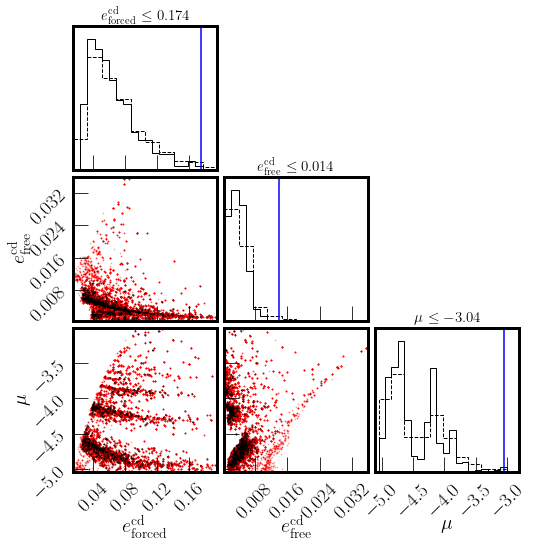

In [162]:
corner_plot(inres_params, spock_inres, threesig_inres, pl_b=False, weighted=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

In [163]:
print((10**threesig_inres[-1])/9.54e-4)

0.9576442537722625


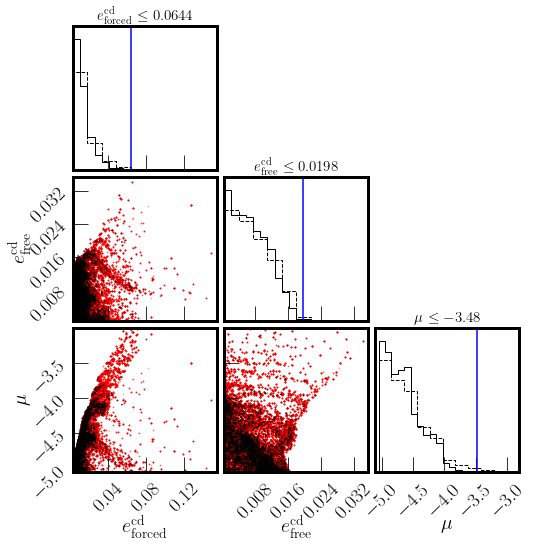

In [164]:
corner_plot(outres_params, spock_outres, threesig_outres, pl_b=False, weighted=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

In [165]:
print((10**threesig_outres[-1])/9.54e-4)

0.35065318014994634


## Time series panels


0it [00:00, ?it/s]
6it [00:00, 58.34it/s]
12it [00:00, 49.07it/s]
18it [00:00, 50.57it/s]
24it [00:00, 52.53it/s]
30it [00:00, 52.30it/s]
36it [00:00, 52.66it/s]
42it [00:00, 53.25it/s]
48it [00:00, 52.91it/s]
54it [00:01, 54.22it/s]
60it [00:01, 54.00it/s]
66it [00:01, 54.07it/s]
72it [00:01, 55.06it/s]
78it [00:01, 54.38it/s]
84it [00:01, 54.14it/s]
90it [00:01, 54.26it/s]
100it [00:01, 53.53it/s][A


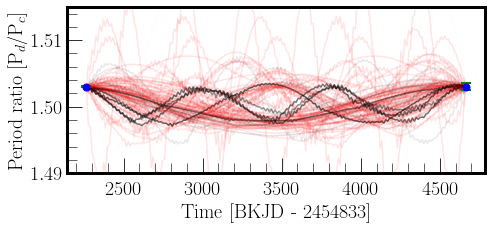

In [174]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_inres[:100])):
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    if spock_inres[i] != 0.0:
        ax.plot(time_grid,period_ratios,
             alpha=spock_inres[i],zorder=0, c='k',
             rasterized=True)
    elif spock_inres[i] == 0.0:
        ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='r',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='b',ecolor='g',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.515)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()


0it [00:00, ?it/s]
6it [00:00, 56.00it/s]
12it [00:00, 49.98it/s]
18it [00:00, 49.34it/s]
23it [00:00, 49.03it/s]
28it [00:00, 48.63it/s]
33it [00:00, 48.61it/s]
38it [00:00, 48.84it/s]
44it [00:00, 49.21it/s]
50it [00:01, 49.56it/s]
55it [00:01, 49.30it/s]
61it [00:01, 51.15it/s]
67it [00:01, 52.53it/s]
73it [00:01, 54.03it/s]
79it [00:01, 54.64it/s]
85it [00:01, 55.23it/s]
91it [00:01, 54.99it/s]
100it [00:01, 51.95it/s][A


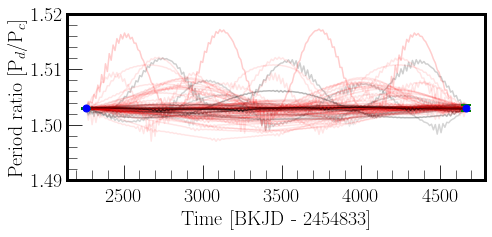

In [175]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_outres[:100])):
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    if spock_outres[i] != 0.0:
        ax.plot(time_grid,period_ratios,
             alpha=spock_outres[i],zorder=0, c='k',
             rasterized=True)
    elif spock_outres[i] == 0.0:
        ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='r',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='b',ecolor='g',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.520)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

# Figure 2

In [168]:
rv_inres_deltaT = [param[:4] for param in rv_inres]

In [169]:
j=3
k=1
phi_rv, Phinorm_rv = get_Phinorm(rv_inres_deltaT)


0it [00:00, ?it/s]
5it [00:00, 41.63it/s]
10it [00:00, 42.16it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")

15it [00:00, 43.67it/s]
20it [00:00, 43.16it/s]
25it [00:00, 43.66it/s]
30it [00:00, 44.67it/s]
35it [00:00, 44.41it/s]
40it [00:00, 42.63it/s]
45it [00:01, 42.57it/s]
50it [00:01, 43.14it/s]
55it [00:01, 43.15it/s]
60it [00:01, 43.97it/s]
65it [00:01, 42.99it/s]
70it [00:01, 42.76it/s]
75it [00:01, 42.12it/s]
80it [00:01, 42.34it/s]
85it [00:01, 42.83it/s]
90it [00:02, 43.41it/s]
95it [00:02, 42.90it/s]
100it [00:02, 41.63it/s]
105it [00:02, 41.41it/s]
110it [00:02, 41.30it/s]
115it [00:02, 42.10it/s]
120it [00:02, 42.41it/s]
125it [00:02, 42.04it/s]
130it [00:03, 41.32it/s]
135it [00:03, 42.40it/s]
140it [00:03, 43.94it/s]
145it [00:03, 44.18it/s]
150it [00:03, 44.14it/s]
155it [00:03, 44.19it/s]
160it [00:03, 44

1415it [00:31, 45.31it/s]
1420it [00:31, 45.09it/s]
1425it [00:31, 44.92it/s]
1430it [00:31, 45.09it/s]
1435it [00:32, 44.67it/s]
1440it [00:32, 44.92it/s]
1445it [00:32, 45.07it/s]
1450it [00:32, 44.98it/s]
1455it [00:32, 45.35it/s]
1460it [00:32, 45.64it/s]
1465it [00:32, 45.51it/s]
1470it [00:32, 45.97it/s]
1475it [00:32, 46.05it/s]
1480it [00:33, 46.10it/s]
1485it [00:33, 45.55it/s]
1490it [00:33, 45.50it/s]
1495it [00:33, 45.36it/s]
1500it [00:33, 45.19it/s]
1505it [00:33, 44.49it/s]
1510it [00:33, 44.85it/s]
1515it [00:33, 45.28it/s]
1520it [00:33, 45.35it/s]
1525it [00:34, 45.36it/s]
1530it [00:34, 45.05it/s]
1535it [00:34, 45.72it/s]
1540it [00:34, 44.80it/s]
1545it [00:34, 44.83it/s]
1550it [00:34, 44.64it/s]
1555it [00:34, 45.35it/s]
1560it [00:34, 45.44it/s]
1565it [00:34, 45.20it/s]
1570it [00:35, 44.90it/s]
1575it [00:35, 42.10it/s]
1580it [00:35, 43.36it/s]
1585it [00:35, 43.69it/s]
1590it [00:35, 44.20it/s]
1595it [00:35, 45.13it/s]
1600it [00:35, 45.44it/s]
1605it [00:3

2820it [01:03, 41.72it/s]
2825it [01:03, 41.30it/s]
2830it [01:04, 41.66it/s]
2835it [01:04, 41.84it/s]
2840it [01:04, 42.55it/s]
2845it [01:04, 42.07it/s]
2850it [01:04, 41.30it/s]
2855it [01:04, 41.68it/s]
2860it [01:04, 41.11it/s]
2865it [01:04, 41.32it/s]
2870it [01:04, 40.89it/s]
2875it [01:05, 41.13it/s]
2880it [01:05, 41.67it/s]
2885it [01:05, 42.90it/s]
2890it [01:05, 43.46it/s]
2895it [01:05, 43.68it/s]
2900it [01:05, 44.05it/s]
2905it [01:05, 44.12it/s]
2910it [01:05, 44.37it/s]
2915it [01:06, 43.90it/s]
2920it [01:06, 44.42it/s]
2925it [01:06, 45.20it/s]
2930it [01:06, 45.17it/s]
2935it [01:06, 44.50it/s]
2940it [01:06, 44.53it/s]
2945it [01:06, 44.60it/s]
2950it [01:06, 43.94it/s]
2955it [01:06, 40.86it/s]
2960it [01:07, 41.55it/s]
2965it [01:07, 42.50it/s]
2970it [01:07, 43.07it/s]
2975it [01:07, 43.09it/s]
2980it [01:07, 42.89it/s]
2985it [01:07, 43.87it/s]
2990it [01:07, 44.31it/s]
2995it [01:07, 44.17it/s]
3000it [01:07, 44.37it/s]
3005it [01:08, 44.31it/s]
3010it [01:0

4230it [01:35, 45.99it/s]
4235it [01:35, 45.72it/s]
4240it [01:35, 45.56it/s]
4245it [01:35, 45.78it/s]
4250it [01:35, 45.74it/s]
4255it [01:36, 45.96it/s]
4260it [01:36, 45.96it/s]
4265it [01:36, 45.48it/s]
4270it [01:36, 44.95it/s]
4275it [01:36, 45.35it/s]
4280it [01:36, 45.43it/s]
4285it [01:36, 44.87it/s]
4290it [01:36, 44.75it/s]
4295it [01:36, 44.62it/s]
4300it [01:37, 43.80it/s]
4305it [01:37, 43.88it/s]
4310it [01:37, 44.06it/s]
4315it [01:37, 44.15it/s]
4320it [01:37, 44.26it/s]
4325it [01:37, 44.88it/s]
4330it [01:37, 44.56it/s]
4335it [01:37, 45.31it/s]
4340it [01:37, 45.80it/s]
4345it [01:38, 46.06it/s]
4350it [01:38, 46.13it/s]
4355it [01:38, 45.54it/s]
4360it [01:38, 45.36it/s]
4365it [01:38, 46.26it/s]
4370it [01:38, 46.09it/s]
4375it [01:38, 46.05it/s]
4380it [01:38, 45.49it/s]
4385it [01:38, 45.32it/s]
4390it [01:39, 45.73it/s]
4395it [01:39, 46.05it/s]
4400it [01:39, 46.01it/s]
4405it [01:39, 46.34it/s]
4410it [01:39, 46.12it/s]
4415it [01:39, 45.46it/s]
4420it [01:3

5640it [02:06, 43.69it/s]
5645it [02:06, 43.62it/s]
5650it [02:07, 43.86it/s]
5655it [02:07, 43.58it/s]
5660it [02:07, 43.90it/s]
5665it [02:07, 44.54it/s]
5670it [02:07, 44.98it/s]
5675it [02:07, 44.85it/s]
5680it [02:07, 44.46it/s]
5685it [02:07, 45.20it/s]
5690it [02:07, 45.35it/s]
5695it [02:08, 45.52it/s]
5700it [02:08, 46.07it/s]
5705it [02:08, 45.46it/s]
5710it [02:08, 45.26it/s]
5715it [02:08, 45.25it/s]
5720it [02:08, 45.65it/s]
5725it [02:08, 45.48it/s]
5730it [02:08, 45.84it/s]
5735it [02:08, 45.40it/s]
5740it [02:09, 45.28it/s]
5745it [02:09, 45.42it/s]
5750it [02:09, 45.21it/s]
5755it [02:09, 45.06it/s]
5760it [02:09, 45.06it/s]
5765it [02:09, 45.75it/s]
5770it [02:09, 46.01it/s]
5775it [02:09, 45.89it/s]
5780it [02:09, 45.07it/s]
5785it [02:10, 45.23it/s]
5790it [02:10, 45.52it/s]
5795it [02:10, 45.90it/s]
5800it [02:10, 45.99it/s]
5805it [02:10, 45.97it/s]
5810it [02:10, 45.47it/s]
5815it [02:10, 45.04it/s]
5820it [02:10, 44.72it/s]
5825it [02:10, 44.92it/s]
5830it [02:1

7047it [02:38, 42.70it/s]
7052it [02:38, 41.93it/s]
7057it [02:38, 41.77it/s]
7062it [02:38, 43.06it/s]
7067it [02:38, 43.70it/s]
7072it [02:38, 44.22it/s]
7077it [02:38, 44.65it/s]
7082it [02:39, 45.82it/s]
7087it [02:39, 45.69it/s]
7092it [02:39, 45.78it/s]
7097it [02:39, 45.30it/s]
7102it [02:39, 45.27it/s]
7107it [02:39, 44.60it/s]
7112it [02:39, 43.87it/s]
7117it [02:39, 43.64it/s]
7122it [02:39, 41.49it/s]
7127it [02:40, 42.39it/s]
7132it [02:40, 42.32it/s]
7137it [02:40, 43.04it/s]
7142it [02:40, 43.72it/s]
7147it [02:40, 43.65it/s]
7152it [02:40, 44.73it/s]
7157it [02:40, 45.39it/s]
7162it [02:40, 44.51it/s]
7167it [02:40, 44.56it/s]
7172it [02:41, 43.99it/s]
7177it [02:41, 44.28it/s]
7182it [02:41, 45.02it/s]
7187it [02:41, 44.68it/s]
7192it [02:41, 44.59it/s]
7197it [02:41, 44.76it/s]
7202it [02:41, 44.81it/s]
7207it [02:41, 44.92it/s]
7212it [02:41, 45.23it/s]
7217it [02:42, 45.23it/s]
7222it [02:42, 44.94it/s]
7227it [02:42, 45.03it/s]
7232it [02:42, 45.31it/s]
7237it [02:4

8457it [03:09, 44.14it/s]
8462it [03:10, 44.00it/s]
8467it [03:10, 44.12it/s]
8472it [03:10, 44.58it/s]
8477it [03:10, 44.77it/s]
8482it [03:10, 44.16it/s]
8487it [03:10, 44.07it/s]
8492it [03:10, 44.66it/s]
8497it [03:10, 45.00it/s]
8502it [03:10, 44.93it/s]
8507it [03:11, 45.41it/s]
8512it [03:11, 45.74it/s]
8517it [03:11, 45.16it/s]
8522it [03:11, 45.04it/s]
8527it [03:11, 45.02it/s]
8532it [03:11, 45.42it/s]
8537it [03:11, 44.74it/s]
8542it [03:11, 45.44it/s]
8547it [03:11, 45.50it/s]
8552it [03:12, 45.50it/s]
8557it [03:12, 44.63it/s]
8562it [03:12, 44.46it/s]
8567it [03:12, 44.23it/s]
8572it [03:12, 44.72it/s]
8577it [03:12, 45.17it/s]
8582it [03:12, 44.73it/s]
8587it [03:12, 45.23it/s]
8592it [03:12, 45.24it/s]
8597it [03:13, 44.94it/s]
8602it [03:13, 44.55it/s]
8607it [03:13, 45.25it/s]
8612it [03:13, 45.03it/s]
8617it [03:13, 44.95it/s]
8622it [03:13, 44.64it/s]
8627it [03:13, 44.92it/s]
8632it [03:13, 45.02it/s]
8637it [03:13, 44.92it/s]
8642it [03:14, 44.47it/s]
8647it [03:1

9867it [03:41, 45.92it/s]
9872it [03:41, 45.67it/s]
9877it [03:41, 45.50it/s]
9882it [03:41, 45.03it/s]
9887it [03:41, 44.51it/s]
9892it [03:41, 44.67it/s]
9897it [03:41, 45.06it/s]
9902it [03:41, 45.07it/s]
9907it [03:42, 44.49it/s]
9912it [03:42, 45.41it/s]
9917it [03:42, 45.30it/s]
9922it [03:42, 45.57it/s]
9927it [03:42, 45.93it/s]
9932it [03:42, 45.79it/s]
9937it [03:42, 45.54it/s]
9942it [03:42, 45.08it/s]
9947it [03:42, 45.05it/s]
9952it [03:43, 44.90it/s]
9957it [03:43, 45.48it/s]
9962it [03:43, 45.32it/s]
9967it [03:43, 45.42it/s]
9972it [03:43, 45.37it/s]
9977it [03:43, 45.09it/s]
9982it [03:43, 45.09it/s]
9987it [03:43, 45.02it/s]
9992it [03:43, 44.28it/s]
9997it [03:44, 44.62it/s]
10002it [03:44, 44.45it/s]
10007it [03:44, 45.12it/s]
10012it [03:44, 45.27it/s]
10017it [03:44, 45.49it/s]
10022it [03:44, 44.96it/s]
10027it [03:44, 45.75it/s]
10032it [03:44, 45.69it/s]
10037it [03:44, 45.37it/s]
10042it [03:45, 44.45it/s]
10047it [03:45, 44.20it/s]
10052it [03:45, 44.54it/s]
1

11237it [04:11, 44.79it/s]
11242it [04:11, 45.00it/s]
11247it [04:11, 45.13it/s]
11252it [04:11, 45.38it/s]
11257it [04:11, 45.98it/s]
11262it [04:12, 44.90it/s]
11267it [04:12, 44.73it/s]
11272it [04:12, 44.38it/s]
11277it [04:12, 44.48it/s]
11282it [04:12, 44.49it/s]
11287it [04:12, 44.05it/s]
11292it [04:12, 45.03it/s]
11297it [04:12, 45.18it/s]
11302it [04:12, 45.12it/s]
11307it [04:13, 45.44it/s]
11312it [04:13, 45.00it/s]
11317it [04:13, 45.31it/s]
11322it [04:13, 45.21it/s]
11327it [04:13, 44.99it/s]
11332it [04:13, 44.75it/s]
11337it [04:13, 45.01it/s]
11342it [04:13, 45.57it/s]
11347it [04:13, 44.52it/s]
11352it [04:14, 45.17it/s]
11357it [04:14, 44.90it/s]
11362it [04:14, 45.01it/s]
11367it [04:14, 45.32it/s]
11372it [04:14, 45.59it/s]
11377it [04:14, 45.38it/s]
11382it [04:14, 45.25it/s]
11387it [04:14, 45.18it/s]
11392it [04:14, 45.66it/s]
11397it [04:15, 45.26it/s]
11402it [04:15, 45.30it/s]
11407it [04:15, 45.30it/s]
11412it [04:15, 44.77it/s]
11417it [04:15, 44.52it/s]
1

12602it [04:41, 45.00it/s]
12607it [04:41, 45.36it/s]
12612it [04:42, 45.07it/s]
12617it [04:42, 44.82it/s]
12622it [04:42, 44.88it/s]
12627it [04:42, 44.82it/s]
12632it [04:42, 45.06it/s]
12637it [04:42, 45.11it/s]
12642it [04:42, 45.41it/s]
12647it [04:42, 45.53it/s]
12652it [04:42, 44.73it/s]
12657it [04:43, 44.73it/s]
12662it [04:43, 44.89it/s]
12667it [04:43, 45.34it/s]
12672it [04:43, 45.19it/s]
12677it [04:43, 45.29it/s]
12682it [04:43, 45.10it/s]
12687it [04:43, 44.79it/s]
12692it [04:43, 44.59it/s]
12697it [04:43, 45.21it/s]
12702it [04:44, 45.21it/s]
12707it [04:44, 45.69it/s]
12712it [04:44, 45.60it/s]
12717it [04:44, 46.05it/s]
12722it [04:44, 45.63it/s]
12727it [04:44, 45.28it/s]
12732it [04:44, 45.57it/s]
12737it [04:44, 45.26it/s]
12742it [04:44, 44.55it/s]
12747it [04:45, 44.54it/s]
12752it [04:45, 44.23it/s]
12757it [04:45, 44.14it/s]
12762it [04:45, 44.42it/s]
12767it [04:45, 45.23it/s]
12772it [04:45, 45.14it/s]
12777it [04:45, 44.87it/s]
12782it [04:45, 44.93it/s]
1

13967it [05:12, 45.47it/s]
13972it [05:12, 44.56it/s]
13977it [05:12, 44.83it/s]
13982it [05:12, 45.04it/s]
13987it [05:12, 45.52it/s]
13992it [05:12, 43.47it/s]
13997it [05:12, 44.11it/s]
14002it [05:12, 44.09it/s]
14007it [05:13, 44.55it/s]
14012it [05:13, 45.56it/s]
14017it [05:13, 45.25it/s]
14022it [05:13, 45.27it/s]
14027it [05:13, 45.66it/s]
14032it [05:13, 45.47it/s]
14037it [05:13, 45.39it/s]
14042it [05:13, 45.97it/s]
14047it [05:13, 46.27it/s]
14052it [05:14, 45.88it/s]
14057it [05:14, 45.81it/s]
14062it [05:14, 45.59it/s]
14067it [05:14, 45.71it/s]
14072it [05:14, 45.72it/s]
14077it [05:14, 45.34it/s]
14082it [05:14, 44.54it/s]
14087it [05:14, 44.87it/s]
14092it [05:14, 44.82it/s]
14097it [05:15, 44.49it/s]
14102it [05:15, 44.41it/s]
14107it [05:15, 44.28it/s]
14112it [05:15, 44.80it/s]
14117it [05:15, 45.59it/s]
14122it [05:15, 45.14it/s]
14127it [05:15, 45.50it/s]
14132it [05:15, 45.89it/s]
14137it [05:15, 46.29it/s]
14142it [05:15, 46.57it/s]
14147it [05:16, 46.01it/s]
1

15332it [05:42, 45.40it/s]
15337it [05:42, 45.52it/s]
15342it [05:42, 45.92it/s]
15347it [05:42, 45.75it/s]
15352it [05:42, 45.27it/s]
15357it [05:42, 45.44it/s]
15362it [05:43, 44.72it/s]
15367it [05:43, 44.96it/s]
15372it [05:43, 44.13it/s]
15377it [05:43, 44.46it/s]
15382it [05:43, 45.25it/s]
15387it [05:43, 45.35it/s]
15392it [05:43, 44.85it/s]
15397it [05:43, 44.68it/s]
15402it [05:43, 44.50it/s]
15407it [05:44, 44.02it/s]
15412it [05:44, 44.32it/s]
15417it [05:44, 43.47it/s]
15422it [05:44, 44.27it/s]
15427it [05:44, 45.14it/s]
15432it [05:44, 44.83it/s]
15437it [05:44, 45.52it/s]
15442it [05:44, 45.76it/s]
15447it [05:44, 45.55it/s]
15452it [05:45, 45.96it/s]
15457it [05:45, 45.77it/s]
15462it [05:45, 45.94it/s]
15467it [05:45, 45.64it/s]
15472it [05:45, 45.14it/s]
15477it [05:45, 45.60it/s]
15482it [05:45, 45.43it/s]
15487it [05:45, 45.19it/s]
15492it [05:45, 45.08it/s]
15497it [05:46, 45.30it/s]
15502it [05:46, 45.82it/s]
15507it [05:46, 46.10it/s]
15512it [05:46, 45.60it/s]
1

16697it [06:12, 45.04it/s]
16702it [06:12, 44.80it/s]
16707it [06:12, 44.76it/s]
16712it [06:12, 45.38it/s]
16717it [06:13, 45.25it/s]
16722it [06:13, 45.42it/s]
16727it [06:13, 45.37it/s]
16732it [06:13, 45.27it/s]
16737it [06:13, 45.25it/s]
16742it [06:13, 45.16it/s]
16747it [06:13, 45.14it/s]
16752it [06:13, 45.28it/s]
16757it [06:13, 45.35it/s]
16762it [06:14, 45.78it/s]
16767it [06:14, 45.72it/s]
16772it [06:14, 45.17it/s]
16777it [06:14, 45.44it/s]
16782it [06:14, 45.37it/s]
16787it [06:14, 44.89it/s]
16792it [06:14, 44.77it/s]
16797it [06:14, 45.52it/s]
16802it [06:14, 45.53it/s]
16807it [06:15, 45.54it/s]
16812it [06:15, 45.10it/s]
16817it [06:15, 44.86it/s]
16822it [06:15, 45.20it/s]
16827it [06:15, 44.49it/s]
16832it [06:15, 44.50it/s]
16837it [06:15, 44.45it/s]
16842it [06:15, 44.49it/s]
16847it [06:15, 44.04it/s]
16852it [06:16, 44.15it/s]
16857it [06:16, 44.28it/s]
16862it [06:16, 44.53it/s]
16867it [06:16, 44.94it/s]
16872it [06:16, 44.81it/s]
16877it [06:16, 44.30it/s]
1

18062it [06:42, 46.07it/s]
18067it [06:43, 45.65it/s]
18072it [06:43, 46.00it/s]
18077it [06:43, 45.87it/s]
18082it [06:43, 46.08it/s]
18087it [06:43, 45.47it/s]
18092it [06:43, 45.27it/s]
18097it [06:43, 45.74it/s]
18102it [06:43, 45.50it/s]
18107it [06:43, 45.77it/s]
18112it [06:44, 45.23it/s]
18117it [06:44, 45.18it/s]
18122it [06:44, 45.74it/s]
18127it [06:44, 45.58it/s]
18132it [06:44, 45.25it/s]
18137it [06:44, 44.88it/s]
18142it [06:44, 44.53it/s]
18147it [06:44, 44.79it/s]
18152it [06:44, 45.37it/s]
18157it [06:45, 45.26it/s]
18162it [06:45, 45.15it/s]
18167it [06:45, 45.73it/s]
18172it [06:45, 45.43it/s]
18177it [06:45, 45.87it/s]
18182it [06:45, 45.58it/s]
18187it [06:45, 45.76it/s]
18192it [06:45, 45.77it/s]
18197it [06:45, 45.50it/s]
18202it [06:46, 44.79it/s]
18207it [06:46, 44.94it/s]
18212it [06:46, 44.82it/s]
18217it [06:46, 45.39it/s]
18222it [06:46, 45.75it/s]
18227it [06:46, 45.67it/s]
18232it [06:46, 45.58it/s]
18237it [06:46, 44.66it/s]
18242it [06:46, 45.27it/s]
1

19427it [07:13, 45.34it/s]
19432it [07:13, 45.46it/s]
19437it [07:13, 45.52it/s]
19442it [07:13, 45.30it/s]
19447it [07:13, 44.85it/s]
19452it [07:13, 45.37it/s]
19457it [07:13, 44.01it/s]
19462it [07:13, 44.91it/s]
19467it [07:14, 44.45it/s]
19472it [07:14, 44.53it/s]
19477it [07:14, 44.39it/s]
19482it [07:14, 44.76it/s]
19487it [07:14, 44.95it/s]
19492it [07:14, 45.18it/s]
19497it [07:14, 45.74it/s]
19502it [07:14, 45.79it/s]
19507it [07:14, 44.74it/s]
19512it [07:14, 45.00it/s]
19517it [07:15, 45.14it/s]
19522it [07:15, 45.35it/s]
19527it [07:15, 45.44it/s]
19532it [07:15, 45.56it/s]
19537it [07:15, 45.36it/s]
19542it [07:15, 45.32it/s]
19547it [07:15, 45.42it/s]
19552it [07:15, 45.38it/s]
19557it [07:15, 45.32it/s]
19562it [07:16, 45.74it/s]
19567it [07:16, 45.02it/s]
19572it [07:16, 45.03it/s]
19577it [07:16, 44.78it/s]
19582it [07:16, 44.42it/s]
19587it [07:16, 44.47it/s]
19592it [07:16, 44.52it/s]
19597it [07:16, 44.61it/s]
19602it [07:16, 45.07it/s]
19607it [07:17, 45.20it/s]
1

20792it [07:43, 45.12it/s]
20797it [07:43, 45.54it/s]
20802it [07:43, 45.26it/s]
20807it [07:43, 44.90it/s]
20812it [07:43, 44.64it/s]
20817it [07:43, 45.16it/s]
20822it [07:44, 44.79it/s]
20827it [07:44, 44.92it/s]
20832it [07:44, 44.57it/s]
20837it [07:44, 44.61it/s]
20842it [07:44, 44.81it/s]
20847it [07:44, 45.16it/s]
20852it [07:44, 45.56it/s]
20857it [07:44, 45.39it/s]
20862it [07:44, 45.58it/s]
20867it [07:45, 45.84it/s]
20872it [07:45, 44.96it/s]
20877it [07:45, 44.71it/s]
20882it [07:45, 45.20it/s]
20887it [07:45, 45.03it/s]
20892it [07:45, 44.63it/s]
20897it [07:45, 44.87it/s]
20902it [07:45, 44.50it/s]
20907it [07:45, 44.67it/s]
20912it [07:46, 44.96it/s]
20917it [07:46, 44.20it/s]
20922it [07:46, 44.91it/s]
20927it [07:46, 44.73it/s]
20932it [07:46, 45.75it/s]
20937it [07:46, 45.21it/s]
20942it [07:46, 45.40it/s]
20947it [07:46, 45.31it/s]
20952it [07:46, 45.20it/s]
20957it [07:47, 45.63it/s]
20962it [07:47, 45.75it/s]
20967it [07:47, 46.21it/s]
20972it [07:47, 45.59it/s]
2

In [170]:
np.save('stability_posteriors/phi_rv_randomtheta.npy', phi_rv)
np.save('stability_posteriors/Phinorm_rv_randomtheta.npy', Phinorm_rv)
# you stopped here, continue updating figures 2 and 3 from here (03/02/2022)

In [118]:
# with zero integration time:
j=3
k=1
phi_rv_nodelta, Phinorm_rv_nodelta = get_Phinorm(rv_inres_deltaT)

27it [00:00, 44.23it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")
21452it [07:52, 45.38it/s]


<ipython-input-247-4772ea751475>:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)


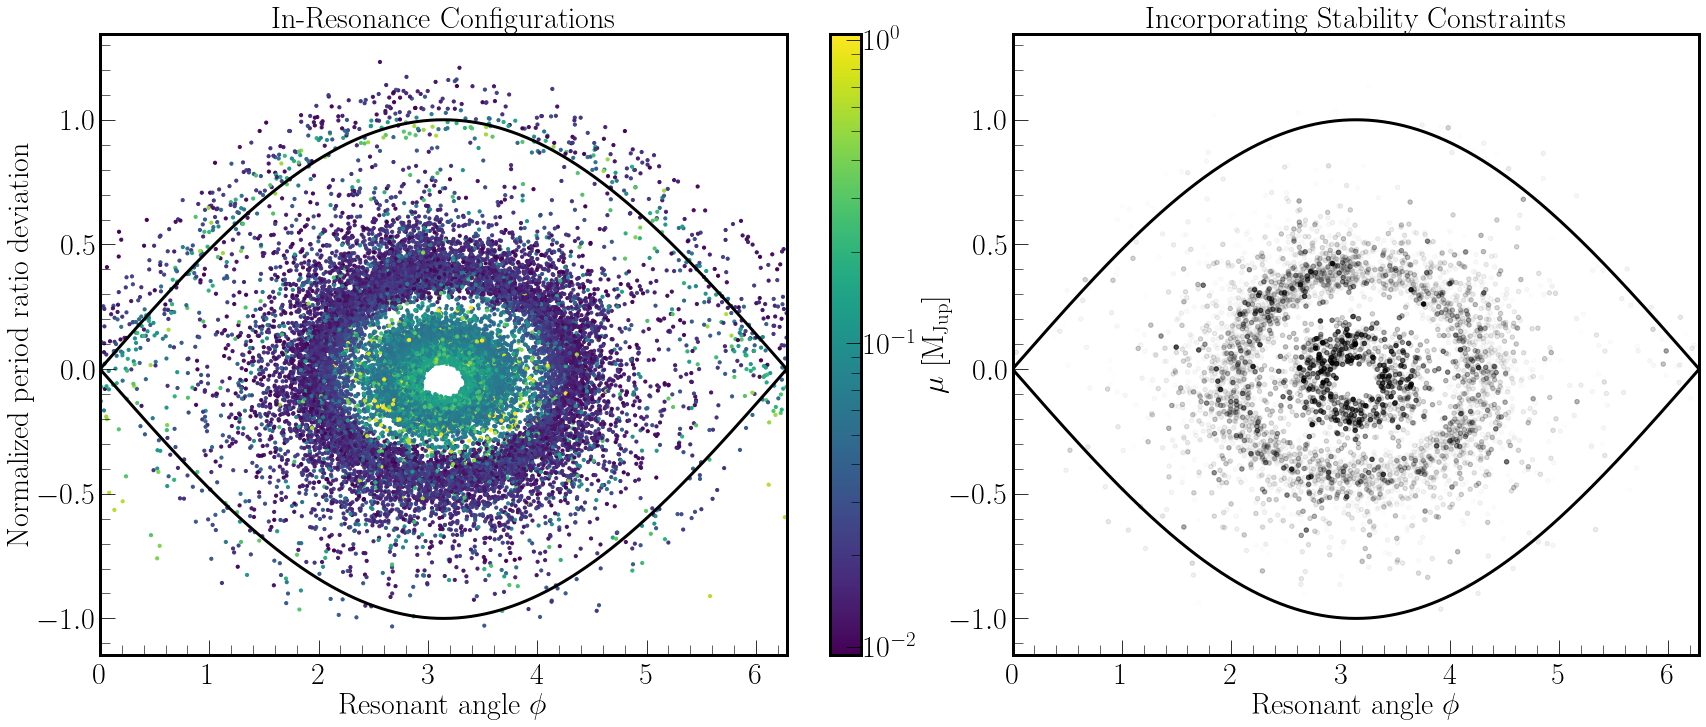

In [247]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7*3.4, 4.0*3.4*3/4.),
                         gridspec_kw={'width_ratios': [1, 0.80]})
ax1 = axes[0]
ax2 = axes[1]

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k',lw=3)
ax1.plot(phis, -sep_upper, 'k',lw=3)
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
mu_mjup = np.array([(10**(param[2]))/9.54e-4 for param in rv_inres])

cb=ax1.scatter(phi_rv, Phinorm_rv, 
              c=mu_mjup,norm=colors.LogNorm(vmin=mu_mjup.min(), vmax=mu_mjup.max()),
              s=10, rasterized=True,cmap='viridis')
#cb=ax1.scatter(phi_rv, Phinorm_rv, 
#              c=[param[2] for param in rv_inres], 
#              s=10, rasterized=True)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax2.plot(phis, sep_upper, 'k',lw=3)
ax2.plot(phis, -sep_upper, 'k',lw=3)
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)

cb2=ax2.scatter(phi_rv, Phinorm_rv, 
              alpha=[prob for prob in spock_inres],c='k', 
              s=20) 

ax1.minorticks_on()
ax2.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

ax1.set_title('In-Resonance Configurations',fontsize=30)
ax2.set_title('Incorporating Stability Constraints',fontsize=30)

plt.tight_layout()
plt.subplots_adjust(wspace=0.07)
plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

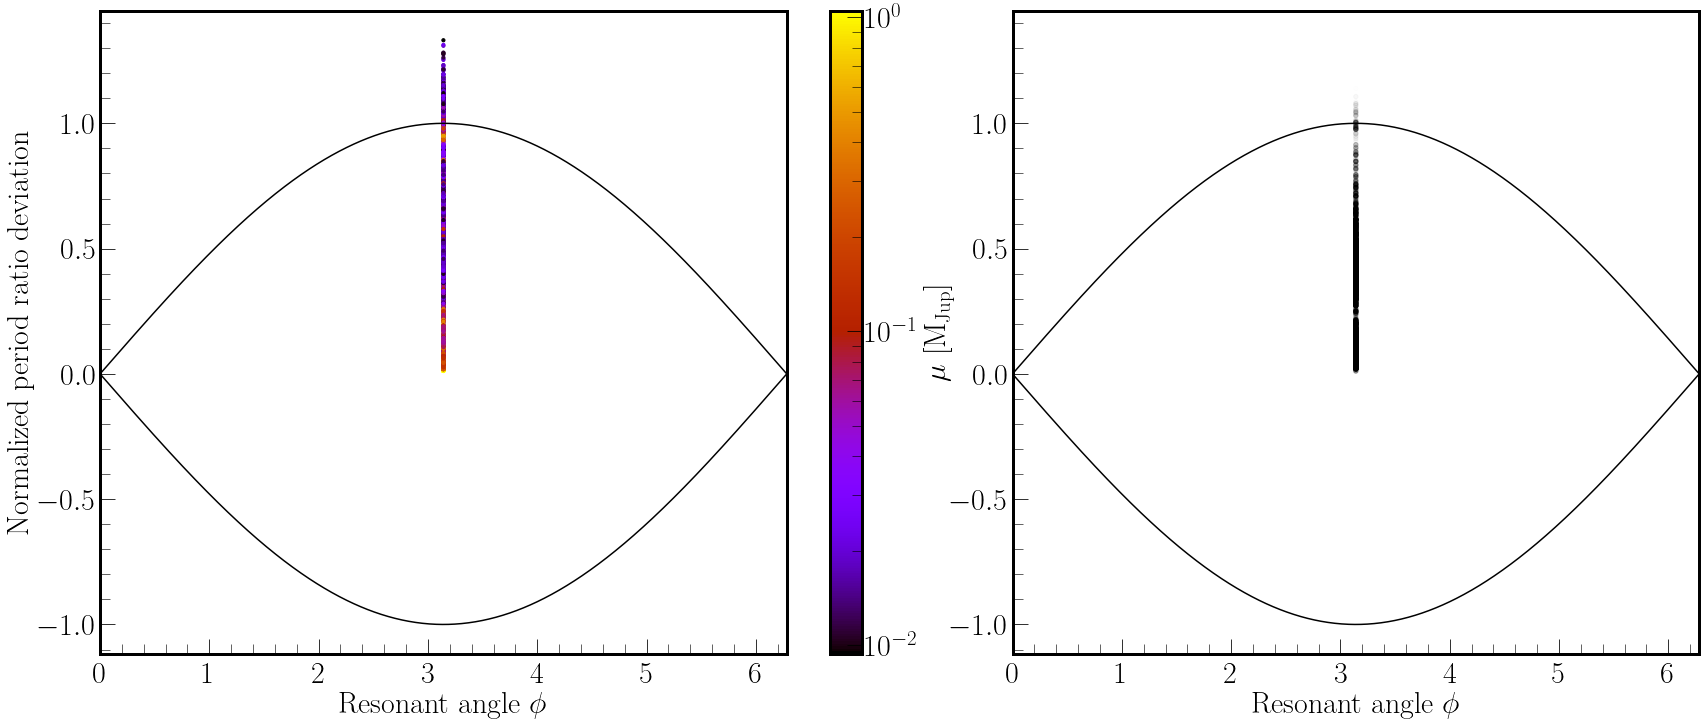

In [119]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7*3.4, 4.0*3.4*3/4.),
                         gridspec_kw={'width_ratios': [1, 0.80]})
ax1 = axes[0]
ax2 = axes[1]

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
mu_mjup = np.array([(10**(param[2]))/9.54e-4 for param in rv_inres])

cb=ax1.scatter(phi_rv_nodelta, Phinorm_rv_nodelta, 
              c=mu_mjup,norm=colors.LogNorm(vmin=mu_mjup.min(), vmax=mu_mjup.max()),
              s=10, rasterized=True,cmap='gnuplot')
#cb=ax1.scatter(phi_rv, Phinorm_rv, 
#              c=[param[2] for param in rv_inres], 
#              s=10, rasterized=True)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)

cb2=ax2.scatter(phi_rv_nodelta, Phinorm_rv_nodelta, 
              alpha=[prob for prob in spock_inres],c='k', 
              s=20) 

ax1.minorticks_on()
ax2.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

plt.tight_layout()
plt.subplots_adjust(wspace=0.07)
#plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

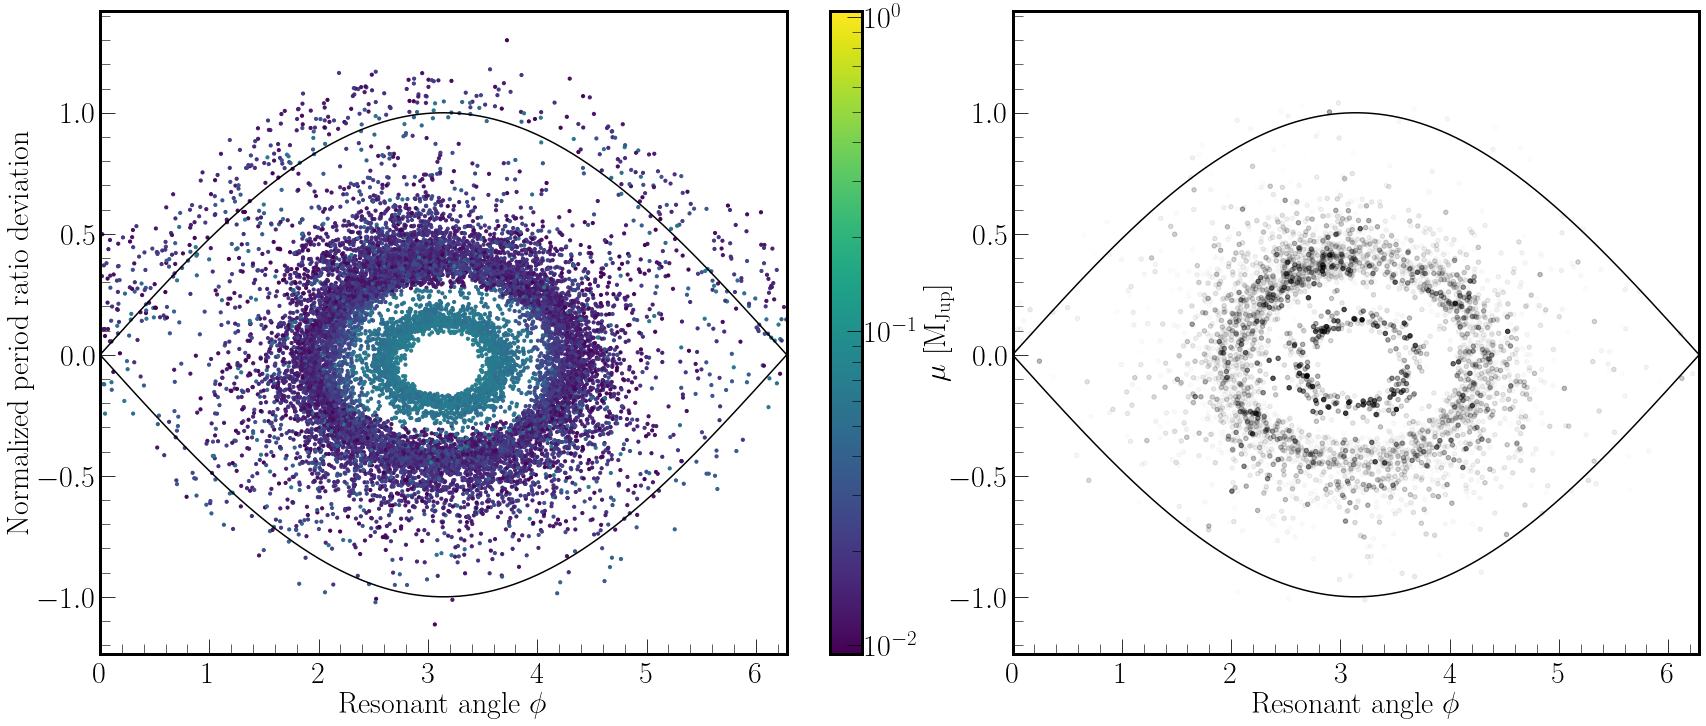

In [69]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7*3.4, 4.0*3.4*3/4.),
                         gridspec_kw={'width_ratios': [1, 0.80]})
ax1 = axes[0]
ax2 = axes[1]

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
mu_mjup = np.array([(10**(param[2]))/9.54e-4 for param in rv_inres])

cb=ax1.scatter(phi_rv[mu_mjup < 0.07], Phinorm_rv[mu_mjup < 0.07], 
              c=mu_mjup[mu_mjup < 0.07],norm=colors.LogNorm(vmin=mu_mjup.min(), 
                                                           vmax=mu_mjup.max()),
              s=10, rasterized=True)
#cb=ax1.scatter(phi_rv, Phinorm_rv, 
#              c=[param[2] for param in rv_inres], 
#              s=10, rasterized=True)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)

cb2=ax2.scatter(phi_rv[mu_mjup < 0.07], Phinorm_rv[mu_mjup < 0.07], 
              alpha=spock_inres[mu_mjup < 0.07],c='k', 
              s=20) 

ax1.minorticks_on()
ax2.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

plt.tight_layout()
plt.subplots_adjust(wspace=0.07)
#plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

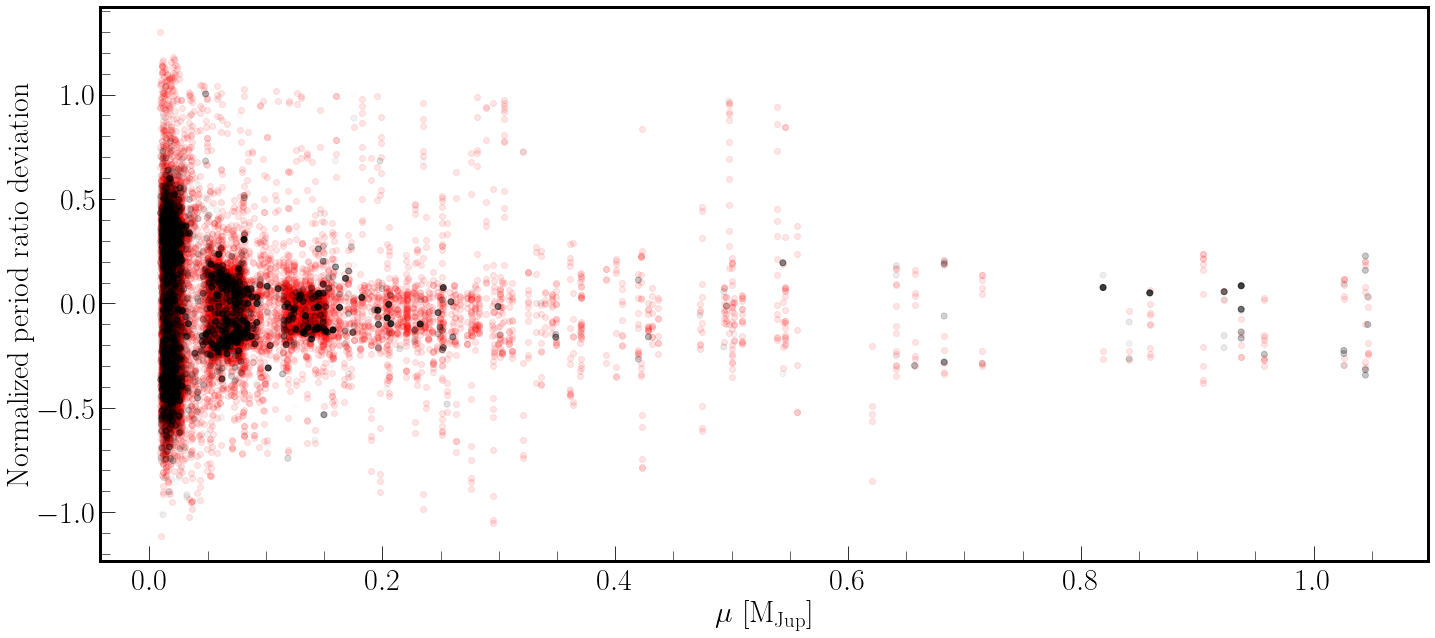

In [101]:
fig = plt.figure(figsize=(7*3.4, 4.0*3.4*3/4.))
plt.scatter(mu_mjup[spock_inres!=0.0], Phinorm_rv[spock_inres!=0.0],alpha=spock_inres[spock_inres!=0.0],c='k',
           zorder=1)
plt.scatter(mu_mjup[spock_inres==0.0], Phinorm_rv[spock_inres==0.0],alpha=0.1,c='r',zorder=0)
plt.xlabel(r'$\mu$ [M$_{\rm{Jup}}$]',fontsize=30)
plt.ylabel('Normalized period ratio deviation',fontsize=30)
plt.gca().tick_params(axis='y', labelsize=30)
plt.gca().tick_params(axis='x', labelsize=30)
plt.minorticks_on()

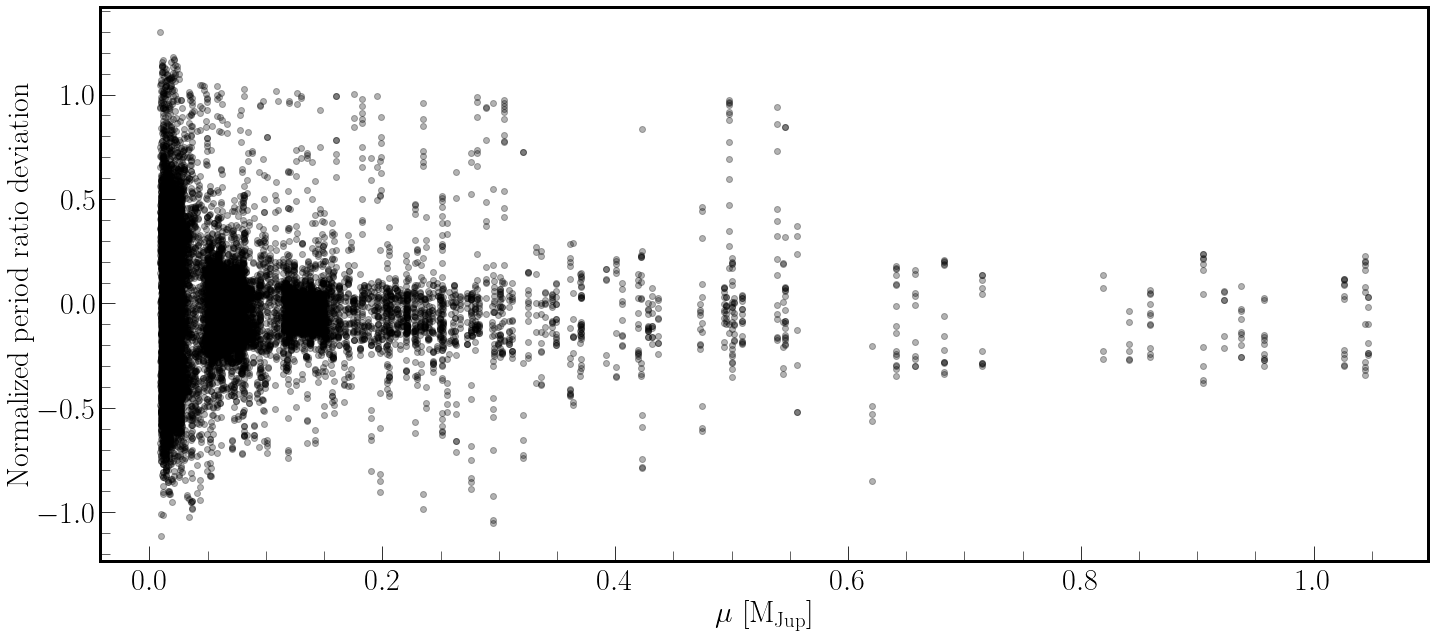

In [102]:
fig = plt.figure(figsize=(7*3.4, 4.0*3.4*3/4.))
plt.scatter(mu_mjup, Phinorm_rv,alpha=0.3,c='k',
           zorder=1)
plt.xlabel(r'$\mu$ [M$_{\rm{Jup}}$]',fontsize=30)
plt.ylabel('Normalized period ratio deviation',fontsize=30)
plt.gca().tick_params(axis='y', labelsize=30)
plt.gca().tick_params(axis='x', labelsize=30)
plt.minorticks_on()

# Figure 3

In [176]:
mb_array = (10**np.array([rv_post[i][-2] for i in range(len(rv_post))]))/9.54e-4
eb_array = np.array([rv_post[i][-1] for i in range(len(rv_post))])

In [211]:
mb_rv = stats.norm.rvs(0.64, 0.19, size=len(rv_post))
eb_rv = stats.truncnorm.rvs(a = (0 - 0.13)/0.07, b = np.inf, loc=0.13, scale=0.07, size=len(rv_post))

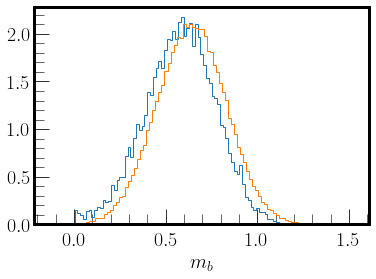

In [207]:
plt.hist(mb_array, bins=100, histtype='step', weights=preds_rv, density=True)
plt.hist(mb_rv, bins=100, histtype='step', density=True)
plt.xlabel('$m_b$')
plt.minorticks_on()
plt.show()

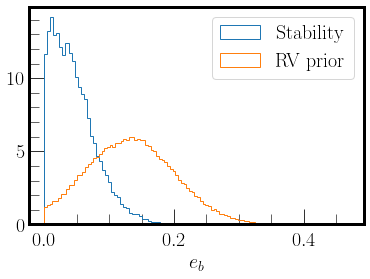

In [217]:
plt.hist(eb_array, bins=100, histtype='step', weights=preds_rv, density=True, label='Stability')
plt.hist(eb_rv, bins=100, histtype='step', density=True,label='RV prior')
plt.xlabel('$e_b$')
plt.legend()
plt.minorticks_on()
plt.show()

In [177]:
print('Stable resonant:',len(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] >= 0]))

Stable resonant: 194
Stable non-resonant: 28069


In [178]:
print('Unstable resonant:',
      len(mb_array[preds_rv == 0.0][np.array(deltaH_db)[preds_rv == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array[preds_rv == 0.0][np.array(deltaH_db)[preds_rv == 0.0] >= 0]))

Unstable resonant: 6532
Unstable non-resonant: 65205


In [34]:
#deltaH_cd_logu = get_deltaH(logu_post,j=3, k=1, i1=1, i2=2)
#deltaH_db_logu = get_deltaH(logu_post,j=2, k=1, i1=2, i2=3)

#np.save('stability_posteriors/deltaH_cd_logu.npy',deltaH_cd_logu)
#np.save('stability_posteriors/deltaH_db_logu.npy',deltaH_db_logu)


0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")

8it [00:00, 79.77it/s]
16it [00:00, 79.29it/s]
25it [00:00, 82.76it/s]
34it [00:00, 81.09it/s]
43it [00:00, 83.01it/s]
52it [00:00, 82.19it/s]
61it [00:00, 81.68it/s]
70it [00:00, 82.55it/s]
79it [00:00, 82.51it/s]
88it [00:01, 80.82it/s]
97it [00:01, 81.08it/s]
106it [00:01, 81.65it/s]
115it [00:01, 81.70it/s]
124it [00:01, 80.50it/s]
133it [00:01, 80.80it/s]
142it [00:01, 80.63it/s]
151it [00:01, 80.73it/s]
160it [00:01, 80.42it/s]
169it [00:02, 78.96it/s]
177it [00:02, 76.21it/s]
185it [00:02, 74.89it/s]
193it [00:02, 7

4885it [00:59, 84.11it/s]
4894it [00:59, 83.56it/s]
4903it [00:59, 84.49it/s]
4912it [00:59, 84.20it/s]
4921it [00:59, 84.22it/s]
4930it [01:00, 83.98it/s]
4939it [01:00, 85.18it/s]
4948it [01:00, 85.40it/s]
4957it [01:00, 85.01it/s]
4966it [01:00, 84.18it/s]
4975it [01:00, 84.61it/s]
4984it [01:00, 85.38it/s]
4993it [01:00, 85.87it/s]
5002it [01:00, 84.19it/s]
5011it [01:00, 84.95it/s]
5020it [01:01, 85.43it/s]
5030it [01:01, 87.26it/s]
5039it [01:01, 86.27it/s]
5048it [01:01, 86.23it/s]
5057it [01:01, 85.66it/s]
5066it [01:01, 85.23it/s]
5075it [01:01, 83.94it/s]
5084it [01:01, 83.45it/s]
5093it [01:01, 84.35it/s]
5102it [01:02, 84.86it/s]
5111it [01:02, 83.14it/s]
5120it [01:02, 84.28it/s]
5129it [01:02, 83.86it/s]
5138it [01:02, 84.54it/s]
5147it [01:02, 85.21it/s]
5156it [01:02, 85.61it/s]
5165it [01:02, 85.75it/s]
5174it [01:02, 85.21it/s]
5183it [01:03, 86.17it/s]
5192it [01:03, 85.81it/s]
5201it [01:03, 85.74it/s]
5210it [01:03, 86.57it/s]
5219it [01:03, 86.97it/s]
5228it [01:0

9963it [01:59, 84.23it/s]
9972it [01:59, 83.43it/s]
9981it [02:00, 84.24it/s]
9990it [02:00, 82.53it/s]
9999it [02:00, 81.52it/s]
10008it [02:00, 81.46it/s]
10017it [02:00, 82.19it/s]
10026it [02:00, 83.22it/s]
10035it [02:00, 81.95it/s]
10044it [02:00, 82.86it/s]
10053it [02:00, 82.48it/s]
10062it [02:01, 82.42it/s]
10071it [02:01, 83.25it/s]
10080it [02:01, 83.96it/s]
10089it [02:01, 83.07it/s]
10098it [02:01, 77.17it/s]
10107it [02:01, 78.53it/s]
10115it [02:01, 78.22it/s]
10124it [02:01, 80.47it/s]
10133it [02:01, 80.33it/s]
10142it [02:02, 79.26it/s]
10151it [02:02, 80.97it/s]
10160it [02:02, 81.23it/s]
10169it [02:02, 82.80it/s]
10178it [02:02, 83.57it/s]
10187it [02:02, 83.40it/s]
10196it [02:02, 82.65it/s]
10205it [02:02, 82.82it/s]
10214it [02:02, 82.89it/s]
10223it [02:02, 83.77it/s]
10232it [02:03, 82.76it/s]
10241it [02:03, 83.39it/s]
10250it [02:03, 82.94it/s]
10259it [02:03, 83.43it/s]
10268it [02:03, 84.35it/s]
10277it [02:03, 84.10it/s]
10286it [02:03, 84.62it/s]
10295i

14895it [02:57, 83.28it/s]
14904it [02:57, 83.27it/s]
14913it [02:57, 83.14it/s]
14922it [02:57, 83.73it/s]
14931it [02:58, 84.07it/s]
14940it [02:58, 79.13it/s]
14949it [02:58, 80.96it/s]
14958it [02:58, 81.21it/s]
14967it [02:58, 82.04it/s]
14976it [02:58, 82.93it/s]
14985it [02:58, 82.19it/s]
14994it [02:58, 81.58it/s]
15003it [02:58, 81.49it/s]
15012it [02:59, 82.26it/s]
15021it [02:59, 81.44it/s]
15030it [02:59, 80.99it/s]
15039it [02:59, 82.12it/s]
15048it [02:59, 80.79it/s]
15057it [02:59, 80.12it/s]
15066it [02:59, 80.02it/s]
15075it [02:59, 80.63it/s]
15084it [02:59, 81.47it/s]
15093it [03:00, 81.62it/s]
15102it [03:00, 81.77it/s]
15111it [03:00, 80.84it/s]
15120it [03:00, 81.63it/s]
15129it [03:00, 80.53it/s]
15138it [03:00, 81.22it/s]
15147it [03:00, 81.84it/s]
15156it [03:00, 83.08it/s]
15165it [03:00, 84.78it/s]
15175it [03:01, 86.67it/s]
15184it [03:01, 85.86it/s]
15193it [03:01, 85.95it/s]
15202it [03:01, 85.05it/s]
15211it [03:01, 84.37it/s]
15220it [03:01, 85.74it/s]
1

19747it [03:56, 85.88it/s]
19756it [03:56, 85.44it/s]
19765it [03:56, 84.69it/s]
19774it [03:56, 84.71it/s]
19783it [03:56, 85.37it/s]
19792it [03:57, 83.56it/s]
19801it [03:57, 84.75it/s]
19810it [03:57, 85.59it/s]
19819it [03:57, 84.25it/s]
19828it [03:57, 85.06it/s]
19838it [03:57, 86.61it/s]
19847it [03:57, 86.68it/s]
19856it [03:57, 86.55it/s]
19865it [03:57, 85.79it/s]
19874it [03:58, 84.97it/s]
19883it [03:58, 84.05it/s]
19892it [03:58, 84.66it/s]
19901it [03:58, 84.98it/s]
19910it [03:58, 85.67it/s]
19920it [03:58, 87.26it/s]
19929it [03:58, 85.32it/s]
19938it [03:58, 85.88it/s]
19947it [03:58, 86.28it/s]
19956it [03:58, 87.01it/s]
19965it [03:59, 87.31it/s]
19974it [03:59, 87.63it/s]
19983it [03:59, 87.11it/s]
19992it [03:59, 86.87it/s]
20001it [03:59, 86.34it/s]
20011it [03:59, 87.76it/s]
20020it [03:59, 86.62it/s]
20029it [03:59, 86.33it/s]
20038it [03:59, 86.73it/s]
20047it [04:00, 86.24it/s]
20056it [04:00, 86.63it/s]
20065it [04:00, 86.78it/s]
20074it [04:00, 87.56it/s]
2

24593it [04:56, 81.95it/s]
24602it [04:56, 84.11it/s]
24612it [04:56, 86.77it/s]
24621it [04:56, 75.64it/s]
24630it [04:57, 78.11it/s]
24639it [04:57, 67.00it/s]
24647it [04:57, 66.44it/s]
24654it [04:57, 67.19it/s]
24663it [04:57, 71.47it/s]
24672it [04:57, 76.38it/s]
24681it [04:57, 79.38it/s]
24691it [04:57, 83.08it/s]
24700it [04:57, 84.12it/s]
24709it [04:58, 84.15it/s]
24718it [04:58, 85.28it/s]
24727it [04:58, 85.70it/s]
24736it [04:58, 86.33it/s]
24745it [04:58, 87.26it/s]
24755it [04:58, 88.99it/s]
24765it [04:58, 89.84it/s]
24774it [04:58, 89.44it/s]
24784it [04:58, 91.09it/s]
24794it [04:59, 90.55it/s]
24804it [04:59, 90.17it/s]
24814it [04:59, 90.82it/s]
24824it [04:59, 91.62it/s]
24834it [04:59, 92.53it/s]
24844it [04:59, 92.91it/s]
24854it [04:59, 92.12it/s]
24864it [04:59, 92.02it/s]
24874it [04:59, 91.61it/s]
24884it [05:00, 91.25it/s]
24894it [05:00, 88.24it/s]
24903it [05:00, 87.85it/s]
24912it [05:00, 87.61it/s]
24921it [05:00, 87.74it/s]
24930it [05:00, 87.99it/s]
2

29861it [05:55, 92.45it/s]
29871it [05:56, 92.49it/s]
29881it [05:56, 86.76it/s]
29891it [05:56, 88.53it/s]
29900it [05:56, 88.91it/s]
29910it [05:56, 89.67it/s]
29920it [05:56, 90.45it/s]
29930it [05:56, 91.04it/s]
29940it [05:56, 91.85it/s]
29950it [05:56, 91.73it/s]
29960it [05:57, 90.86it/s]
29970it [05:57, 91.14it/s]
29980it [05:57, 91.18it/s]
29990it [05:57, 90.82it/s]
30000it [05:57, 91.57it/s]
30010it [05:57, 92.12it/s]
30020it [05:57, 91.90it/s]
30030it [05:57, 92.40it/s]
30040it [05:57, 91.56it/s]
30050it [05:58, 92.00it/s]
30060it [05:58, 91.20it/s]
30070it [05:58, 91.76it/s]
30080it [05:58, 91.76it/s]
30090it [05:58, 92.39it/s]
30100it [05:58, 92.49it/s]
30110it [05:58, 92.54it/s]
30120it [05:58, 92.34it/s]
30130it [05:58, 92.56it/s]
30140it [05:58, 93.02it/s]
30150it [05:59, 92.57it/s]
30160it [05:59, 92.33it/s]
30170it [05:59, 92.56it/s]
30180it [05:59, 93.03it/s]
30190it [05:59, 92.56it/s]
30200it [05:59, 92.59it/s]
30210it [05:59, 92.48it/s]
30220it [05:59, 92.38it/s]
3

35201it [06:55, 91.72it/s]
35211it [06:55, 91.49it/s]
35221it [06:55, 91.52it/s]
35231it [06:55, 92.11it/s]
35241it [06:55, 92.07it/s]
35251it [06:55, 92.62it/s]
35261it [06:55, 92.44it/s]
35271it [06:55, 92.14it/s]
35281it [06:55, 92.49it/s]
35291it [06:56, 92.57it/s]
35301it [06:56, 92.45it/s]
35311it [06:56, 92.74it/s]
35321it [06:56, 92.66it/s]
35331it [06:56, 92.32it/s]
35341it [06:56, 91.94it/s]
35351it [06:56, 92.13it/s]
35361it [06:56, 92.41it/s]
35371it [06:56, 92.35it/s]
35381it [06:57, 92.70it/s]
35391it [06:57, 92.25it/s]
35401it [06:57, 92.28it/s]
35411it [06:57, 91.95it/s]
35421it [06:57, 91.20it/s]
35431it [06:57, 90.99it/s]
35441it [06:57, 91.11it/s]
35451it [06:57, 91.76it/s]
35461it [06:57, 91.76it/s]
35471it [06:58, 92.05it/s]
35481it [06:58, 91.89it/s]
35491it [06:58, 91.99it/s]
35501it [06:58, 91.59it/s]
35511it [06:58, 91.71it/s]
35521it [06:58, 91.90it/s]
35531it [06:58, 91.99it/s]
35541it [06:58, 91.81it/s]
35551it [06:58, 91.68it/s]
35561it [06:59, 91.24it/s]
3

40600it [07:54, 91.36it/s]
40610it [07:54, 91.68it/s]
40620it [07:54, 88.92it/s]
40629it [07:54, 85.95it/s]
40639it [07:54, 87.53it/s]
40649it [07:55, 88.84it/s]
40659it [07:55, 90.13it/s]
40669it [07:55, 90.79it/s]
40679it [07:55, 90.86it/s]
40689it [07:55, 90.77it/s]
40699it [07:55, 91.17it/s]
40709it [07:55, 91.59it/s]
40719it [07:55, 92.38it/s]
40729it [07:55, 92.99it/s]
40739it [07:55, 93.18it/s]
40749it [07:56, 92.50it/s]
40759it [07:56, 92.77it/s]
40769it [07:56, 92.73it/s]
40779it [07:56, 91.64it/s]
40789it [07:56, 91.21it/s]
40799it [07:56, 91.72it/s]
40809it [07:56, 91.95it/s]
40819it [07:56, 91.94it/s]
40829it [07:56, 91.91it/s]
40839it [07:57, 91.56it/s]
40849it [07:57, 92.23it/s]
40859it [07:57, 92.17it/s]
40869it [07:57, 92.14it/s]
40879it [07:57, 92.21it/s]
40889it [07:57, 92.90it/s]
40899it [07:57, 92.78it/s]
40909it [07:57, 93.06it/s]
40919it [07:57, 92.40it/s]
40929it [07:58, 91.68it/s]
40939it [07:58, 91.57it/s]
40949it [07:58, 92.00it/s]
40959it [07:58, 92.46it/s]
4

45982it [08:53, 91.34it/s]
45992it [08:53, 91.11it/s]
46002it [08:53, 91.32it/s]
46012it [08:53, 91.01it/s]
46022it [08:54, 91.06it/s]
46032it [08:54, 91.81it/s]
46042it [08:54, 91.76it/s]
46052it [08:54, 91.80it/s]
46062it [08:54, 92.18it/s]
46072it [08:54, 92.05it/s]
46082it [08:54, 92.38it/s]
46092it [08:54, 92.26it/s]
46102it [08:54, 92.45it/s]
46112it [08:55, 92.64it/s]
46122it [08:55, 92.25it/s]
46132it [08:55, 91.92it/s]
46142it [08:55, 92.39it/s]
46152it [08:55, 92.50it/s]
46162it [08:55, 92.54it/s]
46172it [08:55, 92.24it/s]
46182it [08:55, 92.14it/s]
46192it [08:55, 92.24it/s]
46202it [08:56, 85.91it/s]
46212it [08:56, 88.19it/s]
46222it [08:56, 89.33it/s]
46232it [08:56, 90.20it/s]
46242it [08:56, 90.68it/s]
46252it [08:56, 91.07it/s]
46262it [08:56, 91.68it/s]
46272it [08:56, 91.71it/s]
46282it [08:56, 92.12it/s]
46292it [08:57, 92.45it/s]
46302it [08:57, 92.56it/s]
46312it [08:57, 92.52it/s]
46322it [08:57, 92.08it/s]
46332it [08:57, 91.06it/s]
46342it [08:57, 91.19it/s]
4

51368it [09:53, 85.27it/s]
51378it [09:53, 87.14it/s]
51388it [09:53, 88.95it/s]
51398it [09:53, 89.75it/s]
51408it [09:53, 90.36it/s]
51418it [09:53, 90.85it/s]
51428it [09:53, 91.13it/s]
51438it [09:54, 83.81it/s]
51447it [09:54, 81.88it/s]
51456it [09:54, 81.39it/s]
51465it [09:54, 82.32it/s]
51474it [09:54, 83.04it/s]
51483it [09:54, 83.23it/s]
51492it [09:54, 83.75it/s]
51501it [09:54, 83.77it/s]
51510it [09:54, 84.41it/s]
51519it [09:54, 84.02it/s]
51528it [09:55, 83.81it/s]
51537it [09:55, 84.36it/s]
51546it [09:55, 84.12it/s]
51555it [09:55, 83.47it/s]
51564it [09:55, 83.10it/s]
51573it [09:55, 82.17it/s]
51582it [09:55, 81.60it/s]
51591it [09:55, 81.78it/s]
51600it [09:55, 81.59it/s]
51609it [09:56, 81.37it/s]
51618it [09:56, 82.04it/s]
51627it [09:56, 75.87it/s]
51635it [09:56, 76.76it/s]
51644it [09:56, 78.41it/s]
51653it [09:56, 79.42it/s]
51662it [09:56, 81.48it/s]
51671it [09:56, 82.71it/s]
51680it [09:56, 83.44it/s]
51689it [09:57, 84.51it/s]
51698it [09:57, 84.48it/s]
5

56604it [10:52, 87.09it/s]
56613it [10:52, 87.16it/s]
56622it [10:52, 87.23it/s]
56631it [10:52, 87.30it/s]
56640it [10:52, 86.58it/s]
56649it [10:52, 85.64it/s]
56658it [10:53, 84.17it/s]
56667it [10:53, 85.05it/s]
56676it [10:53, 86.23it/s]
56685it [10:53, 85.86it/s]
56694it [10:53, 86.69it/s]
56704it [10:53, 88.17it/s]
56713it [10:53, 88.10it/s]
56722it [10:53, 88.44it/s]
56731it [10:53, 87.75it/s]
56740it [10:53, 87.38it/s]
56749it [10:54, 86.47it/s]
56758it [10:54, 81.69it/s]
56767it [10:54, 83.39it/s]
56777it [10:54, 86.37it/s]
56787it [10:54, 87.73it/s]
56796it [10:54, 87.69it/s]
56805it [10:54, 87.20it/s]
56814it [10:54, 86.74it/s]
56823it [10:54, 87.57it/s]
56833it [10:55, 88.84it/s]
56842it [10:55, 88.65it/s]
56852it [10:55, 89.23it/s]
56862it [10:55, 90.70it/s]
56872it [10:55, 90.59it/s]
56882it [10:55, 91.14it/s]
56892it [10:55, 91.59it/s]
56902it [10:55, 90.34it/s]
56912it [10:55, 89.05it/s]
56921it [10:56, 88.09it/s]
56930it [10:56, 88.01it/s]
56940it [10:56, 89.05it/s]
5

61800it [11:51, 88.25it/s]
61809it [11:51, 87.37it/s]
61818it [11:51, 87.63it/s]
61827it [11:51, 88.09it/s]
61836it [11:52, 87.87it/s]
61845it [11:52, 87.87it/s]
61854it [11:52, 87.56it/s]
61864it [11:52, 88.45it/s]
61873it [11:52, 88.14it/s]
61882it [11:52, 88.19it/s]
61891it [11:52, 87.20it/s]
61900it [11:52, 87.46it/s]
61909it [11:52, 87.93it/s]
61919it [11:52, 88.84it/s]
61928it [11:53, 87.27it/s]
61937it [11:53, 87.38it/s]
61946it [11:53, 87.89it/s]
61956it [11:53, 88.62it/s]
61965it [11:53, 88.64it/s]
61974it [11:53, 88.76it/s]
61983it [11:53, 88.50it/s]
61992it [11:53, 88.65it/s]
62001it [11:53, 88.69it/s]
62010it [11:54, 88.01it/s]
62019it [11:54, 88.54it/s]
62028it [11:54, 87.53it/s]
62037it [11:54, 83.87it/s]
62046it [11:54, 83.60it/s]
62056it [11:54, 86.47it/s]
62066it [11:54, 88.14it/s]
62076it [11:54, 89.33it/s]
62086it [11:54, 90.26it/s]
62096it [11:55, 90.70it/s]
62106it [11:55, 91.03it/s]
62116it [11:55, 90.90it/s]
62126it [11:55, 91.54it/s]
62136it [11:55, 91.97it/s]
6

67183it [12:50, 91.64it/s]
67193it [12:50, 92.22it/s]
67203it [12:51, 91.57it/s]
67213it [12:51, 92.02it/s]
67223it [12:51, 91.93it/s]
67233it [12:51, 87.16it/s]
67242it [12:51, 87.14it/s]
67252it [12:51, 88.71it/s]
67262it [12:51, 89.93it/s]
67272it [12:51, 90.67it/s]
67282it [12:51, 90.93it/s]
67292it [12:52, 89.97it/s]
67302it [12:52, 89.96it/s]
67312it [12:52, 90.93it/s]
67322it [12:52, 91.10it/s]
67332it [12:52, 91.50it/s]
67342it [12:52, 91.84it/s]
67352it [12:52, 91.73it/s]
67362it [12:52, 92.14it/s]
67372it [12:52, 91.92it/s]
67382it [12:53, 91.88it/s]
67392it [12:53, 92.08it/s]
67402it [12:53, 92.03it/s]
67412it [12:53, 91.80it/s]
67422it [12:53, 90.88it/s]
67432it [12:53, 89.47it/s]
67442it [12:53, 90.31it/s]
67452it [12:53, 90.61it/s]
67462it [12:53, 84.80it/s]
67472it [12:54, 87.32it/s]
67482it [12:54, 89.04it/s]
67492it [12:54, 89.69it/s]
67502it [12:54, 90.87it/s]
67512it [12:54, 91.23it/s]
67522it [12:54, 91.64it/s]
67532it [12:54, 91.80it/s]
67542it [12:54, 91.89it/s]
6

72557it [13:50, 91.08it/s]
72567it [13:50, 91.09it/s]
72577it [13:50, 91.75it/s]
72587it [13:50, 92.37it/s]
72597it [13:50, 92.40it/s]
72607it [13:50, 92.34it/s]
72617it [13:50, 91.88it/s]
72627it [13:50, 91.92it/s]
72637it [13:50, 91.95it/s]
72647it [13:51, 92.00it/s]
72657it [13:51, 92.06it/s]
72667it [13:51, 92.32it/s]
72677it [13:51, 92.63it/s]
72687it [13:51, 92.73it/s]
72697it [13:51, 92.70it/s]
72707it [13:51, 92.63it/s]
72717it [13:51, 91.90it/s]
72727it [13:51, 91.96it/s]
72737it [13:52, 91.13it/s]
72747it [13:52, 91.03it/s]
72757it [13:52, 90.85it/s]
72767it [13:52, 91.23it/s]
72777it [13:52, 91.45it/s]
72787it [13:52, 91.59it/s]
72797it [13:52, 91.67it/s]
72807it [13:52, 91.87it/s]
72817it [13:52, 91.75it/s]
72827it [13:53, 91.94it/s]
72837it [13:53, 91.85it/s]
72847it [13:53, 91.99it/s]
72857it [13:53, 92.43it/s]
72867it [13:53, 92.12it/s]
72877it [13:53, 92.52it/s]
72887it [13:53, 92.87it/s]
72897it [13:53, 92.36it/s]
72907it [13:53, 92.44it/s]
72917it [13:54, 92.14it/s]
7

77920it [14:49, 90.17it/s]
77930it [14:49, 90.86it/s]
77940it [14:49, 91.08it/s]
77950it [14:49, 91.71it/s]
77960it [14:49, 92.39it/s]
77970it [14:49, 92.59it/s]
77980it [14:49, 92.42it/s]
77990it [14:49, 91.87it/s]
78000it [14:50, 92.23it/s]
78010it [14:50, 91.81it/s]
78020it [14:50, 91.82it/s]
78030it [14:50, 92.24it/s]
78040it [14:50, 89.24it/s]
78049it [14:50, 86.58it/s]
78059it [14:50, 88.56it/s]
78069it [14:50, 89.26it/s]
78079it [14:50, 90.03it/s]
78089it [14:51, 90.55it/s]
78099it [14:51, 90.97it/s]
78109it [14:51, 91.53it/s]
78119it [14:51, 91.68it/s]
78129it [14:51, 91.78it/s]
78139it [14:51, 92.10it/s]
78149it [14:51, 92.60it/s]
78159it [14:51, 92.31it/s]
78169it [14:51, 92.51it/s]
78179it [14:52, 92.36it/s]
78189it [14:52, 90.95it/s]
78199it [14:52, 91.17it/s]
78209it [14:52, 90.73it/s]
78219it [14:52, 90.98it/s]
78229it [14:52, 91.61it/s]
78239it [14:52, 91.60it/s]
78249it [14:52, 92.12it/s]
78259it [14:52, 92.02it/s]
78269it [14:52, 91.59it/s]
78279it [14:53, 91.10it/s]
7

83123it [15:48, 89.55it/s]
83132it [15:48, 89.55it/s]
83141it [15:49, 89.38it/s]
83150it [15:49, 88.80it/s]
83160it [15:49, 89.93it/s]
83169it [15:49, 89.63it/s]
83179it [15:49, 90.63it/s]
83189it [15:49, 89.80it/s]
83198it [15:49, 89.70it/s]
83208it [15:49, 90.64it/s]
83218it [15:49, 90.53it/s]
83228it [15:49, 90.96it/s]
83238it [15:50, 90.91it/s]
83248it [15:50, 90.74it/s]
83258it [15:50, 91.00it/s]
83268it [15:50, 90.77it/s]
83278it [15:50, 90.71it/s]
83288it [15:50, 91.14it/s]
83298it [15:50, 91.17it/s]
83308it [15:50, 91.62it/s]
83318it [15:50, 91.72it/s]
83328it [15:51, 90.54it/s]
83338it [15:51, 86.45it/s]
83347it [15:51, 83.27it/s]
83356it [15:51, 82.10it/s]
83365it [15:51, 83.16it/s]
83374it [15:51, 83.84it/s]
83383it [15:51, 82.21it/s]
83392it [15:51, 81.47it/s]
83401it [15:51, 80.82it/s]
83410it [15:52, 82.61it/s]
83419it [15:52, 83.94it/s]
83428it [15:52, 83.77it/s]
83437it [15:52, 83.38it/s]
83446it [15:52, 84.97it/s]
83456it [15:52, 87.12it/s]
83465it [15:52, 85.73it/s]
8

88028it [16:49, 88.22it/s]
88038it [16:49, 89.18it/s]
88047it [16:50, 89.41it/s]
88057it [16:50, 89.85it/s]
88066it [16:50, 87.76it/s]
88075it [16:50, 86.23it/s]
88084it [16:50, 85.36it/s]
88094it [16:50, 87.17it/s]
88104it [16:50, 89.31it/s]
88114it [16:50, 90.77it/s]
88124it [16:50, 89.83it/s]
88134it [16:51, 91.27it/s]
88144it [16:51, 92.27it/s]
88154it [16:51, 92.99it/s]
88164it [16:51, 93.29it/s]
88174it [16:51, 92.66it/s]
88184it [16:51, 91.01it/s]
88194it [16:51, 89.47it/s]
88203it [16:51, 89.32it/s]
88213it [16:51, 89.96it/s]
88223it [16:52, 90.88it/s]
88233it [16:52, 89.40it/s]
88242it [16:52, 87.86it/s]
88251it [16:52, 87.26it/s]
88261it [16:52, 89.04it/s]
88271it [16:52, 90.56it/s]
88281it [16:52, 91.50it/s]
88291it [16:52, 92.51it/s]
88301it [16:52, 92.23it/s]
88311it [16:53, 92.05it/s]
88321it [16:53, 91.33it/s]
88331it [16:53, 92.13it/s]
88341it [16:53, 92.52it/s]
88351it [16:53, 86.10it/s]
88360it [16:53, 85.33it/s]
88369it [16:53, 86.40it/s]
88379it [16:53, 88.54it/s]
8

93226it [17:49, 90.89it/s]
93236it [17:49, 91.80it/s]
93246it [17:49, 92.69it/s]
93256it [17:49, 93.60it/s]
93266it [17:49, 93.68it/s]
93276it [17:49, 93.58it/s]
93286it [17:49, 92.94it/s]
93296it [17:49, 93.16it/s]
93306it [17:49, 93.34it/s]
93316it [17:50, 93.02it/s]
93326it [17:50, 92.87it/s]
93336it [17:50, 92.86it/s]
93346it [17:50, 92.76it/s]
93356it [17:50, 92.44it/s]
93366it [17:50, 92.51it/s]
93376it [17:50, 91.75it/s]
93386it [17:50, 92.04it/s]
93396it [17:50, 92.12it/s]
93406it [17:51, 92.30it/s]
93416it [17:51, 92.11it/s]
93426it [17:51, 91.62it/s]
93436it [17:51, 92.13it/s]
93446it [17:51, 92.72it/s]
93456it [17:51, 92.78it/s]
93466it [17:51, 92.44it/s]
93476it [17:51, 92.32it/s]
93486it [17:51, 91.76it/s]
93496it [17:52, 92.25it/s]
93506it [17:52, 92.19it/s]
93516it [17:52, 92.44it/s]
93526it [17:52, 92.22it/s]
93536it [17:52, 92.27it/s]
93546it [17:52, 90.85it/s]
93556it [17:52, 86.98it/s]
93565it [17:52, 83.64it/s]
93574it [17:52, 82.59it/s]
93583it [17:53, 82.28it/s]
9

98362it [18:48, 85.61it/s]
98371it [18:49, 85.13it/s]
98380it [18:49, 84.95it/s]
98389it [18:49, 85.73it/s]
98398it [18:49, 84.57it/s]
98407it [18:49, 84.51it/s]
98416it [18:49, 84.75it/s]
98425it [18:49, 83.31it/s]
98434it [18:49, 83.93it/s]
98443it [18:49, 84.79it/s]
98452it [18:50, 85.70it/s]
98461it [18:50, 86.12it/s]
98470it [18:50, 85.96it/s]
98479it [18:50, 86.22it/s]
98488it [18:50, 85.40it/s]
98497it [18:50, 85.46it/s]
98506it [18:50, 85.88it/s]
98515it [18:50, 85.14it/s]
98524it [18:50, 85.02it/s]
98533it [18:50, 85.60it/s]
98542it [18:51, 86.14it/s]
98551it [18:51, 86.56it/s]
98560it [18:51, 86.57it/s]
98569it [18:51, 87.16it/s]
98578it [18:51, 87.01it/s]
98588it [18:51, 88.77it/s]
98598it [18:51, 89.92it/s]
98607it [18:51, 88.71it/s]
98617it [18:51, 89.20it/s]
98626it [18:52, 89.16it/s]
98635it [18:52, 89.28it/s]
98645it [18:52, 90.21it/s]
98655it [18:52, 89.82it/s]
98664it [18:52, 89.71it/s]
98674it [18:52, 90.41it/s]
98684it [18:52, 90.41it/s]
98694it [18:52, 90.98it/s]
9

3496it [00:41, 86.70it/s]
3505it [00:41, 87.22it/s]
3514it [00:41, 86.61it/s]
3523it [00:41, 84.21it/s]
3532it [00:41, 84.03it/s]
3541it [00:41, 84.02it/s]
3550it [00:41, 84.43it/s]
3559it [00:42, 85.72it/s]
3568it [00:42, 86.08it/s]
3577it [00:42, 83.31it/s]
3586it [00:42, 84.37it/s]
3595it [00:42, 84.91it/s]
3604it [00:42, 85.55it/s]
3613it [00:42, 85.85it/s]
3622it [00:42, 85.93it/s]
3631it [00:42, 86.41it/s]
3640it [00:42, 86.44it/s]
3649it [00:43, 86.50it/s]
3658it [00:43, 86.38it/s]
3667it [00:43, 84.52it/s]
3676it [00:43, 84.93it/s]
3685it [00:43, 84.42it/s]
3694it [00:43, 84.46it/s]
3703it [00:43, 85.30it/s]
3712it [00:43, 84.85it/s]
3721it [00:43, 85.50it/s]
3730it [00:44, 85.36it/s]
3739it [00:44, 85.71it/s]
3748it [00:44, 85.82it/s]
3757it [00:44, 85.18it/s]
3766it [00:44, 84.83it/s]
3775it [00:44, 84.93it/s]
3784it [00:44, 85.09it/s]
3793it [00:44, 83.26it/s]
3802it [00:44, 77.70it/s]
3811it [00:45, 79.35it/s]
3820it [00:45, 80.28it/s]
3829it [00:45, 81.33it/s]
3838it [00:4

8547it [01:41, 84.20it/s]
8556it [01:41, 84.07it/s]
8565it [01:41, 84.18it/s]
8574it [01:41, 84.94it/s]
8583it [01:41, 85.08it/s]
8592it [01:42, 85.73it/s]
8601it [01:42, 85.20it/s]
8610it [01:42, 85.83it/s]
8619it [01:42, 85.82it/s]
8628it [01:42, 85.84it/s]
8637it [01:42, 86.22it/s]
8646it [01:42, 85.75it/s]
8655it [01:42, 86.36it/s]
8664it [01:42, 87.04it/s]
8673it [01:42, 86.78it/s]
8682it [01:43, 86.94it/s]
8691it [01:43, 86.71it/s]
8700it [01:43, 86.69it/s]
8709it [01:43, 85.89it/s]
8718it [01:43, 86.13it/s]
8727it [01:43, 86.02it/s]
8736it [01:43, 86.11it/s]
8745it [01:43, 86.43it/s]
8754it [01:43, 86.61it/s]
8763it [01:44, 86.57it/s]
8772it [01:44, 86.77it/s]
8781it [01:44, 86.94it/s]
8790it [01:44, 87.41it/s]
8799it [01:44, 87.35it/s]
8808it [01:44, 87.11it/s]
8817it [01:44, 86.96it/s]
8826it [01:44, 85.33it/s]
8835it [01:44, 85.99it/s]
8844it [01:44, 86.03it/s]
8853it [01:45, 86.49it/s]
8862it [01:45, 85.75it/s]
8871it [01:45, 86.14it/s]
8880it [01:45, 86.11it/s]
8889it [01:4

13506it [02:39, 84.07it/s]
13515it [02:39, 84.07it/s]
13524it [02:39, 84.89it/s]
13533it [02:39, 84.62it/s]
13542it [02:40, 85.10it/s]
13551it [02:40, 86.08it/s]
13560it [02:40, 85.31it/s]
13569it [02:40, 85.22it/s]
13578it [02:40, 86.02it/s]
13587it [02:40, 86.03it/s]
13596it [02:40, 85.93it/s]
13605it [02:40, 86.40it/s]
13614it [02:40, 86.51it/s]
13623it [02:40, 85.07it/s]
13632it [02:41, 84.39it/s]
13641it [02:41, 83.61it/s]
13650it [02:41, 83.94it/s]
13659it [02:41, 84.94it/s]
13668it [02:41, 84.40it/s]
13677it [02:41, 83.52it/s]
13686it [02:41, 83.39it/s]
13695it [02:41, 84.59it/s]
13704it [02:41, 84.87it/s]
13713it [02:42, 84.99it/s]
13722it [02:42, 84.49it/s]
13731it [02:42, 84.26it/s]
13740it [02:42, 84.79it/s]
13749it [02:42, 84.82it/s]
13758it [02:42, 83.58it/s]
13767it [02:42, 83.46it/s]
13776it [02:42, 83.28it/s]
13785it [02:42, 83.47it/s]
13794it [02:42, 83.90it/s]
13803it [02:43, 83.43it/s]
13812it [02:43, 83.49it/s]
13821it [02:43, 83.69it/s]
13830it [02:43, 83.70it/s]
1

18416it [03:37, 85.90it/s]
18425it [03:37, 86.20it/s]
18434it [03:37, 86.71it/s]
18443it [03:37, 86.17it/s]
18452it [03:37, 86.37it/s]
18461it [03:37, 85.97it/s]
18470it [03:37, 85.27it/s]
18479it [03:38, 85.44it/s]
18488it [03:38, 85.71it/s]
18497it [03:38, 86.68it/s]
18506it [03:38, 80.24it/s]
18515it [03:38, 82.04it/s]
18524it [03:38, 83.48it/s]
18533it [03:38, 83.88it/s]
18542it [03:38, 84.29it/s]
18551it [03:38, 84.85it/s]
18560it [03:38, 84.74it/s]
18569it [03:39, 84.34it/s]
18578it [03:39, 84.36it/s]
18587it [03:39, 84.53it/s]
18596it [03:39, 85.41it/s]
18605it [03:39, 84.85it/s]
18614it [03:39, 85.41it/s]
18623it [03:39, 86.29it/s]
18632it [03:39, 85.63it/s]
18641it [03:39, 86.34it/s]
18650it [03:40, 86.57it/s]
18659it [03:40, 86.12it/s]
18668it [03:40, 86.02it/s]
18677it [03:40, 85.70it/s]
18686it [03:40, 86.24it/s]
18695it [03:40, 86.04it/s]
18704it [03:40, 85.13it/s]
18713it [03:40, 85.67it/s]
18722it [03:40, 85.36it/s]
18731it [03:40, 86.10it/s]
18740it [03:41, 81.48it/s]
1

23329it [04:35, 84.67it/s]
23338it [04:35, 85.04it/s]
23347it [04:35, 84.80it/s]
23356it [04:35, 84.95it/s]
23365it [04:35, 85.05it/s]
23374it [04:35, 85.09it/s]
23383it [04:35, 84.96it/s]
23392it [04:35, 84.87it/s]
23401it [04:35, 84.51it/s]
23410it [04:36, 84.29it/s]
23419it [04:36, 85.24it/s]
23428it [04:36, 85.56it/s]
23437it [04:36, 85.68it/s]
23446it [04:36, 86.35it/s]
23455it [04:36, 86.44it/s]
23464it [04:36, 86.43it/s]
23473it [04:36, 85.52it/s]
23482it [04:36, 85.88it/s]
23491it [04:37, 85.94it/s]
23500it [04:37, 86.09it/s]
23509it [04:37, 84.83it/s]
23518it [04:37, 85.50it/s]
23527it [04:37, 85.45it/s]
23536it [04:37, 85.78it/s]
23545it [04:37, 86.02it/s]
23554it [04:37, 86.56it/s]
23563it [04:37, 85.69it/s]
23572it [04:37, 84.90it/s]
23581it [04:38, 85.51it/s]
23590it [04:38, 85.44it/s]
23599it [04:38, 86.07it/s]
23608it [04:38, 85.75it/s]
23617it [04:38, 84.33it/s]
23626it [04:38, 83.92it/s]
23635it [04:38, 78.10it/s]
23644it [04:38, 79.88it/s]
23653it [04:38, 81.30it/s]
2

28243it [05:32, 79.50it/s]
28252it [05:32, 81.31it/s]
28261it [05:33, 82.68it/s]
28270it [05:33, 83.03it/s]
28279it [05:33, 83.85it/s]
28288it [05:33, 83.79it/s]
28297it [05:33, 85.28it/s]
28306it [05:33, 85.83it/s]
28315it [05:33, 85.72it/s]
28324it [05:33, 85.94it/s]
28333it [05:33, 84.82it/s]
28342it [05:34, 85.20it/s]
28351it [05:34, 85.66it/s]
28360it [05:34, 85.72it/s]
28369it [05:34, 86.00it/s]
28378it [05:34, 85.52it/s]
28387it [05:34, 86.71it/s]
28396it [05:34, 85.87it/s]
28405it [05:34, 84.46it/s]
28414it [05:34, 85.15it/s]
28423it [05:34, 85.61it/s]
28432it [05:35, 86.01it/s]
28441it [05:35, 86.12it/s]
28450it [05:35, 85.13it/s]
28459it [05:35, 85.85it/s]
28468it [05:35, 86.33it/s]
28477it [05:35, 86.05it/s]
28486it [05:35, 86.11it/s]
28495it [05:35, 86.47it/s]
28504it [05:35, 86.22it/s]
28513it [05:36, 86.82it/s]
28522it [05:36, 86.83it/s]
28531it [05:36, 87.13it/s]
28540it [05:36, 85.95it/s]
28549it [05:36, 86.05it/s]
28558it [05:36, 86.25it/s]
28567it [05:36, 85.26it/s]
2

33161it [06:30, 86.90it/s]
33170it [06:30, 87.18it/s]
33179it [06:31, 87.38it/s]
33188it [06:31, 87.68it/s]
33197it [06:31, 87.58it/s]
33206it [06:31, 87.75it/s]
33215it [06:31, 72.67it/s]
33223it [06:31, 71.52it/s]
33232it [06:31, 74.78it/s]
33240it [06:31, 76.12it/s]
33249it [06:31, 77.87it/s]
33258it [06:32, 79.88it/s]
33267it [06:32, 81.60it/s]
33276it [06:32, 82.35it/s]
33285it [06:32, 82.97it/s]
33294it [06:32, 84.40it/s]
33303it [06:32, 85.85it/s]
33312it [06:32, 86.87it/s]
33321it [06:32, 87.41it/s]
33330it [06:32, 84.10it/s]
33339it [06:32, 85.06it/s]
33348it [06:33, 85.97it/s]
33357it [06:33, 86.73it/s]
33366it [06:33, 87.41it/s]
33376it [06:33, 88.54it/s]
33386it [06:33, 89.72it/s]
33396it [06:33, 90.39it/s]
33406it [06:33, 90.43it/s]
33416it [06:33, 90.29it/s]
33426it [06:33, 90.61it/s]
33436it [06:34, 90.90it/s]
33446it [06:34, 90.28it/s]
33456it [06:34, 89.88it/s]
33465it [06:34, 89.85it/s]
33474it [06:34, 89.86it/s]
33483it [06:34, 88.97it/s]
33493it [06:34, 90.33it/s]
3

38418it [07:29, 89.00it/s]
38427it [07:29, 88.63it/s]
38436it [07:29, 87.86it/s]
38445it [07:29, 88.45it/s]
38455it [07:30, 89.31it/s]
38464it [07:30, 89.42it/s]
38474it [07:30, 90.12it/s]
38484it [07:30, 90.47it/s]
38494it [07:30, 90.88it/s]
38504it [07:30, 90.94it/s]
38514it [07:30, 90.82it/s]
38524it [07:30, 91.31it/s]
38534it [07:30, 91.29it/s]
38544it [07:31, 91.17it/s]
38554it [07:31, 91.70it/s]
38564it [07:31, 91.78it/s]
38574it [07:31, 91.67it/s]
38584it [07:31, 91.57it/s]
38594it [07:31, 90.86it/s]
38604it [07:31, 90.54it/s]
38614it [07:31, 90.78it/s]
38624it [07:31, 90.49it/s]
38634it [07:32, 90.75it/s]
38644it [07:32, 91.26it/s]
38654it [07:32, 91.29it/s]
38664it [07:32, 91.04it/s]
38674it [07:32, 90.76it/s]
38684it [07:32, 91.11it/s]
38694it [07:32, 90.72it/s]
38704it [07:32, 90.51it/s]
38714it [07:32, 90.77it/s]
38724it [07:33, 90.33it/s]
38734it [07:33, 90.66it/s]
38744it [07:33, 90.70it/s]
38754it [07:33, 91.11it/s]
38764it [07:33, 90.83it/s]
38774it [07:33, 91.45it/s]
3

43727it [08:28, 88.68it/s]
43737it [08:28, 89.76it/s]
43746it [08:28, 89.21it/s]
43755it [08:28, 89.17it/s]
43764it [08:29, 89.29it/s]
43773it [08:29, 89.03it/s]
43783it [08:29, 90.08it/s]
43793it [08:29, 89.64it/s]
43802it [08:29, 88.81it/s]
43812it [08:29, 89.38it/s]
43821it [08:29, 89.26it/s]
43830it [08:29, 88.71it/s]
43840it [08:29, 89.41it/s]
43850it [08:30, 90.20it/s]
43860it [08:30, 89.99it/s]
43869it [08:30, 89.50it/s]
43878it [08:30, 88.28it/s]
43888it [08:30, 89.04it/s]
43897it [08:30, 88.80it/s]
43906it [08:30, 88.42it/s]
43915it [08:30, 88.87it/s]
43925it [08:30, 89.64it/s]
43935it [08:30, 90.24it/s]
43945it [08:31, 90.98it/s]
43955it [08:31, 91.86it/s]
43965it [08:31, 91.57it/s]
43975it [08:31, 91.56it/s]
43985it [08:31, 91.29it/s]
43995it [08:31, 90.90it/s]
44005it [08:31, 91.33it/s]
44015it [08:31, 91.27it/s]
44025it [08:31, 90.95it/s]
44035it [08:32, 90.65it/s]
44045it [08:32, 90.38it/s]
44055it [08:32, 90.75it/s]
44065it [08:32, 90.95it/s]
44075it [08:32, 91.41it/s]
4

49094it [09:27, 91.52it/s]
49104it [09:28, 91.85it/s]
49114it [09:28, 91.23it/s]
49124it [09:28, 91.46it/s]
49134it [09:28, 91.18it/s]
49144it [09:28, 91.67it/s]
49154it [09:28, 91.66it/s]
49164it [09:28, 91.21it/s]
49174it [09:28, 91.63it/s]
49184it [09:28, 91.74it/s]
49194it [09:29, 92.02it/s]
49204it [09:29, 92.10it/s]
49214it [09:29, 91.79it/s]
49224it [09:29, 91.22it/s]
49234it [09:29, 91.54it/s]
49244it [09:29, 91.07it/s]
49254it [09:29, 91.57it/s]
49264it [09:29, 91.09it/s]
49274it [09:29, 91.20it/s]
49284it [09:30, 91.17it/s]
49294it [09:30, 91.55it/s]
49304it [09:30, 91.46it/s]
49314it [09:30, 91.63it/s]
49324it [09:30, 91.52it/s]
49334it [09:30, 91.47it/s]
49344it [09:30, 91.31it/s]
49354it [09:30, 91.48it/s]
49364it [09:30, 91.75it/s]
49374it [09:31, 91.22it/s]
49384it [09:31, 91.41it/s]
49394it [09:31, 90.91it/s]
49404it [09:31, 91.38it/s]
49414it [09:31, 90.94it/s]
49424it [09:31, 89.57it/s]
49434it [09:31, 90.31it/s]
49444it [09:31, 90.67it/s]
49454it [09:31, 90.94it/s]
4

54425it [10:27, 87.49it/s]
54434it [10:27, 87.78it/s]
54444it [10:27, 88.69it/s]
54454it [10:27, 89.34it/s]
54463it [10:27, 89.25it/s]
54473it [10:27, 89.87it/s]
54482it [10:27, 89.36it/s]
54491it [10:28, 89.49it/s]
54501it [10:28, 90.30it/s]
54511it [10:28, 90.98it/s]
54521it [10:28, 91.13it/s]
54531it [10:28, 91.22it/s]
54541it [10:28, 91.61it/s]
54551it [10:28, 91.42it/s]
54561it [10:28, 90.73it/s]
54571it [10:28, 90.92it/s]
54581it [10:29, 90.71it/s]
54591it [10:29, 91.28it/s]
54601it [10:29, 91.20it/s]
54611it [10:29, 91.62it/s]
54621it [10:29, 91.71it/s]
54631it [10:29, 91.25it/s]
54641it [10:29, 91.23it/s]
54651it [10:29, 91.00it/s]
54661it [10:29, 90.79it/s]
54671it [10:30, 91.35it/s]
54681it [10:30, 91.30it/s]
54691it [10:30, 91.05it/s]
54701it [10:30, 90.76it/s]
54711it [10:30, 91.05it/s]
54721it [10:30, 91.23it/s]
54731it [10:30, 90.95it/s]
54741it [10:30, 90.10it/s]
54751it [10:30, 89.98it/s]
54761it [10:31, 90.54it/s]
54771it [10:31, 91.20it/s]
54781it [10:31, 91.27it/s]
5

59775it [11:26, 87.60it/s]
59784it [11:26, 87.90it/s]
59793it [11:26, 88.20it/s]
59802it [11:26, 88.25it/s]
59812it [11:27, 88.95it/s]
59821it [11:27, 88.97it/s]
59830it [11:27, 89.09it/s]
59839it [11:27, 89.11it/s]
59848it [11:27, 88.68it/s]
59857it [11:27, 88.64it/s]
59866it [11:27, 88.56it/s]
59876it [11:27, 89.73it/s]
59885it [11:27, 89.22it/s]
59894it [11:27, 88.51it/s]
59903it [11:28, 88.40it/s]
59912it [11:28, 88.26it/s]
59921it [11:28, 88.29it/s]
59931it [11:28, 89.20it/s]
59940it [11:28, 88.18it/s]
59949it [11:28, 88.45it/s]
59958it [11:28, 88.72it/s]
59967it [11:28, 88.61it/s]
59976it [11:28, 88.75it/s]
59985it [11:28, 88.42it/s]
59994it [11:29, 88.81it/s]
60004it [11:29, 89.56it/s]
60013it [11:29, 88.04it/s]
60022it [11:29, 88.08it/s]
60031it [11:29, 87.53it/s]
60040it [11:29, 87.95it/s]
60049it [11:29, 87.87it/s]
60058it [11:29, 87.18it/s]
60067it [11:29, 86.82it/s]
60076it [11:30, 85.21it/s]
60085it [11:30, 84.75it/s]
60094it [11:30, 85.14it/s]
60103it [11:30, 85.92it/s]
6

65102it [12:25, 88.83it/s]
65111it [12:25, 88.71it/s]
65120it [12:25, 88.61it/s]
65130it [12:26, 89.29it/s]
65139it [12:26, 89.11it/s]
65148it [12:26, 89.22it/s]
65157it [12:26, 88.90it/s]
65167it [12:26, 89.92it/s]
65177it [12:26, 90.49it/s]
65187it [12:26, 90.60it/s]
65197it [12:26, 90.64it/s]
65207it [12:26, 90.84it/s]
65217it [12:26, 91.25it/s]
65227it [12:27, 91.14it/s]
65237it [12:27, 91.44it/s]
65247it [12:27, 91.15it/s]
65257it [12:27, 90.79it/s]
65267it [12:27, 90.83it/s]
65277it [12:27, 86.58it/s]
65286it [12:27, 87.31it/s]
65295it [12:27, 87.99it/s]
65305it [12:27, 89.30it/s]
65314it [12:28, 89.26it/s]
65324it [12:28, 90.16it/s]
65334it [12:28, 90.80it/s]
65344it [12:28, 90.94it/s]
65354it [12:28, 91.28it/s]
65364it [12:28, 90.93it/s]
65374it [12:28, 90.84it/s]
65384it [12:28, 91.09it/s]
65394it [12:28, 90.92it/s]
65404it [12:29, 91.46it/s]
65414it [12:29, 91.63it/s]
65424it [12:29, 91.72it/s]
65434it [12:29, 91.44it/s]
65444it [12:29, 92.00it/s]
65454it [12:29, 91.83it/s]
6

70433it [13:24, 91.51it/s]
70443it [13:24, 91.47it/s]
70453it [13:25, 91.60it/s]
70463it [13:25, 91.93it/s]
70473it [13:25, 91.86it/s]
70483it [13:25, 91.31it/s]
70493it [13:25, 91.18it/s]
70503it [13:25, 91.27it/s]
70513it [13:25, 90.56it/s]
70523it [13:25, 90.95it/s]
70533it [13:25, 90.56it/s]
70543it [13:26, 90.37it/s]
70553it [13:26, 90.88it/s]
70563it [13:26, 91.28it/s]
70573it [13:26, 91.66it/s]
70583it [13:26, 91.73it/s]
70593it [13:26, 91.86it/s]
70603it [13:26, 92.06it/s]
70613it [13:26, 92.18it/s]
70623it [13:26, 91.91it/s]
70633it [13:26, 91.54it/s]
70643it [13:27, 91.60it/s]
70653it [13:27, 91.71it/s]
70663it [13:27, 91.62it/s]
70673it [13:27, 90.60it/s]
70683it [13:27, 87.03it/s]
70693it [13:27, 88.41it/s]
70703it [13:27, 89.43it/s]
70712it [13:27, 89.30it/s]
70722it [13:27, 90.07it/s]
70732it [13:28, 90.43it/s]
70742it [13:28, 90.67it/s]
70752it [13:28, 90.56it/s]
70762it [13:28, 90.39it/s]
70772it [13:28, 91.14it/s]
70782it [13:28, 91.07it/s]
70792it [13:28, 91.14it/s]
7

75734it [14:25, 91.83it/s]
75744it [14:25, 91.57it/s]
75754it [14:25, 91.75it/s]
75764it [14:25, 91.59it/s]
75774it [14:25, 91.41it/s]
75784it [14:25, 91.97it/s]
75794it [14:25, 91.38it/s]
75804it [14:25, 91.67it/s]
75814it [14:26, 91.49it/s]
75824it [14:26, 91.62it/s]
75834it [14:26, 91.64it/s]
75844it [14:26, 91.67it/s]
75854it [14:26, 91.45it/s]
75864it [14:26, 91.26it/s]
75874it [14:26, 91.65it/s]
75884it [14:26, 91.49it/s]
75894it [14:26, 92.07it/s]
75904it [14:27, 91.97it/s]
75914it [14:27, 92.38it/s]
75924it [14:27, 92.07it/s]
75934it [14:27, 92.20it/s]
75944it [14:27, 91.78it/s]
75954it [14:27, 91.80it/s]
75964it [14:27, 91.44it/s]
75974it [14:27, 91.15it/s]
75984it [14:27, 90.38it/s]
75994it [14:28, 90.73it/s]
76004it [14:28, 90.77it/s]
76014it [14:28, 90.86it/s]
76024it [14:28, 91.39it/s]
76034it [14:28, 91.58it/s]
76044it [14:28, 91.55it/s]
76054it [14:28, 91.84it/s]
76064it [14:28, 91.76it/s]
76074it [14:28, 92.03it/s]
76084it [14:29, 91.81it/s]
76094it [14:29, 91.75it/s]
7

81052it [15:24, 83.87it/s]
81061it [15:24, 82.72it/s]
81070it [15:24, 82.07it/s]
81079it [15:24, 82.18it/s]
81088it [15:24, 83.51it/s]
81097it [15:24, 83.75it/s]
81106it [15:25, 83.52it/s]
81115it [15:25, 82.46it/s]
81124it [15:25, 80.06it/s]
81133it [15:25, 80.94it/s]
81142it [15:25, 81.03it/s]
81151it [15:25, 81.72it/s]
81160it [15:25, 80.79it/s]
81169it [15:25, 80.71it/s]
81178it [15:25, 79.06it/s]
81186it [15:26, 78.20it/s]
81194it [15:26, 76.97it/s]
81202it [15:26, 76.51it/s]
81211it [15:26, 78.88it/s]
81219it [15:26, 75.67it/s]
81227it [15:26, 75.24it/s]
81235it [15:26, 75.33it/s]
81244it [15:26, 78.04it/s]
81252it [15:26, 78.00it/s]
81261it [15:27, 79.44it/s]
81269it [15:27, 78.05it/s]
81278it [15:27, 79.84it/s]
81286it [15:27, 79.84it/s]
81295it [15:27, 80.74it/s]
81304it [15:27, 80.93it/s]
81313it [15:27, 81.38it/s]
81322it [15:27, 82.87it/s]
81331it [15:27, 84.62it/s]
81340it [15:27, 85.91it/s]
81349it [15:28, 85.42it/s]
81358it [15:28, 84.54it/s]
81367it [15:28, 84.24it/s]
8

86219it [16:23, 89.27it/s]
86229it [16:23, 89.75it/s]
86239it [16:23, 90.28it/s]
86249it [16:23, 90.27it/s]
86259it [16:23, 90.49it/s]
86269it [16:23, 90.62it/s]
86279it [16:24, 91.04it/s]
86289it [16:24, 90.52it/s]
86299it [16:24, 89.65it/s]
86308it [16:24, 89.17it/s]
86317it [16:24, 88.28it/s]
86326it [16:24, 86.86it/s]
86335it [16:24, 86.46it/s]
86344it [16:24, 87.34it/s]
86353it [16:24, 88.09it/s]
86362it [16:25, 88.41it/s]
86371it [16:25, 88.42it/s]
86380it [16:25, 87.61it/s]
86389it [16:25, 87.59it/s]
86398it [16:25, 87.71it/s]
86407it [16:25, 88.16it/s]
86416it [16:25, 88.43it/s]
86426it [16:25, 89.68it/s]
86436it [16:25, 90.72it/s]
86446it [16:25, 89.77it/s]
86455it [16:26, 89.23it/s]
86464it [16:26, 87.90it/s]
86473it [16:26, 88.30it/s]
86482it [16:26, 87.26it/s]
86491it [16:26, 87.80it/s]
86500it [16:26, 87.87it/s]
86510it [16:26, 89.20it/s]
86519it [16:26, 89.18it/s]
86528it [16:26, 89.09it/s]
86538it [16:26, 90.28it/s]
86548it [16:27, 90.09it/s]
86558it [16:27, 89.81it/s]
8

91438it [17:22, 90.50it/s]
91448it [17:22, 90.91it/s]
91458it [17:22, 91.32it/s]
91468it [17:22, 91.37it/s]
91478it [17:22, 91.10it/s]
91488it [17:22, 91.41it/s]
91498it [17:22, 91.28it/s]
91508it [17:23, 91.69it/s]
91518it [17:23, 91.29it/s]
91528it [17:23, 91.90it/s]
91538it [17:23, 91.52it/s]
91548it [17:23, 91.68it/s]
91558it [17:23, 91.36it/s]
91568it [17:23, 91.48it/s]
91578it [17:23, 91.42it/s]
91588it [17:23, 90.46it/s]
91598it [17:24, 89.49it/s]
91608it [17:24, 90.00it/s]
91618it [17:24, 90.04it/s]
91628it [17:24, 90.67it/s]
91638it [17:24, 90.77it/s]
91648it [17:24, 91.06it/s]
91658it [17:24, 91.77it/s]
91668it [17:24, 91.69it/s]
91678it [17:24, 91.62it/s]
91688it [17:24, 91.93it/s]
91698it [17:25, 91.70it/s]
91708it [17:25, 91.88it/s]
91718it [17:25, 91.90it/s]
91728it [17:25, 91.43it/s]
91738it [17:25, 91.42it/s]
91748it [17:25, 91.71it/s]
91758it [17:25, 91.31it/s]
91768it [17:25, 90.85it/s]
91778it [17:25, 90.83it/s]
91788it [17:26, 91.27it/s]
91798it [17:26, 91.50it/s]
9

96654it [18:21, 87.97it/s]
96663it [18:21, 88.35it/s]
96672it [18:21, 87.18it/s]
96681it [18:21, 87.42it/s]
96690it [18:21, 87.51it/s]
96699it [18:21, 88.14it/s]
96708it [18:21, 88.38it/s]
96717it [18:22, 87.40it/s]
96726it [18:22, 86.52it/s]
96735it [18:22, 86.13it/s]
96744it [18:22, 86.29it/s]
96753it [18:22, 85.74it/s]
96762it [18:22, 84.78it/s]
96771it [18:22, 84.75it/s]
96780it [18:22, 84.26it/s]
96789it [18:22, 83.41it/s]
96798it [18:23, 83.44it/s]
96807it [18:23, 83.53it/s]
96816it [18:23, 82.70it/s]
96825it [18:23, 82.25it/s]
96834it [18:23, 83.04it/s]
96843it [18:23, 83.48it/s]
96852it [18:23, 83.66it/s]
96861it [18:23, 84.34it/s]
96870it [18:23, 84.89it/s]
96879it [18:24, 84.47it/s]
96888it [18:24, 84.80it/s]
96897it [18:24, 83.00it/s]
96906it [18:24, 82.38it/s]
96915it [18:24, 84.04it/s]
96924it [18:24, 84.92it/s]
96933it [18:24, 85.64it/s]
96942it [18:24, 86.34it/s]
96951it [18:24, 86.67it/s]
96960it [18:24, 86.06it/s]
96969it [18:25, 86.24it/s]
96978it [18:25, 85.61it/s]
9

In [35]:
print('Stable resonant:',
      len(mb_array_logu[preds_logu > 0.0][np.array(deltaH_db_logu)[preds_logu > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array_logu[preds_logu > 0.0][(np.array(deltaH_db_logu)[preds_logu > 0.0] >= 0)]))
print('\n')
print('Unstable resonant:',
      len(mb_array_logu[preds_logu == 0.0][np.array(deltaH_db_logu)[preds_logu == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array_logu[preds_logu == 0.0][np.array(deltaH_db_logu)[preds_logu == 0.0] >= 0]))

Stable resonant: 169
Stable non-resonant: 59743


Unstable resonant: 13357
Unstable non-resonant: 24698


In [91]:
sigma=0.997
three_sigma = [float(DescrStatsW(data=np.array(rv_post)[:,i], 
                                    weights=preds_rv).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_post)[1])]

In [92]:
print((10**three_sigma[-2])/9.54e-4, three_sigma[-1])

1.064940208154512 0.17317451752419727


In [41]:
spock_prob_logu = preds_logu

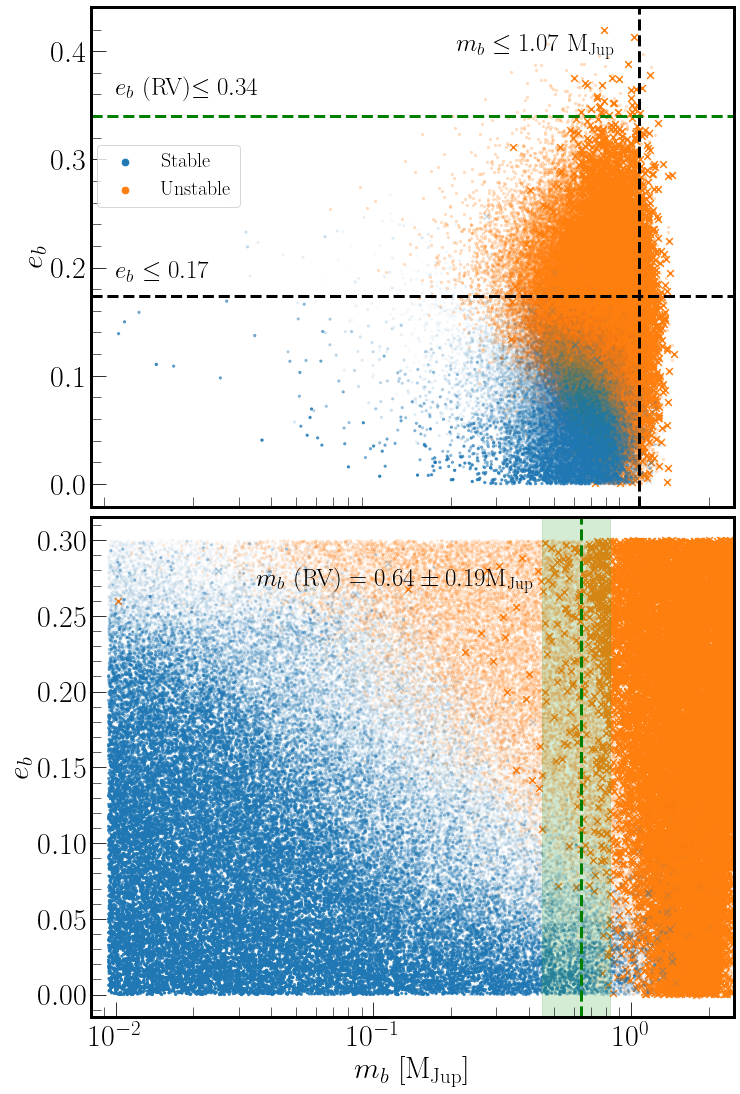

In [87]:
fig = plt.figure(1,figsize=(3*3.4, 6*3.4*3/4.))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30

# stable, in MMR
ax1.scatter(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0],
            eb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0],
            alpha=preds_rv[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mb_array[preds_rv > 0.0][(np.array(deltaH_db)[preds_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db)[preds_rv > 0.0]],
            eb_array[preds_rv > 0.0][(np.array(deltaH_db)[preds_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db)[preds_rv > 0.0]],
            alpha=preds_rv[preds_rv > 0.0][(np.array(deltaH_db)[preds_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db)[preds_rv > 0.0]],
            c='C0',marker='o',s=5,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] < 0)],
            eb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] < 0)], 
            alpha=1.0,c='C1',marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] >= 0)\
                                      | np.isnan(deltaH_db)[preds_rv == 0.0]],
            eb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] >= 0)\
                                     | np.isnan(deltaH_db)[preds_rv == 0.0]], 
            alpha=0.2,c='C1',s=5,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

##### log-uniform 

ax2.scatter(mb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu)[spock_prob_logu > 0.0] < 0],
            eb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu)[spock_prob_logu > 0.0] < 0],
      alpha=spock_prob_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu)[spock_prob_logu > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu > 0.0][(np.array(deltaH_db_logu)[spock_prob_logu > 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu > 0.0]],
            eb_array_logu[spock_prob_logu > 0.0][(np.array(deltaH_db_logu)[spock_prob_logu > 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu > 0.0]],
      alpha=spock_prob_logu[spock_prob_logu > 0.0][(np.array(deltaH_db_logu)[spock_prob_logu > 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu > 0.0]],
            c='C0',marker='o',s=5,zorder=1)

ax2.scatter(mb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu)[spock_prob_logu == 0.0] < 0],
            eb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu)[spock_prob_logu == 0.0] < 0], 
            alpha=1.0,c='C1',marker='x',s=45,zorder=0, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu == 0.0][(np.array(deltaH_db_logu)[spock_prob_logu == 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu == 0.0]],
            eb_array_logu[spock_prob_logu == 0.0][(np.array(deltaH_db_logu)[spock_prob_logu == 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu == 0.0]], 
            alpha=0.1,c='C1',s=5,marker='o',zorder=0, rasterized=True)

ax2.axvline(x=0.64, ls='--', color='g', lw=3)
ax2.axvspan(0.64-0.19,0.64+0.19, alpha=0.2, color='C2')

ax2.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size,zorder=0)
ax2.set_ylabel('$e_b$',fontsize=size)
ax2.set_xscale('log')
ax2.minorticks_on()

ax1.set_xlim(8e-3, 2.5)
ax2.set_xlim(8e-3, 2.5)
ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.21,0.40,r'$m_b \leq {}$'.format(1.07)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.035,0.27,r'$m_b\ (\rm{RV}) = 0.64 \pm 0.19$' + '$\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax1.text(0.01,0.19,r'$e_b$' + "~$\leq {}$".format(0.17),dict(size=25))
ax1.text(0.01,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
plt.tight_layout()

#plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

## Selecting all configurations in the 3:2 resonance for $c$ and $d$

In [46]:
logu_inres = np.array(logu_post)[np.array(deltaH_cd_logu) < 0.0] 
logu_outres = np.array(logu_post)[(np.array(deltaH_cd_logu) >= 0.0) | np.isnan(np.array(deltaH_cd_logu))]

In [47]:
print(np.shape(rv_inres),np.shape(logu_inres))

(21623, 6) (21604, 6)


In [48]:
mb_inres = (10**np.array([rv_inres[i][-2] for i in range(len(rv_inres))]))/9.54e-4
eb_inres = np.array([rv_inres[i][-1] for i in range(len(rv_inres))])

mb_inres_logu = (10**np.array([logu_inres[i][-2] for i in range(len(logu_inres))]))/9.54e-4
eb_inres_logu = np.array([logu_inres[i][-1] for i in range(len(logu_inres))])

In [55]:
# stability for 3:2 resonance
preds_inres_rv = preds_rv[np.array(deltaH_cd) < 0.0]
preds_inres_logu = preds_logu[np.array(deltaH_cd_logu) < 0.0]
print(len(preds_inres_rv) == len(mb_inres))
print(len(preds_inres_logu) == len(mb_inres_logu))

True
True


In [110]:
# rv configurations with both resonances
len(np.array(deltaH_db)[(np.array(deltaH_cd) < 0.0) & (np.array(deltaH_db) < 0.0)])

3084

In [108]:
# stable, inside 3:2 resonance and 2:1 resonance
len(np.array(mb_array)[(np.array(deltaH_cd) < 0.0) & (np.array(deltaH_db) < 0.0) & (preds_rv > 0.0)])

142

In [109]:
# unstable, inside 3:2 resonance and 2:1 resonance
len(np.array(mb_array)[(np.array(deltaH_cd) < 0.0) & (np.array(deltaH_db) < 0.0) & (preds_rv == 0.0)])

2942

In [67]:
# rv configurations inside the 3:2 resonance but outside the 2:1 resonance
len(np.array(deltaH_db)[(np.array(deltaH_cd) < 0.0) & ((np.array(deltaH_db) >= 0.0) | np.isnan(deltaH_db))])

18377

In [107]:
# stable, MMR chain break
print(len(mb_array[(np.array(deltaH_cd) < 0.0) & ((np.array(deltaH_db) >= 0.0) | np.isnan(deltaH_db)) &\
                      (preds_rv > 0.0)]))
# unstable, MMR chain break
print(len(mb_array[(np.array(deltaH_cd) < 0.0) & ((np.array(deltaH_db) >= 0.0) | np.isnan(deltaH_db)) &\
                      (preds_rv == 0.0)]))

4957
13411


In [76]:
len(mb_array[preds_rv > 0.0])

28170

In [95]:
def mmr_break(arr, cd_res, db_res, preds_arr, stable=True, chain=True):

    if stable:
        if chain: 
            res21 = arr[(np.array(cd_res) < 0.0) & (np.array(db_res) < 0.0) & (preds_arr > 0.0)]
        else:
            res21 = arr[(np.array(cd_res) < 0.0) & ((np.array(db_res) >= 0.0) | np.isnan(db_res)) &\
                        (preds_arr > 0.0)]
    else:
        if chain:
            res21 = arr[(np.array(cd_res) < 0.0) & (np.array(db_res) < 0.0) & (preds_arr == 0.0)]
        else:
            
            res21 = arr[(np.array(cd_res) < 0.0) & ((np.array(db_res) >= 0.0) | np.isnan(db_res)) &\
                        (preds_arr == 0.0)]
    return res21

In [79]:
preds_inmmr = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)
preds_outmmr = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)

prob_inmmr = np.sum(preds_inmmr)/(np.sum(preds_outmmr) + np.sum(preds_outmmr))
print(prob_inmmr)

0.012478443


In [65]:
len(preds_outmmr)

4957

In [64]:
len(preds_inmmr)

142

The above numbers show that there are:
* 142 stable configurations in the resonance change
* 4,957 stable configurations in the 3:2 MMR and outside the 2:1 MMR (resonance chain break)

These numbers don't add to the total number of stable configurations because I've only taken the subset of configurations inside the 3:2 MMR.

In [183]:
sigma=0.997
three_sigma_inres = [float(DescrStatsW(data=np.array(rv_inres)[:,i], 
                                    weights=spock_inres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_inres)[1])]
print((10**three_sigma_inres[-2])/9.54e-4, three_sigma_inres[-1])

1.0727185838928108 0.1817541331322567


In [184]:
sigma=0.997
three_sigma_outres = [float(DescrStatsW(data=np.array(rv_outres)[:,i], 
                                    weights=spock_outres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_outres)[1])]
print((10**three_sigma_outres[-2])/9.54e-4, three_sigma_outres[-1])

1.0719223287498665 0.17088844706028591


In [58]:
fig = plt.figure(1,figsize=(3*3.4, 6*3.4*3/4.))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30
c1 = 'C0'
c2 = 'C1'

# stable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            c=c1,marker='x',s=45,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            c=c1,marker='o',s=5,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True), 
            alpha=1.0,c=c2,marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False), 
            alpha=0.2,c=c2,s=5,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

##### log-uniform 

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=True),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=True),
      alpha=mmr_break(preds_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=True),
            c=c1,marker='x',s=45,zorder=1, rasterized=True)

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=False),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=False),
      alpha=mmr_break(preds_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=False),
            c=c1,marker='o',s=5,zorder=1, rasterized=True)

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=True),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=True), 
            alpha=1.0,c=c2,marker='x',s=45,zorder=0, rasterized=True)

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=False),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=False), 
            alpha=0.2,c=c2,s=5,marker='o',zorder=0, rasterized=True)

ax2.axvline(x=0.64, ls='--', color='g', lw=3)
ax2.axhline(y=0.13, ls='--', color='g', lw=3)
ax2.axvspan(0.64-0.19,0.64+0.19, alpha=0.2, color='g')
ax2.axhspan(0.13-0.07,0.13+0.07, alpha=0.2, color='g')

ax2.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size,zorder=0)
ax2.set_ylabel('$e_b$',fontsize=size)
ax2.set_xscale('log')
ax2.minorticks_on()

ax1.set_xlim(8e-3, 2.5)
ax2.set_xlim(8e-3, 2.5)
ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.21,0.40,r'$m_b \leq {}$'.format(1.08)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.035,0.27,r'$m_b\ (\rm{RV}) = 0.64 \pm 0.19$' + '$\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.045,0.21,r'$e_b\ (\rm{RV}) = 0.13 \pm 0.07$',dict(size=25))
ax1.text(0.01,0.19,r'$e_b$' + "~$\leq {}$".format(0.18),dict(size=25))
ax1.text(0.01,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
plt.tight_layout()

#plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

<ipython-input-58-35c280cf2189>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(211)
<ipython-input-58-35c280cf2189>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(212)


TypeError: alpha must be a float or None

In [37]:
len(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True))

142

In [115]:
len(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False))

4957

In [116]:
142+4957

5099

## Figure 3 single panel

<ipython-input-105-ec64cb7dc090>:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure3_singlepanel.pdf',dpi=300,bbox_inches='tight',padding=0)


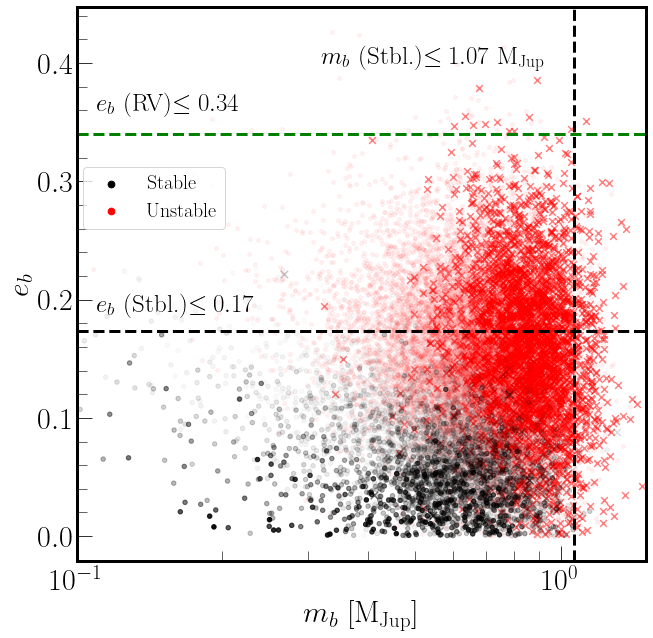

In [105]:
fig = plt.figure(1,figsize=(3*3.4, 4*3.4*3/4.))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30
c1 = 'k'
c2 = 'r'

# stable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            c=c1,marker='x',s=55,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            c=c1,marker='o',s=20,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True), 
            alpha=0.5,c=c2,marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False), 
            alpha=0.05,c=c2,s=15,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_xlabel(r'$m_b$ [$\rm{M_{Jup}}$]',fontsize=size)
ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

ax1.set_xlim(0.1, 1.5)
#ax2.set_xlim(8e-3, 2.5)
#ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

#ax2.tick_params(axis='y', labelsize=30)
#ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.32,0.40,r'$m_b$'+ "~(\\rm{Stbl.})"+"$\leq {}$".format(1.07)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax1.text(0.11,0.19,r'$e_b$' + "~(\\rm{Stbl.})"+"$\leq {}$".format(0.17),dict(size=25))
ax1.text(0.11,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
#plt.tight_layout()

plt.savefig('figures/Figure3_singlepanel.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

In [241]:
sigma=0.997
three_sigma = [float(DescrStatsW(data=np.array(rv_post)[:,i], 
                                    weights=preds_rv).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_post)[1])]
print((10**three_sigma[-2])/9.54e-4, three_sigma[-1])

1.0726505134626774 0.1742091240151863


In [179]:
mb_post = (10**np.array([rv_post[i][-2] for i in range(len(rv_post))]))/9.54e-4
eb_post = np.array([rv_post[i][-1] for i in range(len(rv_post))])

<ipython-input-182-2d2911606c5c>:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure3_singlepanel_all.pdf',dpi=300,bbox_inches='tight',padding=0)


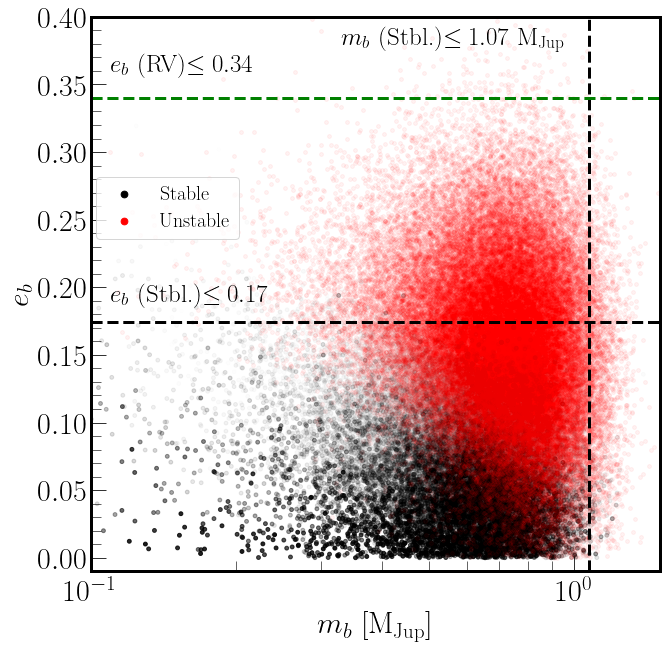

In [182]:
fig = plt.figure(1,figsize=(3*3.4, 4*3.4*3/4.))
ax1 = fig.add_subplot(111)

size = 30
c1 = 'k'
c2 = 'r'

# stable
ax1.scatter(mb_post[preds_rv!=0.0],
            eb_post[preds_rv!=0.0],
            alpha=preds_rv[preds_rv!=0.0],
            c=c1,s=15,zorder=1, rasterized=True,label='Stable')

# unstable
ax1.scatter(mb_post[preds_rv==0.0],
            eb_post[preds_rv==0.0],
            alpha=0.05,
            c=c2,s=15,zorder=1, rasterized=True,label='Unstable')

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_xlabel(r'$m_b$ [$\rm{M_{Jup}}$]',fontsize=size)
ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

ax1.set_xlim(0.1, 1.5)
ax1.set_ylim(-0.01,0.4)

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)


leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.33,0.38,r'$m_b$'+ "~(\\rm{Stbl.})"+"$\leq {}$".format(1.07)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax1.text(0.11,0.19,r'$e_b$' + "~(\\rm{Stbl.})"+"$\leq {}$".format(0.17),dict(size=25))
ax1.text(0.11,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
#plt.tight_layout()

plt.savefig('figures/Figure3_singlepanel_all.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

<ipython-input-248-2d47553a8e71>:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure3_whists.pdf',dpi=300,bbox_inches='tight',padding=0)


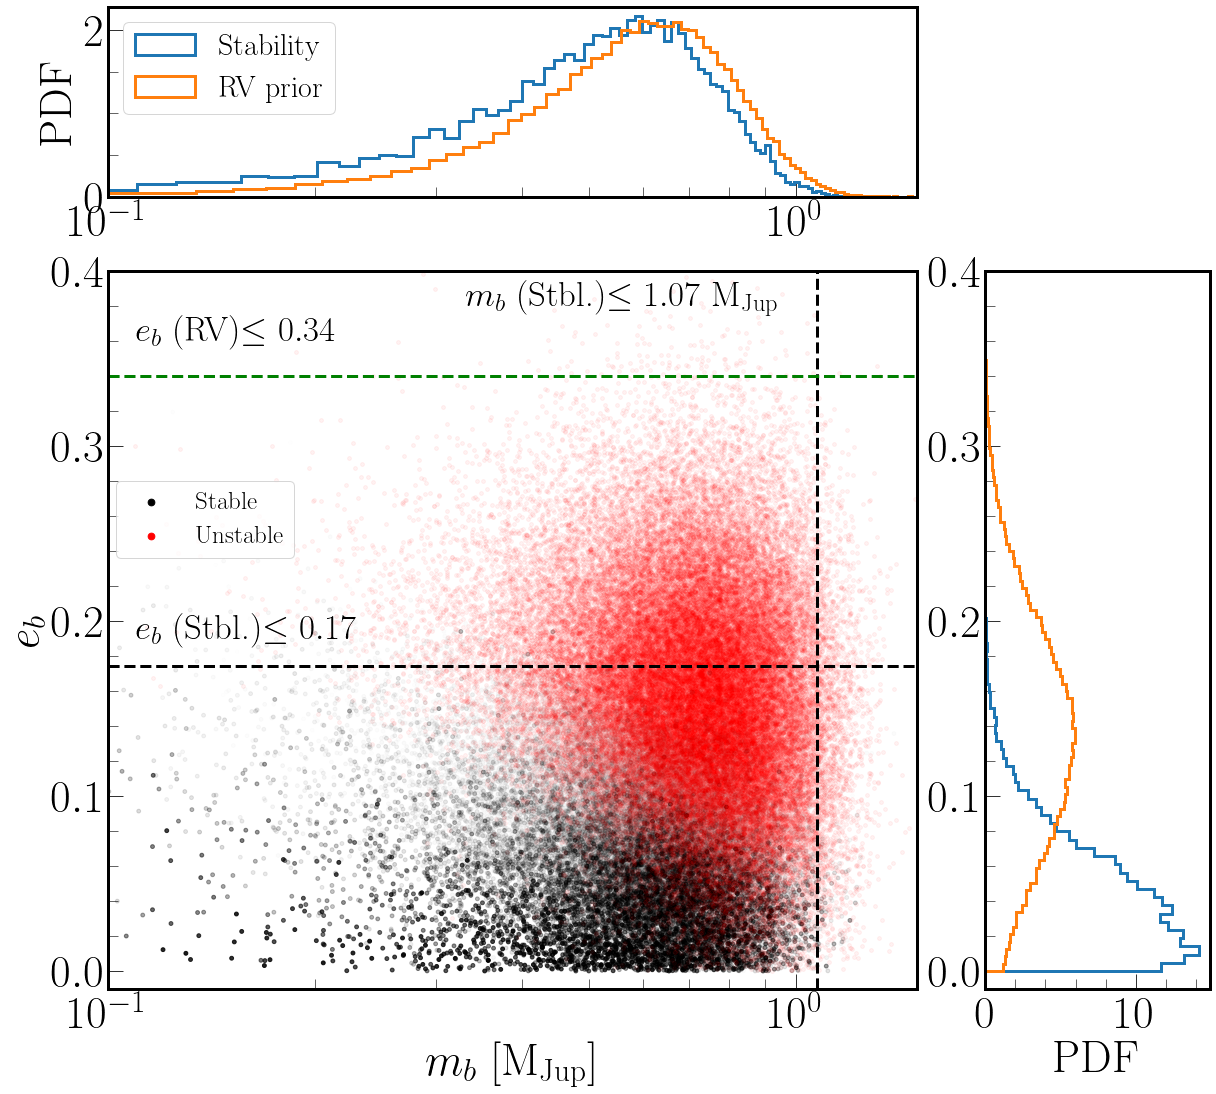

In [248]:
fig = plt.figure(figsize=(5*3.4, 6*3.4*3/4.))
gs = GridSpec(4,4)

ax1 = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

size = 45
c1 = 'k'
c2 = 'r'

# stable
ax1.scatter(mb_post[preds_rv!=0.0],
            eb_post[preds_rv!=0.0],
            alpha=preds_rv[preds_rv!=0.0],
            c=c1,s=15,zorder=1, rasterized=True,label='Stable')

# unstable
ax1.scatter(mb_post[preds_rv==0.0],
            eb_post[preds_rv==0.0],
            alpha=0.05,
            c=c2,s=15,zorder=1, rasterized=True,label='Unstable')

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_xlabel(r'$m_b$ [$\rm{M_{Jup}}$]',fontsize=size)
ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

ax1.set_xlim(0.1, 1.5)
ax1.set_ylim(-0.01,0.4)

ax1.tick_params(axis='y', labelsize=size)
ax1.tick_params(axis='x', labelsize=size)


leg1 = ax1.legend(prop={'size':25}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.33,0.38,r'$m_b$'+ "~(\\rm{Stbl.})"+"$\leq {}$".format(1.07)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=size-10))
ax1.text(0.11,0.19,r'$e_b$' + "~(\\rm{Stbl.})"+"$\leq {}$".format(0.17),dict(size=size-10))
ax1.text(0.11,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=size-10))

ax_marg_x.hist(mb_array, bins=100, histtype='step', weights=preds_rv, density=True, lw=3,
               label='Stability')
ax_marg_x.hist(mb_rv, bins=100, histtype='step', density=True, lw=3,
               label='RV prior')
#ax_marg_x.set_xlabel('$m_b$',fontsize=size)
ax_marg_x.set_xscale('log')
ax_marg_x.minorticks_on()
ax_marg_x.set_xlim(0.1, 1.5)
#ax_marg_x.text(-3.45,0.8,r'$\leq {}$'.format(0.35)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=30))
ax_marg_x.set_ylabel('PDF',fontsize=size)
ax_marg_x.tick_params(axis='x', labelsize=size)
ax_marg_x.tick_params(axis='y', labelsize=size)
ax_marg_x.legend(loc='upper left',prop={'size':30})
ax_marg_x.minorticks_on()

ax_marg_y.hist(eb_array, bins=100, histtype='step', weights=preds_rv, density=True, 
               orientation=u"horizontal",lw=3,label='Stability')
ax_marg_y.hist(eb_rv, bins=100, histtype='step', density=True,
               orientation=u"horizontal",lw=3,label='RV prior')
ax_marg_y.set_xlabel('$e_b$',fontsize=size)
ax_marg_y.set_ylim(-0.01,0.4)
ax_marg_y.set_xlabel('PDF')
ax_marg_y.tick_params(axis='y', labelsize=size)
ax_marg_y.tick_params(axis='x', labelsize=size)
ax_marg_y.minorticks_on()

plt.tight_layout()
plt.savefig('figures/Figure3_whists.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [111]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

57

In [112]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

3444

In [113]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

1151

In [114]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

9726

In [152]:
(55+3409)/(1217 + 9739)

0.31617378605330415

In [155]:
np.mean(rv_region)

0.1210724

In [157]:
np.mean(rv_region)

0.10788167